In [1]:
from bs4 import BeautifulSoup as BS
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
% matplotlib inline
import seaborn as sns

import geopandas as gpd
from shapely.geometry import Point

import datetime

In [2]:
class WebScrapingToDF(object):
    def __init__(self, url):
        self._url = url
    
    def start(self, table_class="sortable wikitable"):
        """
            1. make initial request
            2. turn the request into soup object
            3. get table
            4. from table get columns and rows
            5. return pandas dataframe of data obtained
        """
        url_html = self._make_request()
        soup = BS(url_html, 'html.parser')
        
        table = WebScrapingToDF._get_table(soup, table_class=table_class)
        
        columns = WebScrapingToDF._get_headers(table)
        rows = WebScrapingToDF._get_rows(table)
        
        return pd.DataFrame(data=rows, columns=columns)
    
    def _make_request(self):
        request = urllib.request.Request(self._url)
        result = urllib.request.urlopen(request)
        return result.read()
    
    @staticmethod
    def _get_table(soup, table_class):
        table_html = soup.find_all('table', class_=table_class)
        return table_html[0]
    
    @staticmethod
    def _get_headers(table):
        table_headers = table.find_all("th")
        return [th.text for th in table_headers]
    
    @staticmethod
    def _get_rows(table):
        rows = []
        for tr in table.find_all("tr")[1:]:
            row_data = [td.text for td in tr.find_all("td")]
            rows.append(row_data)
            
        return rows
    

# We are using data from multiple resources. Here is all the links we used to gather this info!!! Results are all dataframes :D 

In [3]:
# Gather earthquakes info
earthquakes_scraping = WebScrapingToDF(url="https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900")
earthquakes = earthquakes_scraping.start()

In [4]:
# Gather volcano info
volcanoes_scraping = WebScrapingToDF(url="http://volcano.oregonstate.edu/volcano_table")
volcanoes = volcanoes_scraping.start(table_class="views-table cols-6")

In [5]:
# Gather vents info
vents_scraping = WebScrapingToDF(url="http://vents-data.interridge.org/ventfields_list_all")
vents = vents_scraping.start(table_class="views-table cols-8")

In [6]:
class CleanData(object):
    def __init__(self, df):
        self._df = df
        
    def clean_col_by_regex(self, regex, column):
        self._df[column] = self._df[column].str.replace(regex, "")
        
    def nan_to_float32(self, columns, value=0, inplace=True):    
        for col in columns:        
            self._df[col].fillna(value=value, inplace=inplace)
            self._df[col] = pd.to_numeric(self._df[col], downcast='float')
            
    def strip_columns(self, columns):
        for column in columns:
            self._df[column] = self._df[column].str.strip()      

## Cleaning the Earthquake Data

In [7]:
class CleanEarthquakes(CleanData):
    def __init__(self, df):
        super(CleanEarthquakes, self).__init__(df)
        
    def clean_cols_by_extract(self, columns, regex):
        for col in columns:
            self._df[col] = self._df[col].str.extract(regex, expand=True)
        
    def convert_nan_lat_lng(self, is_nan):
        """There are son lat/lng values in the dataframe that didn't exist on the wiki page, so we looked up the coords
            and assigned them to their appropriate location

            First index is LNG, second is LAT
        """
        for loc, coords in is_nan.items():
            self._df.iloc[loc, self._df.columns.get_loc('lng')] = coords[0]
            self._df.iloc[loc, self._df.columns.get_loc('lat')] = coords[1]

        assert self._df[self._df["lat"].isnull()].empty == True
        assert self._df[self._df["lng"].isnull()].empty == True
        
    def convert_values_in_row_by_index(self, index, **kwargs):
        """There is a unique case where the lat/lng as well as depth values are '?' or '??'"""
        for key, value in kwargs.items():
            self._df.iloc[index, self._df.columns.get_loc(key)] = value    
            
    def get_mean_deaths(self, column):
        """There can potentially be multiple values within the Other Source Deaths column. So, this is grabbing the 
            values and determining the mean
        """
        means = []
        for row in self._df[column]:
            if isinstance(row, str):
                int_list = row.strip().split(" ")
                total = 0
                total = sum(list(map(int, map(float, int_list))))

                mean = total / len(int_list)
                means.append(mean)
            else:
                means.append(row)

        self._df[column] = means

In [8]:
# rename columns
earthquakes.columns = ["UTC", "Country", "lat", "lng", "Depth_km", "Mag", "Secondary_Effects", "PDE_Shaking_Deaths", "PDE_Deaths", "Utsu_Deaths", "EM-DAT_Deaths", "Other_Deaths"]

In [9]:
clean_earthquakes = CleanEarthquakes(earthquakes)

clean_earthquakes.clean_col_by_regex(regex=r"(\[\d+\]|\(.*\)|\*|\+|\,)", column="Other_Deaths")
clean_earthquakes.clean_col_by_regex("(\s\(.*)", column="Country")

is_nan = {439: [69.13, 41.16], 1319: [90.302, 29.759], 1320: [67.484, 30.569], 1323: [101.086, 25.619], 1324: [138.276, 34.778], 1325: [107.328, -7.778], 1326: [-171.87, -15.53], 1327: [99.97, 0.71], 1330: [40.03, 38.79], 1331: [-72.13, -34.301], 1332: [96.629, 33.165], 1333: [172.7012, -43.5834], 1334: [97.994, 24.71], 1336: [99.949, 20.705]}
clean_earthquakes.convert_nan_lat_lng(is_nan)

"""There is a unique case where the lat/lng as well as depth values are '?' or '??'"""
question_index = earthquakes[earthquakes["lat"] == "?"].index
clean_earthquakes.convert_values_in_row_by_index(question_index, lat=21.4, lng=42.1, Depth_km=6)

"""There are some bad characters in this column, so this regex just grabs the int"""
clean_earthquakes.clean_cols_by_extract(columns=['EM-DAT_Deaths', 'Mag'], regex='(\d+\.\d*)')

"""Transforms the column in the dataframe to a float32 column, rather than the object type. 
    Also fills all NaN values to 0.
"""
columns_to_convert = ['PDE_Deaths', 'PDE_Shaking_Deaths', 'Utsu_Deaths', 'EM-DAT_Deaths', 'Mag', 'lat', 'lng', 'Depth_km']
clean_earthquakes.nan_to_float32(columns=columns_to_convert)

In [10]:
# Create the apropriate datetime columns with padding for javascript visuals
earthquakes["UTC"] = pd.to_datetime(earthquakes["UTC"])
earthquakes["Year"] = pd.DatetimeIndex(earthquakes["UTC"]).year
earthquakes["Month"] = pd.DatetimeIndex(earthquakes["UTC"]).month.map("{:02}".format)
earthquakes["Day"] = pd.DatetimeIndex(earthquakes["UTC"]).day.map("{:02}".format)

In [11]:
# Creating a new column 'deaths' that is the max of these four columns
subdf = earthquakes[["PDE_Deaths", "Utsu_Deaths", "EM-DAT_Deaths", "Other_Deaths"]]
earthquakes["Max_Deaths"] = subdf.max(axis = 1)

[Text(0,0,'China'),
 Text(0,0,'Indonesia'),
 Text(0,0,'Turkey'),
 Text(0,0,'Iran'),
 Text(0,0,'Japan'),
 Text(0,0,'Peru'),
 Text(0,0,'Taiwan'),
 Text(0,0,'Mexico'),
 Text(0,0,'Chile'),
 Text(0,0,'Greece'),
 Text(0,0,'Philippines'),
 Text(0,0,'Italy'),
 Text(0,0,'United States'),
 Text(0,0,'Afghanistan'),
 Text(0,0,'Pakistan'),
 Text(0,0,'India'),
 Text(0,0,'Colombia'),
 Text(0,0,'Algeria'),
 Text(0,0,'Ecuador'),
 Text(0,0,'Papua New Guinea'),
 Text(0,0,'Guatemala'),
 Text(0,0,'South Africa'),
 Text(0,0,'Russian Federation'),
 Text(0,0,'Argentina'),
 Text(0,0,'Burma')]

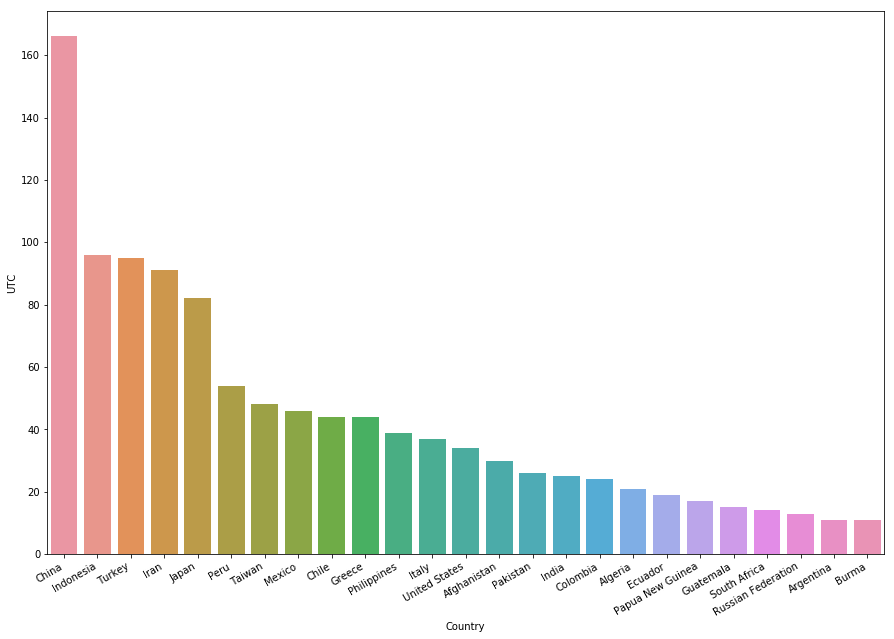

In [12]:
quakes_country_25 = earthquakes.groupby("Country").agg(len).reset_index().nlargest(25, columns="UTC")

f, ax = plt.subplots(figsize=(15, 10))
#plt.ylabel('Number of Quakes')
quake_count = sns.barplot(x='Country', y='UTC', data=quakes_country_25)
quake_count.set_xticklabels(quake_count.get_xticklabels(), rotation=30, ha="right")

Top 25 countries according to number of earthquakes. Earthquakes were grouped country and plotted. Y-axis is number of earthquakes.

#Future analysis should normalize for surface area of country.

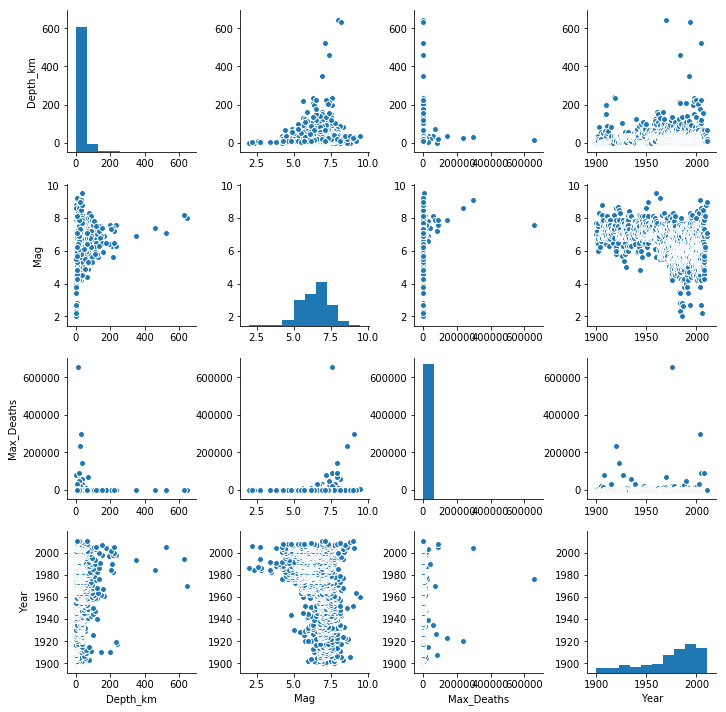

In [13]:
"""Trying to find any correlation between these columns. Most interesting find is between Depth and Mag"""
earthquakes_cont = earthquakes[["Depth_km", "Mag", "Max_Deaths", "Year"]]
earthquakes_cont = earthquakes_cont.replace("?", np.nan)
earthquakes_cont = earthquakes_cont.dropna()

sns.pairplot(earthquakes_cont, dropna=True)

Multiple comparisons between scalar values from earthquake measurements. In general no correlations exist. Magnitude (Mag) appears to be normally distributed with the mean around 7.2.

In [14]:
# Total deaths by country
occurrence_death = earthquakes[['Country', 'Max_Deaths']].groupby(['Country']).agg(['sum', 'count'])
occurrence_death.columns=['Total Deaths', 'Frequency of Earthquakes']

EQ_Casualities = occurrence_death.sort_values(['Frequency of Earthquakes'], ascending=False)
EQ_Casualities.head()

,Total Deaths,Frequency of Earthquakes
Country,,
China,1138388.0,166
Indonesia,342112.0,96
Turkey,90836.0,95
Iran,152664.0,91
Japan,166997.0,82


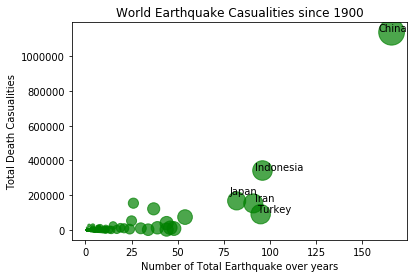

In [15]:
# Base size of dots based on frequency
np_death = np.array(EQ_Casualities['Frequency of Earthquakes'])
np_death = np_death*4

# Find correlation between Frequency and Total Deaths
plt.scatter(EQ_Casualities['Frequency of Earthquakes'], EQ_Casualities['Total Deaths'], s=np_death, color='green', alpha=0.7)

# Hard code some labels
plt.text(159, 1143382.0, 'China')
plt.text(93, 103304.0, 'Turkey')
plt.text(92, 167960.0, 'Iran')
plt.text(92, 343574.0, 'Indonesia')
plt.text(78, 205148.0, 'Japan')

plt.xlabel('Number of Total Earthquake over years')
plt.ylabel('Total Death Casualities')

plt.title('World Earthquake Casualities since 1900')

plt.show()

In [16]:
earthquakes.drop("UTC", inplace=True, axis=1)
earthquakes.to_json("JSONs_for_TP/earthquakes_original.json")

## Cleaning the Volcano Data

In [17]:
class CleanVolcanoes(CleanData):
    def __init__(self, df):
        super(CleanVolcanoes, self).__init__(df)
        
    def replace_all_rows_by_regex(self, regex):
        self._df.replace(to_replace=regex, value="", regex=True, inplace=True)     

In [18]:
volcanoes.columns = ["Name", "Country", "Type", "lat", "lng", "Elevation"]

In [19]:
clean_volcanos = CleanVolcanoes(volcanoes)

# Replacing new lines and spaces with empty strings
clean_volcanos.replace_all_rows_by_regex(regex="(\n|\n\s)")

# remove extra whitespace from these columns
clean_volcanos.strip_columns(columns=['lat', 'lng', 'Elevation'])

# Convert lat and lng vals to numeric
columns_to_convert = ['lat', 'lng', 'Elevation']
clean_volcanos.nan_to_float32(columns=columns_to_convert)


## Cleaning the Vents Data

In [20]:
class CleanVents(CleanData):
    def __init__(self, df):
        super(CleanVents, self).__init__(df)
        

In [21]:
# Renaming columns
vents.columns = ["Name", "Activity", "Tectonic Setting", "Region", "lat", "lng", "Depth", "Year&Discovered"]

In [22]:
# Some basic cleaning of the rows
vents = vents.replace(to_replace="(\n|\n\s)", value="", regex=True)

clean_vents = CleanVents(df=vents)

# Strip extra whitespace from these columns
clean_vents.strip_columns(columns=['lat', 'lng', 'Year&Discovered', 'Depth'])

# Turn appropriate columns to numeric
clean_vents.nan_to_float32(["lat", "lng", "Depth"])

## Create GeoPandas DFs to Graph Later On

In [23]:
def create_gdf(df):
    geometry = [Point(xy) for xy in zip(df.lng, df.lat)]
        
    crs = {"init": "epsg:4326"} 
    return gpd.GeoDataFrame(df, crs=crs, geometry=geometry)

In [24]:
earthquakes_gdf = create_gdf(df=earthquakes)
volcanoes_gdf = create_gdf(df=volcanoes)
vents_gdf = create_gdf(df=vents)

In [25]:
# Import plates and countries geojson to plot
plates_gdf = gpd.read_file("MR_Data/PB2002_plates.json")
countries_gdf = gpd.read_file("MR_Data/countries.geojson")

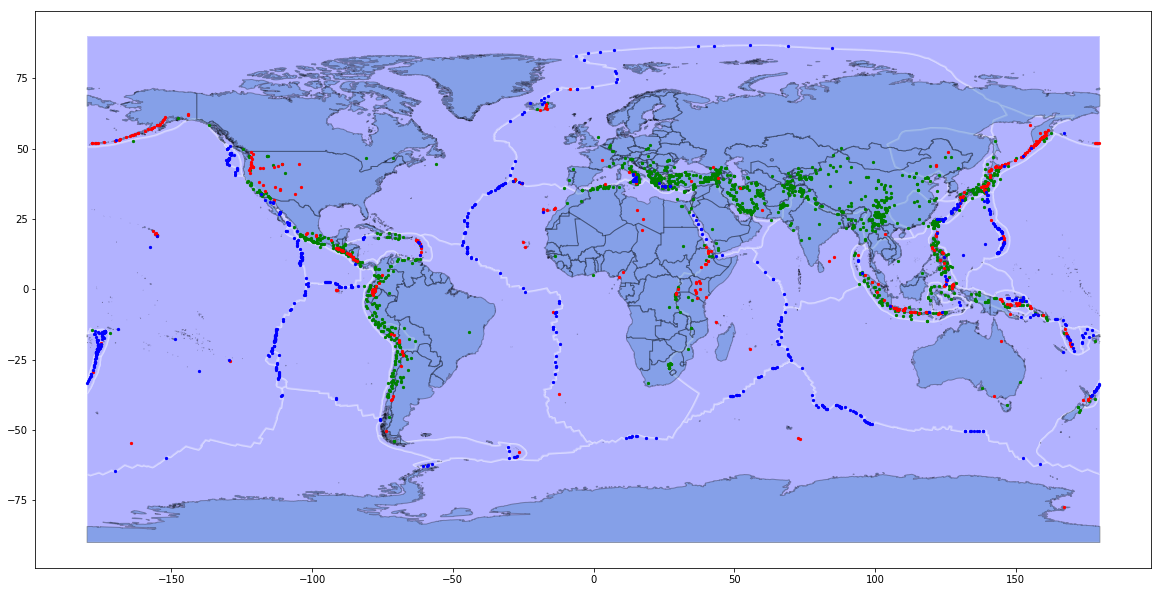

In [26]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_aspect('equal')

# Countries and plates
plates_gdf.plot(ax=ax, color='blue', edgecolor='white', alpha=0.3, lw=2.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha=0.3)

# all points (earthquakes, volcanoes, and vents)
earthquakes_gdf.plot(ax=ax, markersize=5, color="green")
volcanoes_gdf.plot(ax=ax, markersize=5, color="red")
vents_gdf.plot(ax=ax, markersize=5, color="blue")

Map showing locations of Earthquakes (green), Volcanoes (red), and Hydrothermal Vents (blue). Tectonic plates are outlined in white. Political boundaries for countries are outlined in black. Hydrothermal Vents overlap with oceanic plate boundaries but not much with either Earthquakes or Volcanoes. Earthquakes and Volcanoes have much overlap and both occur mainly around plate boundaries. In Asia Earthquakes occur in more isolation and further away from plate boundaries.

"""Future maps could show additional geophysical properties such as orogens:
An orogeny is an event that leads to a large structural deformation of the Earth's lithosphere (crust and uppermost mantle) due to the interaction between tectonic plates. An orogen or orogenic belt develops when a continental plate crumples and is pushed upwards to form one or more mountain ranges; this involves many geological processes collectively called orogenesis. (https://en.wikipedia.org/wiki/Orogeny)

orogen_gdf = gpd.read_file("MR_Data/PB2002_orogens.json")

fig, ax = plt.subplots(figsize=(20, 20))
ax.set_aspect('equal')
plates_gdf.plot(ax=ax, color='blue', edgecolor='white', alpha=0.3, lw=2.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha=0.3)
earthquakes_gdf.plot(ax=ax, markersize=5, color="green")
volcanoes_gdf.plot(ax=ax, markersize=5, color="red")
vents_gdf.plot(ax=ax, markersize=5, color="blue")
orogen_gdf.plot(ax=ax, alpha = 0.4)

The map that renders shows that there is a large orogen encompassing much of China and the Earthquakes that are further away from plate boundaries. Future analyses should consider proximity or influence of orogens for occurances of earthquakes.
"""

In [27]:
# Now that we have our data plotted out, we want to categorize the earthquakes based on location. 
# How close are they to the plates, and which plates are they closest to?
boundaries_gdf = gpd.read_file("MR_Data/PB2002_steps.json")

In [28]:
class ClosestPointLogic(object):
    def __init__(self, from_df, to_df, categories, extra_column_name):
        self._from_df = from_df
        self._to_df = to_df
        self._categories = categories
        self._extra_column_name = extra_column_name
    
    # We are wanting to grab the geometry columns per type of volcano
    def get_geometries_from_gdf(self, column):
        geometry_types = list()
        for df_type in self._categories:
            if df_type == 'None':
                df_type_geometry = self._to_df[self._to_df[column].str.contains("")].geometry
            else: 
                df_type_geometry = self._to_df[self._to_df[column].str.contains(df_type)].geometry

            geometry_types.append(df_type_geometry)
            
        # Add on the geometry from the overall df to compare against        
        geometry_types.extend([self._to_df.geometry]) 
        
        return geometry_types
    
    def calculate_nearest(self, to_column, dist_df):
        # Determine closest point based on category
        conditions = list()
        for col in self._categories:
            if not col == self._extra_column_name:
                dist_bool = (dist_df[self._extra_column_name] == dist_df[col])
                conditions.append(dist_bool)

        dist_df[to_column] = np.select(conditions, self._categories, default=np.nan)
        
        return dist_df
    
    def create_total_dist_df(self, series_geometry_list):
        total_dist_list = self._calculate_total_dist_list(series_geometry_list)
        
        dist_pd = pd.DataFrame(total_dist_list)
        dist_pd = dist_pd.transpose()

        dist_pd.columns = self._categories + [self._extra_column_name]

        return pd.concat([self._from_df, dist_pd], axis=1)
    
    def _calculate_total_dist_list(self, series_geometry_list):
        total_dist_list = []

        for geoseries in series_geometry_list:
            dist_list = self._quake_distance(geoseries)
            total_dist_list.append(dist_list)
            
        return total_dist_list
    
    def _quake_distance(self, geoseries):
        dist_list = []
        for quake in self._from_df.geometry:
            print(quake)
            dist = np.min([quake.distance(series) for series in geoseries if series])
            print(dist)
            dist_list.append(dist)

        return dist_list

In [29]:
vol_types = ["Stratovolcano", "Caldera", "Shield", "Complex Volcano", "Submarine", "Volcanic Field", "Cinder Cone", "Dome",
        "Fissure vents", "Somma Volcano", "Maar", "Pyroclastic Cone", "Tuff Ring", "Plug", "None"]

volcanoes_to_earthquake_logic = ClosestPointLogic(
    from_df=earthquakes_gdf,
    to_df=volcanoes_gdf,
    categories=vol_types,
    extra_column_name='vol'
)

In [30]:
vol_series_geometry_list = volcanoes_to_earthquake_logic.get_geometries_from_gdf(column='Type')

quake_vol_dist = volcanoes_to_earthquake_logic.create_total_dist_df(
    series_geometry_list=vol_series_geometry_list
)

quake_vol_dist = volcanoes_to_earthquake_logic.calculate_nearest(
    to_column='closest_vol',
    dist_df=quake_vol_dist
)

POINT (141.1000061035156 38.70000076293945)
1.10163363025
POINT (43.09999847412109 40.29999923706055)
1.3416407865
POINT (-66 11)
5.35362463221
POINT (100.0999984741211 26)
7.38312448136
POINT (28.70000076293945 43.40000152587891)
6.98195685493
POINT (142.5 40.5)
1.82187269177
POINT (173 -43)
3.86005428375
POINT (141.3000030517578 40.5)
0.763682013248
POINT (48.59999847412109 40.70000076293945)
4.41474726782
POINT (33.59999847412109 40.70000076293945)
7.63974393086
POINT (-91 14)
0.48507825162
POINT (129.6000061035156 43.20000076293945)
7.88156355242
POINT (77 40)
20.8086520467
POINT (138 -35)
27.9575550797
POINT (72.30000305175781 40.79999923706055)
17.751902871
POINT (35.29999923706055 32.20000076293945)
9.24833415835
POINT (42.65000152587891 39.13999938964844)
1.74243909076
POINT (42.70000076293945 40.90000152587891)
1.99999923706
POINT (22.96999931335449 36.36000061035156)
1.50880869981
POINT (58.20000076293945 35.20000076293945)
6.13600862601
POINT (120.5 23.5)
3.38541143917
POINT

4.58415682928
POINT (43.79999923706055 41.70000076293945)
2.06155281281
POINT (-115.6969985961914 33.22200012207031)
10.4499970544
POINT (-77.62899780273438 -11.11900043487549)
7.42440217775
POINT (102.5 24.39999961853027)
5.01662238793
POINT (139.8289947509766 44.50799942016602)
2.21249685265
POINT (26.65500068664551 45.77299880981445)
9.19687384338
POINT (43.5 16.39999961853027)
3.27566761463
POINT (58.59999847412109 33.5)
5.67538582587
POINT (-102.9570007324219 18.67700004577637)
4.34620637504
POINT (127.1999969482422 47)
6.15588435274
POINT (99.40799713134766 23.51399993896484)
5.81145463555
POINT (92.47799682617188 12.14900016784668)
6.90854995992
POINT (43.29999923706055 39.5)
1.01980405234
POINT (102.3000030517578 31.70000076293945)
12.2612606291
POINT (39.40000152587891 39.70000076293945)
4.74124488933
POINT (132 32)
1.14214647295
POINT (120.390998840332 23.25099945068359)
3.21793931514
POINT (99.14499664306641 21.07600021362305)
4.74110067165
POINT (100.3000030517578 23.100000

2.00820786192
POINT (24.94599914550781 39.37200164794922)
2.71948953377
POINT (132.1920013427734 32.48199844360352)
1.44184877709
POINT (143.3459930419922 40.90299987792969)
2.56531661961
POINT (172.1230010986328 -41.74300003051758)
3.14273792515
POINT (-77.1510009765625 -5.558000087738037)
3.75140968085
POINT (-100.2590026855469 17.51499938964844)
2.22516269404
POINT (122.0780029296875 16.38400077819824)
2.13506839777
POINT (-97.77100372314453 16.49399948120117)
2.66486027315
POINT (119.6900024414062 0.05799999833106995)
5.14862246257
POINT (58.95999908447266 34.04499816894531)
6.13380834122
POINT (58.21200180053711 34.07199859619141)
6.32977918362
POINT (32.45199966430664 41.77099990844727)
7.40594494526
POINT (-62.71900177001953 10.73099994659424)
3.02048446277
POINT (-92.66000366210938 15.55099964141846)
1.36300455818
POINT (79.23899841308594 41.42599868774414)
23.4605306995
POINT (118.7990036010742 -3.178999900817871)
5.1335610214
POINT (-10.56799983978271 35.92300033569336)
9.769

0.400805254634
POINT (15.98999977111816 38.04600143432617)
1.03920967212
POINT (66.23400115966797 29.92799949645996)
6.52533160208
POINT (-99.78199768066406 16.93199920654297)
2.389556748
POINT (15.07299995422363 38.38100051879883)
0.157891869016
POINT (142.1049957275391 38.23500061035156)
1.9100419668
POINT (142.0090026855469 38.2239990234375)
1.81550237883
POINT (23.25699996948242 40.73199844360352)
4.20196330692
POINT (23.30299949645996 40.7599983215332)
4.21620107861
POINT (23.11199951171875 40.71799850463867)
4.23177180004
POINT (-90.98999786376953 14.75800037384033)
0.248809250946
POINT (57.38199996948242 33.24200057983398)
5.85939367501
POINT (-96.60299682617188 16.01099967956543)
3.62248513678
POINT (49.63399887084961 32.12799835205078)
4.55393094401
POINT (122.0090026855469 23.21699905395508)
2.74699992242
POINT (59.47100067138672 33.90900039672852)
5.93263229757
POINT (-72.55300140380859 -16.53700065612793)
1.03308446741
POINT (-101.2210006713867 17.75799942016602)
2.89099235

0.0799247322776
POINT (-77.43699645996094 -9.51200008392334)
7.56607917223
POINT (-115.8000030517578 47.47000122070312)
5.34842717918
POINT (-71.75700378417969 -13.40200042724609)
2.37981694892
POINT (76.39700317382812 32.11800003051758)
16.9062011503
POINT (37.78099822998047 37.99900054931641)
6.73726768483
POINT (43.70399856567383 41.40399932861328)
1.80522239963
POINT (121.6429977416992 24.14599990844727)
3.69427565305
POINT (37.90999984741211 38.00699996948242)
6.61047228921
POINT (-62.9109992980957 10.57299995422363)
3.25536577748
POINT (51.55699920654297 29.9109992980957)
6.06426823656
POINT (-117.8399963378906 33.06600189208984)
9.40982757435
POINT (-69.42400360107422 10.74300003051758)
8.30785055581
POINT (100.7539978027344 29.28000068664551)
10.1816940281
POINT (26.27099990844727 45.52099990844727)
8.97513663019
POINT (22.17600059509277 37.07199859619141)
2.29435788655
POINT (-89.16500091552734 13.79100036621094)
0.139090260355
POINT (121.7269973754883 23.97400093078613)
3.515

6.81810118193
POINT (26.65999984741211 -6.151000022888184)
5.30605900637
POINT (31.14399909973145 29.7140007019043)
7.9467992606
POINT (-76.76399993896484 7.092999935150146)
2.6340740323
POINT (31.53499984741211 29.7549991607666)
8.11528579646
POINT (-4.290999889373779 31.27499961853027)
12.7093590953
POINT (45.09600067138672 42.56100082397461)
2.75548145782
POINT (121.8320007324219 -8.498000144958496)
0.650171659755
POINT (100.7519989013672 26.32799911499023)
7.39665835815
POINT (26.79999923706055 -28.02799987792969)
26.6209797393
POINT (-76.59400177001953 18.05200004577637)
10.9527360942
POINT (144.1940002441406 43.02199935913086)
1.23081975154
POINT (144.1410064697266 43.02399826049805)
1.18055417603
POINT (101.4150009155273 25.82600021362305)
6.68983474252
POINT (86.14399719238281 42.20000076293945)
28.6399527647
POINT (-178.1620025634766 -14.40900039672852)
14.8629703943
POINT (87.35600280761719 29.00900077819824)
17.5968366325
POINT (21.52599906921387 37.61299896240234)
3.0536814

3.46808137393
POINT (29.35000038146973 40.73600006103516)
4.68886101095
POINT (-96.90499877929688 16.05500030517578)
3.42526853147
POINT (120.443000793457 23.5310001373291)
3.43878165236
POINT (30.72400093078613 40.69499969482422)
5.43627859515
POINT (30.24699974060059 40.7400016784668)
5.17224139086
POINT (31.2189998626709 40.80300140380859)
5.8502017629
POINT (102.8450012207031 24.58600044250488)
5.13482283373
POINT (168.2389984130859 -16.31599998474121)
0.223514657374
POINT (42.35400009155273 40.48199844360352)
2.09724415529
POINT (119.7760009765625 15.7790002822876)
0.866414649616
POINT (124.515998840332 11.29599952697754)
1.56047246091
POINT (105.4980010986328 -6.822999954223633)
0.727195660568
POINT (-1.315999984741211 35.20999908447266)
16.5094596462
POINT (101.1179962158203 25.54899978637695)
6.53678455629
POINT (101.0709991455078 25.5669994354248)
6.57150353773
POINT (103.6539993286133 24.14800071716309)
4.63812508422
POINT (58.2130012512207 35.23799896240234)
6.14439284115
PO

8.9602818772
POINT (135.60400390625 -3.688999891281128)
9.02619380484
POINT (95.97200012207031 3.286999940872192)
5.52100841901
POINT (119.9100036621094 -1.195999979972839)
5.34322309395
POINT (43.69100189208984 37.60300064086914)
2.18364083085
POINT (107.8160018920898 -7.004000186920166)
0.318454977947
POINT (123.3379974365234 5.321000099182129)
2.647619606
POINT (56.79399871826172 30.69099998474121)
4.18568096448
POINT (26.77499961853027 -26.88899993896484)
25.489444595
POINT (130.2089996337891 33.80199813842773)
1.98196320833
POINT (97.09700012207031 2.069000005722046)
4.17932371789
POINT (48.66899871826172 33.65499877929688)
4.13612477161
POINT (146.8459930419922 -6.355000019073486)
1.56223222494
POINT (-69.197998046875 -20.00699996948242)
1.59067062276
POINT (27.43499946594238 -26.4680004119873)
25.0139351652
POINT (125.0299987792969 46.88399887084961)
4.28698870272
POINT (-76.41400146484375 -5.721000194549561)
4.18990437825
POINT (73.58399963378906 34.46500015258789)
15.043977965

POINT (23.73200035095215 40.33300018310547)
10.9311077676
POINT (96.69000244140625 39.77099990844727)
34.7988852493
POINT (144.6219940185547 39.2239990234375)
3.90605872282
POINT (-118 33.63000106811523)
10.1768442829
POINT (27.14999961853027 36.51599884033203)
7.65087131512
POINT (104.4339981079102 -5.521999835968018)
9.85125242681
POINT (103.5410003662109 31.80999946594238)
24.9331826016
POINT (56 32.09999847412109)
22.4332631628
POINT (102.6999969482422 23.70000076293945)
20.7029985338
POINT (86.76200103759766 26.77300071716309)
27.0358637839
POINT (27.5 40.5)
7.28047440796
POINT (24.70299911499023 36.08399963378906)
10.1268806484
POINT (53.29999923706055 36.29999923706055)
18.9166925288
POINT (53.62099838256836 36.43199920654297)
19.2202801179
POINT (120.6129989624023 24.36400032043457)
10.3708548738
POINT (102.3000030517578 29.39999961853027)
24.2172643856
POINT (43.40999984741211 40.38000106811523)
9.07238635196
POINT (66.17600250244141 28.89399909973145)
33.1017741665
POINT (138

POINT (-92.66000366210938 15.55099964141846)
1.89667713586
POINT (79.23899841308594 41.42599868774414)
43.5065401394
POINT (118.7990036010742 -3.178999900817871)
9.73664417759
POINT (-10.56799983978271 35.92300033569336)
23.9816814976
POINT (28.46699905395508 38.53499984741211)
6.05310259155
POINT (41.21900177001953 11.93900012969971)
3.4915857757
POINT (33.93600082397461 27.51099967956543)
11.0744090998
POINT (119.4530029296875 38.42100143432617)
12.9069082272
POINT (111.8089981079102 21.61199951171875)
11.9261600309
POINT (137.0930023193359 35.7859992980957)
6.04861730017
POINT (19.33600044250488 -33.18999862670898)
46.6631036556
POINT (-75.19499969482422 -11.83500003814697)
19.9732911802
POINT (-122.7639999389648 38.29999923706055)
4.68586272289
POINT (17.35300064086914 44.80699920654297)
5.57838181492
POINT (17.23399925231934 44.83700180053711)
5.49641828673
POINT (102.4619979858398 24.14699935913086)
21.1245917232
POINT (143.0240020751953 42.52299880981445)
1.30638200615
POINT (12

POINT (52.97200012207031 28.35199928283691)
21.0922692954
POINT (-71.76200103759766 -33.13199996948242)
5.84301503817
POINT (14.26299953460693 41.63100051879883)
1.56613184249
POINT (-71.68000030517578 -32.71200180053711)
6.26004456172
POINT (123.5120010375977 7.776000022888184)
6.71555475921
POINT (-63.59999847412109 -18.5669994354248)
21.8862708757
POINT (104.9530029296875 29.35000038146973)
22.1992729211
POINT (-71.53500366210938 -34.13399887084961)
4.83602563459
POINT (102.8850021362305 25.89100074768066)
21.6607194958
POINT (120.8119964599609 16.54100036621094)
2.54722738695
POINT (151.0559997558594 -5.60099983215332)
0.536406706127
POINT (70.85700225830078 36.16500091552734)
36.4165033876
POINT (75.26399993896484 39.44699859619141)
40.7534369201
POINT (75.41500091552734 39.35599899291992)
40.9025531885
POINT (136.0930023193359 -4.064000129699707)
10.128906423
POINT (-102.379997253418 18.42000007629395)
9.21118815211
POINT (-101.6230010986328 17.83099937438965)
8.40620312197
POINT

36.5086216036
POINT (80.08300018310547 23.07200050354004)
27.7735874268
POINT (-7.230999946594238 42.83000183105469)
19.9613315263
POINT (-63.53200149536133 10.44999980926514)
22.6796688962
POINT (26.61899948120117 -26.85700035095215)
37.9772656505
POINT (12.7810001373291 43.07799911499023)
1.35043100575
POINT (119.6579971313477 -3.773000001907349)
9.28751510961
POINT (-71.16699981689453 -30.87800025939941)
8.09969668056
POINT (-71.38700103759766 46.77099990844727)
36.635005528
POINT (92.71499633789062 22.26000022888184)
20.6081465492
POINT (114.5230026245117 41.13700103759766)
18.5285334195
POINT (-70.14700317382812 -23.85000038146973)
15.1822111843
POINT (70.00399780273438 37.08000183105469)
35.5152665936
POINT (71.07399749755859 36.47900009155273)
36.6137539584
POINT (57.58499908447266 30.12599945068359)
24.5620703886
POINT (12.91899967193604 43.2239990234375)
1.50996536042
POINT (60.0629997253418 32.44699859619141)
26.2666319508
POINT (13.65299987792969 46.27099990844727)
4.6399238

POINT (-0.5699999928474426 35.61600112915039)
14.6107450646
POINT (97.44200134277344 1.011000037193298)
2.09482839377
POINT (28.89999961853027 -2.296000003814697)
15.4772510128
POINT (87.11100006103516 23.4330005645752)
23.9203394251
POINT (28.91799926757812 -2.404000043869019)
15.542380495
POINT (95.96399688720703 2.767999887466431)
2.8721643972
POINT (103.3219985961914 31.00200080871582)
24.5199149595
POINT (-73.76399993896484 4.329999923706055)
14.5665164836
POINT (105.4229965209961 32.56000137329102)
24.2240620413
POINT (-0.6579999923706055 35.88299942016602)
14.5816175073
POINT (21.52499961853027 37.9630012512207)
9.595358136
POINT (140.8809967041016 39.02999877929688)
1.44053050836
POINT (105.5540008544922 32.76100158691406)
24.2949621159
POINT (27.78499984741211 35.98300170898438)
7.21476207509
POINT (97.90000152587891 25.10000038146973)
22.5391952204
POINT (101.9000015258789 26)
22.5483471718
POINT (73.76799774169922 39.51499938964844)
39.2593723233
POINT (90.302001953125 29.75

POINT (34 41)
9.75294788888
POINT (121.5 22.89999961853027)
15.3808365228
POINT (-68.75 -31.25)
38.0826656425
POINT (32.5 41.5)
8.74185277003
POINT (84 44)
48.5387533941
POINT (54.5 36.79999923706055)
26.99407205
POINT (26.70000076293945 39.40000152587891)
3.26955699988
POINT (136 33.75)
4.46345676456
POINT (136.75 34.75)
3.33457981694
POINT (142.5 41.25)
5.43478392592
POINT (35.79999923706055 37.40000152587891)
10.4479659296
POINT (-70.5 -33.25)
38.7599911352
POINT (119 39.5)
13.5558162354
POINT (63 24.5)
24.8213609147
POINT (5 36)
20.4039208403
POINT (31.79999923706055 38.20000076293945)
6.64830748165
POINT (-163.5 52.75)
4.67967366703
POINT (41.20000076293945 39.29999923706055)
16.0639354732
POINT (-124.5 49.75)
6.08214533175
POINT (-70.5 -26.5)
33.2389743057
POINT (-69 19.25)
19.5904674553
POINT (72.5 41.5)
42.30425428
POINT (54.5 39.75)
29.2921919968
POINT (-77.5 -8.5)
15.831278366
POINT (122.5 22.5)
15.0602161699
POINT (134.5 32.5)
3.52277796627
POINT (102 25)
31.0871414145
POINT

15.2844345902
POINT (21.7140007019043 38.5260009765625)
4.25516881894
POINT (-16.57799911499023 66.22599792480469)
38.523372127
POINT (-89.14499664306641 15.29599952697754)
2.80643511008
POINT (-90.46900177001953 14.8120002746582)
3.4378092131
POINT (-76.89900207519531 19.86400032043457)
12.6904015465
POINT (-91.00599670410156 14.72500038146973)
3.86263356271
POINT (67.75800323486328 36.58700180053711)
35.5040523322
POINT (42.95399856567383 40.93899917602539)
18.1313369255
POINT (43.68899917602539 39.80099868774414)
18.6025344109
POINT (112.2220001220703 40.22999954223633)
20.2074246397
POINT (-79.56400299072266 0.8500000238418579)
11.6266732317
POINT (42.875 40.93500137329102)
18.053860029
POINT (13.26599979400635 46.3849983215332)
15.7141373531
POINT (-74.41899871826172 -11.65999984741211)
20.1255169366
POINT (63.42800140380859 40.37300109863281)
35.119162583
POINT (98.93000030517578 24.50099945068359)
34.1659083129
POINT (98.61000061035156 24.58099937438965)
34.4489047119
POINT (140

POINT (70.42900085449219 35.09000015258789)
36.6828779761
POINT (55.45700073242188 28.24200057983398)
20.7883914219
POINT (97.40499877929688 3.938999891281128)
45.8614571677
POINT (15.40200042724609 37.2859992980957)
10.0371798769
POINT (121.6449966430664 23.88299942016602)
14.5541373729
POINT (22.34600067138672 40.97700119018555)
5.50234818021
POINT (-84.22899627685547 9.982000350952148)
4.48146947885
POINT (95.88999938964844 23.55900001525879)
37.3484947511
POINT (70.40299987792969 35.94400024414062)
37.1688375698
POINT (6.760000228881836 44.8849983215332)
20.4803502868
POINT (113.9889984130859 39.94699859619141)
18.4341364208
POINT (-77.08100128173828 -5.97700023651123)
15.0951241689
POINT (68.26899719238281 37.4640007019043)
36.4628588487
POINT (-83.07199859619141 9.673000335693359)
5.57479851103
POINT (41.16899871826172 39.61299896240234)
16.0930011227
POINT (43.66699981689453 42.42599868774414)
19.2352784758
POINT (43.24499893188477 42.68000030517578)
18.9177796044
POINT (-82.440

21.7113062424
POINT (72.76300048828125 42.95399856567383)
43.4706011091
POINT (128.8789978027344 2.348999977111816)
24.242115452
POINT (3.592000007629395 36.8650016784668)
21.8129565206
POINT (49.4630012512207 33.02399826049805)
21.3091968681
POINT (54.16500091552734 28.31100082397461)
19.9429126039
POINT (101.2600021362305 25.95800018310547)
31.5195431694
POINT (92.31700134277344 22.86800003051758)
40.9689868843
POINT (92.16799926757812 22.74300003051758)
41.1474204707
POINT (92.31600189208984 22.83600044250488)
40.9790418697
POINT (119.7180023193359 43.77899932861328)
15.0758695427
POINT (-70.69300079345703 19.76600074768066)
18.1809073546
POINT (143.8780059814453 41.86399841308594)
6.77318990861
POINT (87.81700134277344 50.03099822998047)
46.4560374106
POINT (101.2559967041016 25.88199996948242)
31.5440775893
POINT (100.9779968261719 38.38600158691406)
30.8675956387
POINT (100.9940032958984 38.37099838256836)
30.8498304102
POINT (103.8649978637695 34.7130012512207)
27.7358261386
POI

POINT (-71.68299865722656 -35.08599853515625)
13.7345479418
POINT (124.8560028076172 6.97700023651123)
4.53698852319
POINT (-64.38099670410156 9.49899959564209)
20.9812632632
POINT (57.69300079345703 37.95700073242188)
41.426766726
POINT (37.90000152587891 40.20000076293945)
37.9033424348
POINT (-67.59799957275391 -34.76800155639648)
12.9938701871
POINT (172.2920074462891 -41.83100128173828)
43.6961786888
POINT (58 37.5)
41.1931707662
POINT (-68.73699951171875 -23.03800010681152)
1.34332148777
POINT (-56.00799942016602 44.53900146484375)
44.6709093819
POINT (96.54299926757812 17.66500091552734)
12.7567793802
POINT (44.68500137329102 38.15200042724609)
36.739427209
POINT (103 26.79999923706055)
22.8836393271
POINT (15.36699962615967 41.04999923706055)
44.1540491686
POINT (13.5 43.75)
47.4201412002
POINT (19.5 40.5)
41.8222105427
POINT (139.1029968261719 34.97700119018555)
1.53403282791
POINT (19.60000038146973 40.29999923706055)
41.5988127693
POINT (96.4219970703125 17.97200012207031)
1

POINT (-77.52300262451172 -12.25399971008301)
10.6644407067
POINT (72.89800262451172 35.0260009765625)
38.1579888205
POINT (78.4739990234375 32.37300109863281)
32.7574918758
POINT (122.6460037231445 40.66699981689453)
10.9977838261
POINT (106.6340026855469 -6.77400016784668)
3.29366423904
POINT (56.2239990234375 27.47699928283691)
31.9241962449
POINT (-71.39299774169922 -29.90999984741211)
8.71067109263
POINT (-69.66600036621094 10.0649995803833)
15.6726807058
POINT (94.59799957275391 21.45199966430664)
16.6324258533
POINT (5.241000175476074 36.31999969482422)
46.2331720161
POINT (78.60500335693359 31.9370002746582)
32.3208032543
POINT (40.76800155639648 38.51499938964844)
36.4376344633
POINT (125.9970016479492 12.53499984741211)
1.81995566377
POINT (-92.81800079345703 16.89999961853027)
2.83421545022
POINT (-155.0339965820312 19.45199966430664)
64.0296179069
POINT (40.5260009765625 38.59500122070312)
36.4900762475
POINT (21.7140007019043 38.5260009765625)
39.135344864
POINT (-16.57799

20.0812015828
POINT (100.9010009765625 27.61899948120117)
23.1644705866
POINT (69.32399749755859 35.10499954223633)
40.5100268653
POINT (6.869999885559082 49.14699935913086)
55.4514009192
POINT (-73.50499725341797 -16.38500022888184)
5.03448062033
POINT (-71.93099975585938 -17.5319995880127)
3.12015158275
POINT (11.23400020599365 46.72299957275391)
51.1227859871
POINT (-69.23400115966797 -19.5580005645752)
0.848198677616
POINT (-72.68000030517578 -14.34799957275391)
5.69023758664
POINT (100.5859985351562 26.28899955749512)
21.7985122554
POINT (-72.43499755859375 -15.35299968719482)
4.78145540942
POINT (69.84400177001953 38.64400100708008)
42.8892880971
POINT (142.4470062255859 -3.263999938964844)
5.12152731093
POINT (28.99600028991699 -1.769999980926514)
8.60776197879
POINT (27.88699913024902 38.63299942016602)
37.3366901391
POINT (26.64500045776367 35.62400054931641)
34.7514325876
POINT (31.22699928283691 38.52700042724609)
36.5991057019
POINT (51.79199981689453 28.0890007019043)
29.9

POINT (39.85800170898438 10.4399995803833)
71.1277041543
POINT (54.55799865722656 27.86499977111816)
81.0249448794
POINT (136.6999969482422 36.06999969482422)
17.7288301522
POINT (-75.54199981689453 4.586999893188477)
15.8983014649
POINT (-70.46099853515625 18.29100036621094)
10.6631191041
POINT (-99.6510009765625 17.17099952697754)
38.3218328916
POINT (-99.76399993896484 17.00799942016602)
38.4136001258
POINT (-76.62599945068359 5.096000194549561)
16.627622012
POINT (22.73699951171875 37.87400054931641)
48.6177707948
POINT (49.81000137329102 35.55599975585938)
75.7175944653
POINT (122.0599975585938 24.35600090026855)
23.3047861729
POINT (41.52700042724609 43.16299819946289)
67.6361631038
POINT (-78.21199798583984 -10.69400024414062)
28.3435211904
POINT (42.09999847412109 21.39999961853027)
69.8836178325
POINT (119.4189987182617 -3.736999988555908)
35.2063059161
POINT (120.6559982299805 23.14999961853027)
24.5264102608
POINT (-147.6479949951172 61.01699829101562)
23.2048732351
POINT (9

POINT (30.80599975585938 -7.965000152587891)
72.7287534131
POINT (-77.81099700927734 7.091000080108643)
16.9892567868
POINT (4.837999820709229 36.4370002746582)
30.740006933
POINT (152.2680053710938 -3.996000051498413)
7.58456382167
POINT (49.92900085449219 40.19800186157227)
75.8535042362
POINT (49.9119987487793 40.1609992980957)
75.835253493
POINT (54.80099868774414 39.53200149536133)
80.7041265953
POINT (31.26499938964844 38.45100021362305)
57.1513347463
POINT (-88.70200347900391 13.07600021362305)
27.0731276614
POINT (70.28700256347656 23.40200042724609)
74.8024585787
POINT (-89.00099945068359 13.60000038146973)
27.3918660342
POINT (-89.10600280761719 13.78699970245361)
27.5062267733
POINT (101.0790023803711 29.45899963378906)
44.8708546549
POINT (-122.5810012817383 47.09000015258789)
7.50607358011
POINT (132.5399932861328 34.10800170898438)
18.5300195876
POINT (99.05100250244141 24.80599975585938)
46.1877158108
POINT (100.9010009765625 27.61899948120117)
44.7123477297
POINT (69.32

19.0725682547
POINT (119.6900024414062 0.05799999833106995)
49.0849800539
POINT (58.95999908447266 34.04499816894531)
44.8088946784
POINT (58.21200180053711 34.07199859619141)
44.348577988
POINT (32.45199966430664 41.77099990844727)
41.92752336
POINT (-62.71900177001953 10.73099994659424)
48.9981612541
POINT (-92.66000366210938 15.55099964141846)
22.5242479121
POINT (79.23899841308594 41.42599868774414)
47.4450317764
POINT (118.7990036010742 -3.178999900817871)
52.4128166186
POINT (-10.56799983978271 35.92300033569336)
54.1802009063
POINT (28.46699905395508 38.53499984741211)
38.6423268586
POINT (41.21900177001953 11.93900012969971)
16.4961754158
POINT (33.93600082397461 27.51099967956543)
27.8817417896
POINT (119.4530029296875 38.42100143432617)
12.2685892897
POINT (111.8089981079102 21.61199951171875)
30.6536883657
POINT (137.0930023193359 35.7859992980957)
16.9615779147
POINT (19.33600044250488 -33.18999862670898)
34.7605100283
POINT (-75.19499969482422 -11.83500003814697)
54.976216

58.6548437356
POINT (101.9530029296875 -4.151000022888184)
58.1324922281
POINT (33.00500106811523 40.73699951171875)
40.9334176452
POINT (101.8479995727539 -4.651000022888184)
58.630997875
POINT (121.1809997558594 23.86800003051758)
25.3380290019
POINT (139.1710052490234 34.22200012207031)
19.5069398465
POINT (-86.06600189208984 11.92800045013428)
29.5192187936
POINT (29.3439998626709 40.85699844360352)
40.9410505199
POINT (70.94300079345703 36.24499893188477)
54.7940885052
POINT (102.2399978637695 25.72599983215332)
33.1508481499
POINT (-80.52200317382812 -1.945999979972839)
43.8151308481
POINT (30.80599975585938 -7.965000152587891)
7.93462178473
POINT (-77.81099700927734 7.091000080108643)
38.7641433151
POINT (4.837999820709229 36.4370002746582)
44.3012194612
POINT (152.2680053710938 -3.996000051498413)
58.8446669749
POINT (49.92900085449219 40.19800186157227)
44.974187552
POINT (49.9119987487793 40.1609992980957)
44.9334845665
POINT (54.80099868774414 39.53200149536133)
46.777930204

14.7795935145
POINT (-67.30999755859375 10.55500030517578)
19.4883067769
POINT (100.2320022583008 31.63100051879883)
58.8613034245
POINT (122.2210006713867 24.4640007019043)
42.6552969472
POINT (20.45599937438965 41.37900161743164)
110.976694802
POINT (73.77400207519531 17.39399909973145)
84.747629054
POINT (-69.947998046875 -21.86400032043457)
38.2387418851
POINT (13 38)
102.906897144
POINT (24.94599914550781 39.37200164794922)
114.83203196
POINT (132.1920013427734 32.48199844360352)
29.8637896267
POINT (143.3459930419922 40.90299987792969)
15.888051458
POINT (172.1230010986328 -41.74300003051758)
39.4564510245
POINT (-77.1510009765625 -5.558000087738037)
20.4361434598
POINT (-100.2590026855469 17.51499938964844)
2.77043365261
POINT (122.0780029296875 16.38400077819824)
40.0324465212
POINT (-97.77100372314453 16.49399948120117)
5.20530051139
POINT (119.6900024414062 0.05799999833106995)
36.0399871349
POINT (58.95999908447266 34.04499816894531)
98.4040424715
POINT (58.21200180053711 34

79.5352361846
POINT (77.35800170898438 39.40200042724609)
79.3985160107
POINT (120.6060028076172 -8.33899974822998)
34.6663749316
POINT (70.55000305175781 35.90700149536133)
86.6659879656
POINT (40.45800018310547 38.97000122070312)
116.090993353
POINT (77.14199829101562 39.30500030517578)
79.6260261903
POINT (3.694000005722046 36.88000106811523)
93.6214271746
POINT (72.76300048828125 42.95399856567383)
83.5530023224
POINT (128.8789978027344 2.348999977111816)
27.6438165784
POINT (3.592000007629395 36.8650016784668)
93.5190398255
POINT (49.4630012512207 33.02399826049805)
107.939342933
POINT (54.16500091552734 28.31100082397461)
104.205715475
POINT (101.2600021362305 25.95800018310547)
59.9829177124
POINT (92.31700134277344 22.86800003051758)
69.2345012011
POINT (92.16799926757812 22.74300003051758)
69.317756577
POINT (92.31600189208984 22.83600044250488)
69.2220264823
POINT (119.7180023193359 43.77899932861328)
36.8789081197
POINT (-70.69300079345703 19.76600074768066)
17.5747964264
PO

POINT (-81.01899719238281 -5.881999969482422)
97.4672812104
POINT (-77.52300262451172 -12.25399971008301)
99.232396206
POINT (72.89800262451172 35.0260009765625)
45.7875265417
POINT (78.4739990234375 32.37300109863281)
51.5135293124
POINT (122.6460037231445 40.66699981689453)
11.477205507
POINT (106.6340026855469 -6.77400016784668)
47.1080030489
POINT (56.2239990234375 27.47699928283691)
30.5022993104
POINT (-71.39299774169922 -29.90999984741211)
106.107640297
POINT (-69.66600036621094 10.0649995803833)
80.9416439241
POINT (94.59799957275391 21.45199966430664)
38.6845870988
POINT (5.241000175476074 36.31999969482422)
9.72877301335
POINT (78.60500335693359 31.9370002746582)
51.6821816724
POINT (40.76800155639648 38.51499938964844)
13.7523260782
POINT (125.9970016479492 12.53499984741211)
21.4446350445
POINT (-92.81800079345703 16.89999961853027)
74.0044947565
POINT (-155.0339965820312 19.45199966430664)
39.9402224335
POINT (40.5260009765625 38.59500122070312)
13.5237078952
POINT (21.714

22.0047709458
POINT (80.54599761962891 42.8849983215332)
51.782593302
POINT (-121.0749969482422 35.62900161743164)
40.1248808314
POINT (-82.84200286865234 8.369000434875488)
87.0789664839
POINT (58.26800155639648 28.95000076293945)
32.0710286527
POINT (115.7580032348633 -8.348999977111816)
44.4812858458
POINT (135.5970001220703 -3.66100001335144)
37.175278652
POINT (73.17800140380859 34.75099945068359)
46.0779793995
POINT (73.16899871826172 34.77199935913086)
46.0681145552
POINT (100.5479965209961 -0.515999972820282)
45.7806423956
POINT (29.44599914550781 -3.359999895095825)
40.096363674
POINT (-3.984999895095825 35.18399810791016)
12.6746697853
POINT (-4.079999923706055 35.22499847412109)
12.6929323157
POINT (-4.177999973297119 35.24599838256836)
12.7302422752
POINT (38.27700042724609 38.05799865722656)
11.223160761
POINT (-4.160999774932861 35.17399978637695)
12.7803901676
POINT (40.72100067138672 39.80400085449219)
13.9379183757
POINT (71.04199981689453 36.47999954223633)
43.9024115

81.7744077979
POINT (-69.66600036621094 10.0649995803833)
58.5763123498
POINT (94.59799957275391 21.45199966430664)
79.2888427014
POINT (5.241000175476074 36.31999969482422)
13.2709197389
POINT (78.60500335693359 31.9370002746582)
63.1478505487
POINT (40.76800155639648 38.51499938964844)
27.2946998227
POINT (125.9970016479492 12.53499984741211)
111.49475548
POINT (-92.81800079345703 16.89999961853027)
79.6269833639
POINT (-155.0339965820312 19.45199966430664)
141.295079829
POINT (40.5260009765625 38.59500122070312)
27.1027123992
POINT (21.7140007019043 38.5260009765625)
12.1828839815
POINT (-16.57799911499023 66.22599792480469)
3.58468747361
POINT (-89.14499664306641 15.29599952697754)
76.2524306245
POINT (-90.46900177001953 14.8120002746582)
77.6401836341
POINT (-76.89900207519531 19.86400032043457)
63.4503811283
POINT (-91.00599670410156 14.72500038146973)
78.1841214652
POINT (67.75800323486328 36.58700180053711)
52.8798697943
POINT (42.95399856567383 40.93899917602539)
30.2779375342

POINT (118.370002746582 -8.291999816894531)
109.008687411
POINT (-61.27399826049805 14.94400024414062)
49.1215774804
POINT (-44.23099899291992 -15.04800033569336)
52.8862834639
POINT (178.2910003662109 -39.01100158691406)
175.969724665
POINT (-0.5699999928474426 35.61600112915039)
14.6266539237
POINT (97.44200134277344 1.011000037193298)
86.1962493113
POINT (28.89999961853027 -2.296000003814697)
33.0948637722
POINT (87.11100006103516 23.4330005645752)
71.6766451816
POINT (28.91799926757812 -2.404000043869019)
33.2009856053
POINT (95.96399688720703 2.767999887466431)
84.2510581388
POINT (103.3219985961914 31.00200080871582)
87.7933388128
POINT (-73.76399993896484 4.329999923706055)
64.3955464843
POINT (105.4229965209961 32.56000137329102)
89.95864411
POINT (-0.6579999923706055 35.88299942016602)
14.6709365348
POINT (21.52499961853027 37.9630012512207)
11.6019142948
POINT (140.8809967041016 39.02999877929688)
125.785534412
POINT (105.5540008544922 32.76100158691406)
90.0998778002
POINT (

128.271385434
POINT (42.17599868774414 40.32699966430664)
27.7503779303
POINT (115.2040023803711 35.22299957275391)
38.9094401577
POINT (5.346000194549561 50.69599914550781)
13.4184359431
POINT (72.92900085449219 39.35100173950195)
58.5174420174
POINT (151.8950042724609 -5.446000099182129)
52.5671977197
POINT (-13.51099967956543 11.86200046539307)
40.2400944273
POINT (70.677001953125 36.40499877929688)
56.4200091055
POINT (118.7259979248047 -2.865999937057495)
60.1868656607
POINT (-116 47.5)
130.600947101
POINT (70.44599914550781 34.56399917602539)
56.3642587867
POINT (70.83999633789062 36.44699859619141)
56.5792434645
POINT (138.8710021972656 29.37199974060059)
22.2258646063
POINT (10.19400024414062 43.61600112915039)
5.07556110571
POINT (13.88899993896484 41.73799896240234)
1.06555340153
POINT (13.90100002288818 41.75500106811523)
1.07427597326
POINT (17.82900047302246 42.9739990234375)
4.02404215295
POINT (121.6019973754883 32.60400009155273)
33.9118605683
POINT (-80.80000305175781 

83.665077736
POINT (121 24)
84.1749680496
POINT (120.9000015258789 21.89999961853027)
83.7037961385
POINT (116 -7)
79.0950393053
POINT (114 31)
79.0545711652
POINT (125 6)
86.6742479934
POINT (104 29)
68.911720283
POINT (-74 4)
54.5730946991
POINT (117.2429962158203 23.54000091552734)
80.3992861605
POINT (-117.4400024414062 33.8120002746582)
3.20801575198
POINT (123.5630035400391 5.652999877929688)
85.2467116249
POINT (150.2530059814453 46.8120002746582)
118.426245992
POINT (-67.63099670410156 18.47299957275391)
53.1594208693
POINT (152.6289978027344 -5.47700023651123)
115.076797957
POINT (122.0800018310547 23.8129997253418)
85.2008545525
POINT (-97.08000183105469 19.27000045776367)
27.0184973874
POINT (44.09999847412109 42)
34.4334864202
POINT (10.30000019073486 44.29999923706055)
45.8351920969
POINT (105.3170013427734 36.60100173950195)
72.7993074325
POINT (-68.40000152587891 -32.70000076293945)
85.2454140769
POINT (39.44499969482422 15.60999965667725)
7.63888863634
POINT (127.257003

53.8671664046
POINT (26.83699989318848 -28.09000015258789)
37.9295236081
POINT (27.34900093078613 -26.38999938964844)
36.1543291743
POINT (103.7180023193359 37.09600067138672)
71.5307351467
POINT (70.42900085449219 35.09000015258789)
41.9550234377
POINT (55.45700073242188 28.24200057983398)
26.4644366269
POINT (97.40499877929688 3.938999891281128)
59.1979170622
POINT (15.40200042724609 37.2859992980957)
37.1665744745
POINT (121.6449966430664 23.88299942016602)
84.786441042
POINT (22.34600067138672 40.97700119018555)
36.6103174049
POINT (-84.22899627685547 9.982000350952148)
42.8332620213
POINT (95.88999938964844 23.55900001525879)
59.5934625686
POINT (70.40299987792969 35.94400024414062)
42.4908241621
POINT (6.760000228881836 44.8849983215332)
48.52571562
POINT (113.9889984130859 39.94699859619141)
82.0894440171
POINT (-77.08100128173828 -5.97700023651123)
58.9779440115
POINT (68.26899719238281 37.4640007019043)
41.9562857076
POINT (-83.07199859619141 9.673000335693359)
43.9284097865
P

POINT (31.79999923706055 38.20000076293945)
27.7309712412
POINT (-163.5 52.75)
168.279723468
POINT (41.20000076293945 39.29999923706055)
37.1675781606
POINT (-124.5 49.75)
129.169831329
POINT (-70.5 -26.5)
98.223940842
POINT (-69 19.25)
75.3049481927
POINT (72.5 41.5)
36.1984583206
POINT (54.5 39.75)
48.0087053124
POINT (-77.5 -8.5)
93.61593144
POINT (122.5 22.5)
20.720044413
POINT (134.5 32.5)
5.18845482553
POINT (102 25)
15.0823919049
POINT (59 33)
40.5649887215
POINT (123 24.75)
19.0324125509
POINT (22 37)
17.9249212326
POINT (-75 -10.5)
92.4660619495
POINT (122 10.5)
28.176917048
POINT (-70.25 -17.5)
92.4183698598
POINT (100.5 29.5)
18.4393204234
POINT (-76.5 -13)
95.0542613619
POINT (135.25 33.75)
4.01809040548
POINT (99.69999694824219 26.39999961853027)
15.2631742033
POINT (136 36.5)
3.48855743238
POINT (20.5 38.5)
16.4554795269
POINT (-65 -24.5)
92.7692436247
POINT (58 37.5)
43.8510924018
POINT (104 27.39999961853027)
18.1858886287
POINT (-106.5 22)
111.649956232
POINT (83.5 41)

32.6680839894
POINT (48.52500152587891 38.72600173950195)
44.4641857313
POINT (120.7109985351562 23.50300025939941)
21.6343993958
POINT (142.5200042724609 -2.946000099182129)
38.0002135057
POINT (-71.24400329589844 -32.32699966430664)
102.65646189
POINT (-80.31300354003906 -0.593999981880188)
92.5594030288
POINT (77.29799652099609 39.57199859619141)
31.9260113039
POINT (15.97500038146973 40)
12.1715835181
POINT (112.3399963378906 -8.177000045776367)
27.5621054259
POINT (20.0939998626709 44.20299911499023)
17.3912994304
POINT (53.64199829101562 27.79100036621094)
43.1205006236
POINT (100.9550018310547 27.26300048828125)
16.5603875117
POINT (124.818000793457 -1.939000010490417)
34.0532598037
POINT (71 36.51800155639648)
33.3240203994
POINT (-75.65899658203125 4.443999767303467)
86.2886089488
POINT (69.16500091552734 34.32300186157227)
33.1101829759
POINT (46.90900039672852 43.26200103759766)
43.2255974977
POINT (57.20700073242188 28.27099990844727)
40.003762737
POINT (79.4010009765625 30

POINT (-70.70999908447266 -25.66699981689453)
80.7052865025
POINT (23.82500076293945 39.22900009155273)
135.858588358
POINT (-71.21199798583984 -32.49200057983398)
86.4038231918
POINT (22.29899978637695 38.3390007019043)
134.36598937
POINT (138.2779998779297 34.84199905395508)
250.394729016
POINT (-122.3349990844727 47.31700134277344)
10.9874163567
POINT (22.42600059509277 38.39099884033203)
134.490826495
POINT (-95.84600067138672 16.17799949645996)
31.8923423186
POINT (87.75499725341797 43.84000015258789)
199.715045407
POINT (21.75699996948242 39.04399871826172)
133.798035079
POINT (103.1709976196289 26.15999984741211)
215.844845607
POINT (114.9629974365234 37.38800048828125)
227.010765598
POINT (122.6949996948242 24.30699920654297)
235.454999865
POINT (29.87299919128418 0.8420000076293945)
148.166823644
POINT (114.9909973144531 37.55099868774414)
227.034281537
POINT (69.12999725341797 41.15999984741211)
181.107808717
POINT (80.85399627685547 29.55400085449219)
193.332216975
POINT (68

POINT (-70.69300079345703 19.76600074768066)
47.705361383
POINT (143.8780059814453 41.86399841308594)
255.844592948
POINT (87.81700134277344 50.03099822998047)
199.877290928
POINT (101.2559967041016 25.88199996948242)
213.959206421
POINT (100.9779968261719 38.38600158691406)
213.004292656
POINT (100.9940032958984 38.37099838256836)
213.020668941
POINT (103.8649978637695 34.7130012512207)
216.012026211
POINT (103.9739990234375 27.46199989318848)
216.543677375
POINT (125.4160003662109 12.11299991607666)
239.468377323
POINT (80.54599761962891 42.8849983215332)
192.507721913
POINT (-121.0749969482422 35.62900161743164)
12.1747366815
POINT (-82.84200286865234 8.369000434875488)
45.7835919059
POINT (58.26800155639648 28.95000076293945)
170.865838312
POINT (115.7580032348633 -8.348999977111816)
233.59063992
POINT (135.5970001220703 -3.66100001335144)
252.046686649
POINT (73.17800140380859 34.75099945068359)
185.354157896
POINT (73.16899871826172 34.77199935913086)
185.34415296
POINT (100.5479

POINT (40.05699920654297 38.64699935913086)
144.879350268
POINT (50.64300155639648 31.95400047302246)
155.856884512
POINT (160.8159942626953 -10.00899982452393)
271.073577251
POINT (44.32400131225586 38.89599990844727)
149.133120591
POINT (118.370002746582 -11.18000030517578)
229.9383244
POINT (118.379997253418 -11.12600040435791)
229.934927238
POINT (125.3259963989258 -8.13599967956543)
235.993735333
POINT (-76.15899658203125 7.35099983215332)
46.9262890258
POINT (-67.77999877929688 -31.08200073242188)
84.2071924998
POINT (56.57799911499023 27.6870002746582)
162.162392441
POINT (56.41299819946289 30.9109992980957)
161.693493697
POINT (139.2940063476562 34.80300140380859)
244.190611605
POINT (-91.39900207519531 14.26799964904785)
33.12018444
POINT (15.98999977111816 38.04600143432617)
120.867821132
POINT (66.23400115966797 29.92799949645996)
171.562522898
POINT (-99.78199768066406 16.93199920654297)
28.1016885661
POINT (15.07299995422363 38.38100051879883)
119.934343382
POINT (142.1049

POINT (118.370002746582 -8.291999816894531)
229.254854359
POINT (-61.27399826049805 14.94400024414062)
52.5860779394
POINT (-44.23099899291992 -15.04800033569336)
84.9375268991
POINT (178.2910003662109 -39.01100158691406)
295.08423186
POINT (-0.5699999928474426 35.61600112915039)
104.516833449
POINT (97.44200134277344 1.011000037193298)
206.788269149
POINT (28.89999961853027 -2.296000003814697)
141.591644372
POINT (87.11100006103516 23.4330005645752)
192.975388001
POINT (28.91799926757812 -2.404000043869019)
141.644430845
POINT (95.96399688720703 2.767999887466431)
204.977936685
POINT (103.3219985961914 31.00200080871582)
208.465959261
POINT (-73.76399993896484 4.329999923706055)
50.7809875269
POINT (105.4229965209961 32.56000137329102)
210.46765527
POINT (-0.6579999923706055 35.88299942016602)
104.406528546
POINT (21.52499961853027 37.9630012512207)
126.399365071
POINT (140.8809967041016 39.02999877929688)
245.644151854
POINT (105.5540008544922 32.76100158691406)
210.587049553
POINT (

1.25379817675
POINT (43.70000076293945 40.70000076293945)
1.16618959391
POINT (-86.73600006103516 12.67000007629395)
0.133774420057
POINT (134.9239959716797 35.80199813842773)
2.69857083091
POINT (102 24.10000038146973)
4.86749527988
POINT (-69.67500305175781 -32.47700119018555)
5.47385401341
POINT (102.3109970092773 37.38600158691406)
17.9238645546
POINT (35.5 32)
6.64268733968
POINT (120.2369995117188 23.11800003051758)
3.18676106802
POINT (-96.50499725341797 16.12700080871582)
3.49941045504
POINT (27.10000038146973 38.09999847412109)
1.4305596085
POINT (-70.62799835205078 -13.73099994659424)
2.38572513566
POINT (25.66699981689453 42.40200042724609)
5.31812614925
POINT (25.08699989318848 42.38600158691406)
5.07609982185
POINT (-78.55899810791016 -5.261000156402588)
3.26834572763
POINT (57.90000152587891 37.29999923706055)
5.94530121036
POINT (-71.68299865722656 -35.08599853515625)
2.81120350803
POINT (124.8560028076172 6.97700023651123)
0.805894770571
POINT (-64.38099670410156 9.4989

3.48337008231
POINT (-72.91999816894531 -37.25400161743164)
1.84870556152
POINT (20.76600074768066 38.04600143432617)
2.6090134282
POINT (32.5 35)
4.10186538911
POINT (178.1999969482422 -18.29999923706055)
8.63170753463
POINT (-80.84700012207031 -3.596999883651733)
2.94542001618
POINT (101.2119979858398 38.87599945068359)
19.5151329175
POINT (22.23900032043457 39.1870002746582)
1.91512240827
POINT (123.9000015258789 13)
0.282840419693
POINT (52 27.5)
8.01560977094
POINT (1.600000023841858 36.20000076293945)
2.76383667643
POINT (122.8779983520508 7.386000156402588)
1.65211534947
POINT (101.6129989624023 29.98100090026855)
10.6616095994
POINT (74.63999938964844 39.81600189208984)
18.8134920428
POINT (-71.59999847412109 -29.89999961853027)
4.12684689434
POINT (23 39.5)
1.91049839567
POINT (27.20000076293945 37.59999847412109)
0.93193386698
POINT (29.60000038146973 32.20000076293945)
5.02251901413
POINT (-84.5 10)
0.336003141315
POINT (101.6999969482422 26.60000038146973)
7.34537435597
POI

0.659818704877
POINT (19.33600044250488 -33.18999862670898)
31.8556349646
POINT (-75.19499969482422 -11.83500003814697)
5.17223895027
POINT (-122.7639999389648 38.29999923706055)
3.16252698385
POINT (17.35300064086914 44.80699920654297)
4.94369255404
POINT (17.23399925231934 44.83700180053711)
4.89884843743
POINT (102.4619979858398 24.14699935913086)
4.77940749046
POINT (143.0240020751953 42.52299880981445)
0.927139870745
POINT (122.0579986572266 12.60000038146973)
1.76040794993
POINT (29.54999923706055 39.17200088500977)
3.4739195235
POINT (121.6589965820312 15.77200031280518)
1.45795757867
POINT (47.08000183105469 43.07899856567383)
4.37561887891
POINT (47.07099914550781 43.10200119018555)
4.38771551033
POINT (-78.83999633789062 -9.248000144958496)
7.26522581214
POINT (78.71900177001953 42.49200057983398)
23.6731727504
POINT (55.88700103759766 37.83599853515625)
4.2216963207
POINT (-72.56300354003906 -1.485999941825867)
5.15454567743
POINT (145.4709930419922 -4.907000064849854)
0.932

0.354031587817
POINT (74.29100036621094 34.52500152587891)
15.7101348301
POINT (119.2699966430664 31.47200012207031)
10.5241267395
POINT (135.9739990234375 -1.682000041007996)
8.7813825936
POINT (13.01000022888184 42.77299880981445)
1.08809362296
POINT (115.7819976806641 -8.36299991607666)
0.272966234748
POINT (-90.84100341796875 13.82900047302246)
0.601401685899
POINT (108.1650009155273 -7.745999813079834)
0.493376570382
POINT (20.375 39.52000045776367)
3.52153825809
POINT (59.72600173950195 33.95600128173828)
5.96230042138
POINT (-76.19000244140625 4.793000221252441)
0.875393460243
POINT (59.75400161743164 34.05599975585938)
6.06099399828
POINT (-79.36299896240234 1.603000044822693)
1.83422550854
POINT (102.5670013427734 -3.33899998664856)
0.849121286787
POINT (115.7529983520508 -8.487000465393066)
0.284000445189
POINT (-27.75099945068359 38.72600173950195)
0.366600854049
POINT (-121.7279968261719 37.71200180053711)
2.71332571282
POINT (16.15200042724609 39.29100036621094)
1.06694197

3.5154116444
POINT (26.00300025939941 43.27799987792969)
6.25336263736
POINT (19.23500061035156 50.30400085449219)
10.6317593055
POINT (10.1540002822876 43.51499938964844)
3.10939512552
POINT (1.38699996471405 35.91899871826172)
3.08305824306
POINT (147.6649932861328 -6.025000095367432)
0.485236990475
POINT (176.9210052490234 -38.01499938964844)
0.433901283214
POINT (-70.09999847412109 -24.39500045776367)
2.5821504746
POINT (-77.66600036621094 0.03999999910593033)
0.120149739144
POINT (-77.78700256347656 0.0820000022649765)
0.205846353145
POINT (20.20599937438965 51.36899948120117)
12.0267851789
POINT (131.7850036621094 32.05099868774414)
0.932883301569
POINT (98.90499877929688 2.404999971389771)
0.190393081692
POINT (10.68000030517578 44.80899810791016)
3.68247609143
POINT (125.3239974975586 8.267000198364258)
1.00023063202
POINT (125.4789962768555 8.02299976348877)
1.0309038173
POINT (48.28499984741211 34.05899810791016)
4.26691010894
POINT (121.3529968261719 17.32399940490723)
1.585

6.68983474252
POINT (86.14399719238281 42.20000076293945)
28.6399527647
POINT (-178.1620025634766 -14.40900039672852)
5.79652940585
POINT (87.35600280761719 29.00900077819824)
17.5968366325
POINT (21.52599906921387 37.61299896240234)
1.81401458926
POINT (-76.51300048828125 -11.7209997177124)
6.1821573021
POINT (50.82600021362305 30.17900085449219)
5.91211442397
POINT (-83.61199951171875 9.824000358581543)
0.723397774129
POINT (139.2469940185547 42.89199829101562)
1.6314283747
POINT (-71.20600128173828 6.380000114440918)
4.37550953396
POINT (31.70100021362305 15.40100002288818)
8.23549441711
POINT (-92.64600372314453 14.75800037384033)
1.09600249594
POINT (-122.0039978027344 42.30500030517578)
0.347681360668
POINT (76.47799682617188 18.05999946594238)
10.9376783215
POINT (137.9259948730469 32.02999877929688)
2.60294852878
POINT (146.1309967041016 -5.843999862670898)
1.10107838
POINT (146.2799987792969 -5.876999855041504)
0.986348092576
POINT (-86.08399963378906 11.7180004119873)
0.27280

2.09724415529
POINT (119.7760009765625 15.7790002822876)
0.866414649616
POINT (124.515998840332 11.29599952697754)
0.204626869901
POINT (105.4980010986328 -6.822999954223633)
0.727195660568
POINT (-1.315999984741211 35.20999908447266)
5.83103000895
POINT (101.1179962158203 25.54899978637695)
6.53678455629
POINT (101.0709991455078 25.5669994354248)
6.57150353773
POINT (103.6539993286133 24.14800071716309)
4.63812508422
POINT (58.2130012512207 35.23799896240234)
6.14439284115
POINT (123.5220031738281 -1.139999985694885)
2.55377454807
POINT (38.77700042724609 38.16400146484375)
4.27631655785
POINT (-66.77700042724609 -23.75399971008301)
0.957480725608
POINT (121.0780029296875 24.16699981689453)
3.81266773325
POINT (102.0309982299805 -4.760000228881836)
1.3116256592
POINT (101.9530029296875 -4.151000022888184)
1.15689229657
POINT (33.00500106811523 40.73699951171875)
2.64407098185
POINT (101.8479995727539 -4.651000022888184)
1.41113510297
POINT (121.1809997558594 23.86800003051758)
3.49766

4.18990437825
POINT (73.58399963378906 34.46500015258789)
15.0439779654
POINT (73.92900085449219 33.97700119018555)
15.1572295632
POINT (26.75300025939941 38.15800094604492)
1.53750466389
POINT (107.7979965209961 23.60400009155273)
5.84948432382
POINT (108.2259979248047 9.972999572753906)
10.5910137899
POINT (115.6630020141602 29.7140007019043)
11.2132052608
POINT (55.83300018310547 26.7859992980957)
4.34024022126
POINT (29.78899955749512 -6.245999813079834)
4.7481169428
POINT (71.12000274658203 36.28499984741211)
13.8670719172
POINT (79.20099639892578 30.45999908447266)
19.3579404433
POINT (88.38800048828125 27.38199996948242)
16.0602145907
POINT (33.58300018310547 -21.32399940490723)
13.6982732834
POINT (73.88700103759766 33.12900161743164)
14.8039000068
POINT (127.213996887207 -3.595000028610229)
3.91941614193
POINT (5.328000068664551 36.62300109863281)
1.48077975807
POINT (55.68500137329102 27.57399940490723)
4.3359762056
POINT (48.77999877929688 33.5)
4.13417657258
POINT (146.8630

0.19923563084
POINT (130.1000061035156 32.70000076293945)
0.19923563084
POINT (160.7610015869141 53.85300064086914)
0.816635135008
POINT (101.2580032348633 30.55299949645996)
11.2927797516
POINT (162.5850067138672 55.41500091552734)
1.73950178535
POINT (59.20000076293945 35.20000076293945)
7.12955834282
POINT (139.0839996337891 35.40499877929688)
0.186333408822
POINT (90.31999969482422 24.94300079345703)
13.1442768025
POINT (57.70000076293945 37.20000076293945)
5.72805391961
POINT (56.92800140380859 29.1200008392334)
3.26979773914
POINT (-77.5 1)
0.255537274159
POINT (139.1999969482422 35.5)
0.324495932991
POINT (-78.59999847412109 -1.600000023841858)
0.206152199224
POINT (125.9540023803711 7.02299976348877)
1.6038865247
POINT (83.90299987792969 36.63199996948242)
25.1892283864
POINT (73.39700317382812 40.56499862670898)
18.3673319927
POINT (41.87599945068359 39.86399841308594)
2.42954114878
POINT (100.4940032958984 25.6879997253418)
6.92383927774
POINT (134.8000030517578 35.5999984741

2.53665024955
POINT (26.70000076293945 39.40000152587891)
2.76523364662
POINT (136 33.75)
2.93751500163
POINT (136.75 34.75)
1.6930733701
POINT (142.5 41.25)
1.76204536884
POINT (35.79999923706055 37.40000152587891)
1.73415471926
POINT (-70.5 -33.25)
4.64853563053
POINT (119 39.5)
5.02493636817
POINT (63 24.5)
4.60977222865
POINT (5 36)
1.69197959213
POINT (31.79999923706055 38.20000076293945)
2.74505115621
POINT (-163.5 52.75)
2.03194546838
POINT (41.20000076293945 39.29999923706055)
3.12569860355
POINT (-124.5 49.75)
2.84675251435
POINT (-70.5 -26.5)
2.04618893038
POINT (-69 19.25)
5.99310503843
POINT (72.5 41.5)
18.398369493
POINT (54.5 39.75)
4.48910807223
POINT (-77.5 -8.5)
6.55405171231
POINT (122.5 22.5)
2.08830091086
POINT (134.5 32.5)
3.16754527457
POINT (102 25)
5.72402885962
POINT (59 33)
5.09901951359
POINT (123 24.75)
4.39300599225
POINT (22 37)
1.47648199599
POINT (-75 -10.5)
6.1482442041
POINT (122 10.5)
1.13357567908
POINT (-70.25 -17.5)
1.28798165565
POINT (100.5 29.5)

1.14310308585
POINT (33.93600082397461 27.51099967956543)
11.0744090998
POINT (119.4530029296875 38.42100143432617)
5.79164978479
POINT (111.8089981079102 21.61199951171875)
8.45446899651
POINT (137.0930023193359 35.7859992980957)
0.659818704877
POINT (19.33600044250488 -33.18999862670898)
31.8556349646
POINT (-75.19499969482422 -11.83500003814697)
5.17223895027
POINT (-122.7639999389648 38.29999923706055)
3.16252698385
POINT (17.35300064086914 44.80699920654297)
4.94369255404
POINT (17.23399925231934 44.83700180053711)
4.89884843743
POINT (102.4619979858398 24.14699935913086)
4.77940749046
POINT (143.0240020751953 42.52299880981445)
0.927139870745
POINT (122.0579986572266 12.60000038146973)
1.76040794993
POINT (29.54999923706055 39.17200088500977)
3.4739195235
POINT (121.6589965820312 15.77200031280518)
1.45795757867
POINT (47.08000183105469 43.07899856567383)
4.37561887891
POINT (47.07099914550781 43.10200119018555)
4.38771551033
POINT (-78.83999633789062 -9.248000144958496)
7.265225

15.7101348301
POINT (119.2699966430664 31.47200012207031)
10.5241267395
POINT (135.9739990234375 -1.682000041007996)
8.7813825936
POINT (13.01000022888184 42.77299880981445)
1.08809362296
POINT (115.7819976806641 -8.36299991607666)
0.272966234748
POINT (-90.84100341796875 13.82900047302246)
0.601401685899
POINT (108.1650009155273 -7.745999813079834)
0.493376570382
POINT (20.375 39.52000045776367)
3.52153825809
POINT (59.72600173950195 33.95600128173828)
5.96230042138
POINT (-76.19000244140625 4.793000221252441)
0.875393460243
POINT (59.75400161743164 34.05599975585938)
6.06099399828
POINT (-79.36299896240234 1.603000044822693)
1.83422550854
POINT (102.5670013427734 -3.33899998664856)
0.849121286787
POINT (115.7529983520508 -8.487000465393066)
0.284000445189
POINT (-27.75099945068359 38.72600173950195)
0.366600854049
POINT (-121.7279968261719 37.71200180053711)
2.71332571282
POINT (16.15200042724609 39.29100036621094)
1.06694197717
POINT (-114.9079971313477 32.26800155639648)
1.49347280

2.5821504746
POINT (-77.66600036621094 0.03999999910593033)
0.120149739144
POINT (-77.78700256347656 0.0820000022649765)
0.205846353145
POINT (20.20599937438965 51.36899948120117)
12.0267851789
POINT (131.7850036621094 32.05099868774414)
0.932883301569
POINT (98.90499877929688 2.404999971389771)
0.190393081692
POINT (10.68000030517578 44.80899810791016)
3.68247609143
POINT (125.3239974975586 8.267000198364258)
1.00023063202
POINT (125.4789962768555 8.02299976348877)
1.0309038173
POINT (48.28499984741211 34.05899810791016)
4.26691010894
POINT (121.3529968261719 17.32399940490723)
1.58589034952
POINT (115.5660018920898 25.00200080871582)
7.87808204454
POINT (-70.00499725341797 -19.09199905395508)
1.02130190036
POINT (-70.90899658203125 -17.89999961853027)
1.54002527779
POINT (-78.03099822998047 -1.008999943733215)
0.524905137367
POINT (-118.1350021362305 34.06100082397461)
1.65522190713
POINT (-77.96099853515625 -8.166000366210938)
6.17763707663
POINT (-118.1370010375977 34.0200004577636

0.986348092576
POINT (-86.08399963378906 11.7180004119873)
0.272800580227
POINT (75.50499725341797 39.32600021362305)
19.2011255052
POINT (-118.5630035400391 34.16400146484375)
2.019878112
POINT (127.7730026245117 1.042999982833862)
0.354938234198
POINT (30.08099937438965 0.5580000281333923)
0.65800061368
POINT (104.254997253418 -4.999000072479248)
1.52709637056
POINT (60.53200149536133 30.78800010681152)
2.83830410398
POINT (52.63800048828125 29.14299964904785)
6.82744813496
POINT (-72.81400299072266 19.94099998474121)
9.85869397583
POINT (67.12400054931641 36.93399810791016)
11.4266226865
POINT (-4.089000225067139 35.25)
8.45230474391
POINT (112.9339981079102 -10.40900039672852)
2.2990433665
POINT (121.8499984741211 24.45499992370605)
3.98821150848
POINT (-75.97100067138672 2.907999992370605)
0.727863862744
POINT (-67.51200103759766 -13.85999965667725)
4.21052871703
POINT (52.67100143432617 29.05299949645996)
6.91977950475
POINT (-97.31199645996094 14.88700008392334)
4.33504008471
PO

6.59588965658
POINT (-77.81099700927734 7.091000080108643)
3.3240742412
POINT (4.837999820709229 36.4370002746582)
1.2413092701
POINT (152.2680053710938 -3.996000051498413)
0.282313844693
POINT (49.92900085449219 40.19800186157227)
4.7751725905
POINT (49.9119987487793 40.1609992980957)
4.75012850843
POINT (54.80099868774414 39.53200149536133)
4.48020087715
POINT (31.26499938964844 38.45100021362305)
3.2571755909
POINT (-88.70200347900391 13.07600021362305)
0.688432668814
POINT (70.28700256347656 23.40200042724609)
11.2678312826
POINT (-89.00099945068359 13.60000038146973)
0.085447704438
POINT (-89.10600280761719 13.78699970245361)
0.129710775103
POINT (101.0790023803711 29.45899963378906)
10.2683626747
POINT (-122.5810012817383 47.09000015258789)
0.855359808847
POINT (132.5399932861328 34.10800170898438)
1.01844909723
POINT (99.05100250244141 24.80599975585938)
6.99452458861
POINT (100.9010009765625 27.61899948120117)
8.55270948293
POINT (69.32399749755859 35.10499954223633)
11.7225401

1.49067776149
POINT (118.7770004272461 -8.25100040435791)
0.777001071267
POINT (99.85900115966797 0.6259999871253967)
1.76529880372
POINT (120.5469970703125 21.79899978637695)
1.97651867692
POINT (126.2819976806641 1.065000057220459)
1.07858134937
POINT (100.4700012207031 -0.4799999892711639)
0.542309547474
POINT (136.5399932861328 37.34000015258789)
1.53522116196
POINT (157.0599975585938 -8.430000305175781)
1.06780105527
POINT (-72.66999816894531 -45.2400016784668)
5.20331677956
POINT (101.0100021362305 23.02000045776367)
4.37403758475
POINT (138.4600067138672 37.52000045776367)
0.883628729516
POINT (70.48500061035156 38.93600082397461)
15.1502921365
POINT (141.8099975585938 47.11000061035156)
3.57997080658
POINT (-76.61000061035156 -13.38000011444092)
5.33081780835
POINT (101.370002746582 -4.440000057220459)
1.78507290262
POINT (100.8300018310547 -2.660000085830688)
1.68668333782
POINT (99.61000061035156 -2.150000095367432)
1.58549661793
POINT (76.75299835205078 35.30400085449219)
18

[Text(0,0,'Stratovolcano'),
 Text(0,0,'Submarine'),
 Text(0,0,'Dome'),
 Text(0,0,'Caldera'),
 Text(0,0,'Volcanic Field'),
 Text(0,0,'Shield'),
 Text(0,0,'Somma Volcano'),
 Text(0,0,'None'),
 Text(0,0,'Complex Volcano'),
 Text(0,0,'Fissure vents'),
 Text(0,0,'Pyroclastic Cone'),
 Text(0,0,'Cinder Cone'),
 Text(0,0,'Maar'),
 Text(0,0,'Plug')]

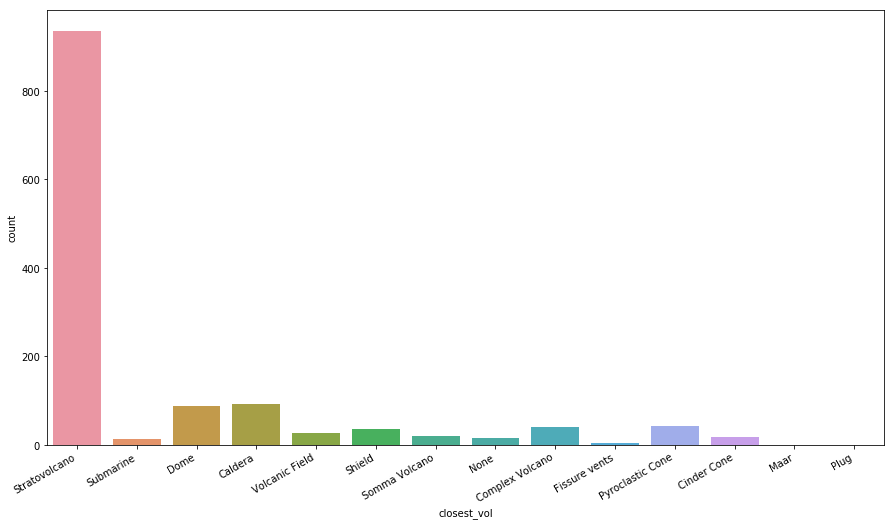

In [67]:
# At this point, we are wanting to visualize the distances between volcanoes and earthquakes. Notice here 
# how strato is way higher than the rest. This, we found, is a normalization issue. 
plt.subplots(figsize=(15, 8))
closest_vol_plot = sns.countplot(quake_vol_dist["closest_vol"])
closest_vol_plot.set_xticklabels(labels=quake_vol_dist["closest_vol"].unique(), rotation=30, ha='right')
#MRedit: using .unique for labels value will ensure the lables line up with the values

Bar chart showing the earthquakes grouped by nearest volcano. x-axis is the different types of volcanoes and y-axis is number of earthquakes. Earthquakes closest to Stratovolcanoes are most numerous. One caveat is that Stratovolcanoes are far more numerous than other volcano types and this graph may not be as informative.

In [98]:
# The count between the volcano types and the dist df do not always match up. So, you need a way to make up for 
# the missing data.
quakes_closest = dict(quake_vol_dist["closest_vol"].value_counts())
volcanoe_types = dict(volcanoes_gdf['Type'].value_counts())

type_counts = list()
for key, value in volcanoe_types.items():
    key = key.strip()
    compare = {'type': key, 'volcanoes': value, 'earthquakes': quakes_closest.get(key, 0)}
    
    type_counts.append(compare)

type_counts

[{'earthquakes': 936, 'type': 'Stratovolcano', 'volcanoes': 275},
 {'earthquakes': 92, 'type': 'Caldera', 'volcanoes': 40},
 {'earthquakes': 36, 'type': 'Shield', 'volcanoes': 34},
 {'earthquakes': 41, 'type': 'Complex Volcano', 'volcanoes': 16},
 {'earthquakes': 13, 'type': 'Submarine', 'volcanoes': 11},
 {'earthquakes': 27, 'type': 'Volcanic Field', 'volcanoes': 11},
 {'earthquakes': 0, 'type': '', 'volcanoes': 10},
 {'earthquakes': 19, 'type': 'Cinder Cone', 'volcanoes': 9},
 {'earthquakes': 89, 'type': 'Dome', 'volcanoes': 8},
 {'earthquakes': 5, 'type': 'Fissure vents', 'volcanoes': 4},
 {'earthquakes': 44, 'type': 'Pyroclastic Cone', 'volcanoes': 3},
 {'earthquakes': 1, 'type': 'Maar', 'volcanoes': 3},
 {'earthquakes': 21, 'type': 'Somma Volcano', 'volcanoes': 3},
 {'earthquakes': 0, 'type': 'Flood Basalt', 'volcanoes': 2},
 {'earthquakes': 0, 'type': 'Tuff Ring', 'volcanoes': 1},
 {'earthquakes': 1, 'type': 'Plug', 'volcanoes': 1}]

In [99]:
"""CORRECTING FOR DIFFERENCES IN NUM OF VOLCANOES"""
# distance count as shown above
type_list = [vol_type['type'] for vol_type in type_counts]

dist_count = np.array([vol_type['earthquakes'] for vol_type in type_counts])
vol_count = np.array([vol_type['volcanoes'] for vol_type in type_counts])

normalized_dist = np.divide(dist_count, vol_count)

Text(0,0.5,'normalized distance')

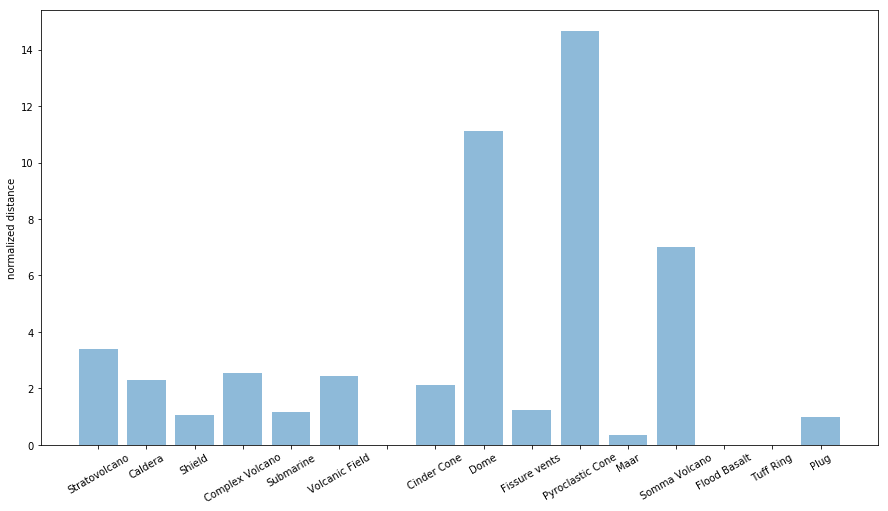

In [100]:
# Plotting out the normalized distances
# Notice the difference in the graph. Pyroclastic very obviously stands out
y_pos = np.arange(len(normalized_dist))
 
plt.figure(figsize=(15,8))
plt.bar(y_pos, normalized_dist, alpha=0.5)
plt.xticks(y_pos, type_list, rotation=30)
plt.ylabel('normalized distance')

Bar chart showing earthquakes grouped by nearest volcano and normalized for number of volcanoes. Axes are the same as previous bar chart. Normalized counts show that earthquakes are relatively much more likely to occur close to Pyroclastic Cones than most other volcano types. Earthquakes are also also relatively more likely to occur close to Dome and Somma Volcanoes. Earthquakes close to Stratovolcanoes are actually relatively comparable to most types of volcanoes.

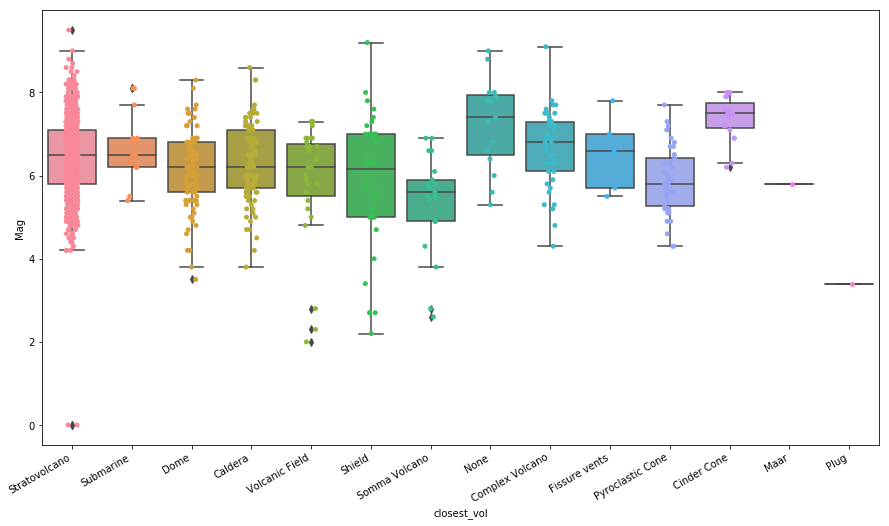

In [121]:
# Strip plot showing correlations between Magnitude and the Closest Volcano
plt.figure(figsize=(15,8))

sp = sns.stripplot(x="closest_vol", y="Mag", data=quake_vol_dist, jitter=True)
sp.set_xticklabels(labels=quake_vol_dist["closest_vol"].unique(), rotation=30, ha="right")
sns.boxplot(x="closest_vol", y="Mag", data=quake_vol_dist)

In [36]:
# Get geometry column as series per type of plate
plate_types = ["SUB", "CCB", "CRB", "CTF", "OCB", "OSR", "OTF"]

plates_to_earthquake_logic = ClosestPointLogic(
    from_df=earthquakes_gdf,
    to_df=boundaries_gdf,
    categories=plate_types,
    extra_column_name='plates'
)

In [37]:
plates_series_geometry_list = plates_to_earthquake_logic.get_geometries_from_gdf(column='STEPCLASS')

quake_plate_dist = plates_to_earthquake_logic.create_total_dist_df(
    series_geometry_list=plates_series_geometry_list
)

quake_plate_dist = plates_to_earthquake_logic.calculate_nearest(
    to_column='closest_plate',
    dist_df=quake_plate_dist
)

boundary_distances_gdf = create_gdf(df=quake_plate_dist)

POINT (141.1000061035156 38.70000076293945)
2.87796912655
POINT (43.09999847412109 40.29999923706055)
10.2164176862
POINT (-66 11)
5.51961484164
POINT (100.0999984741211 26)
14.6776777621
POINT (28.70000076293945 43.40000152587891)
8.00104201674
POINT (142.5 40.5)
1.83482369725
POINT (173 -43)
2.67404001466
POINT (141.3000030517578 40.5)
3.00886722376
POINT (48.59999847412109 40.70000076293945)
15.2904280841
POINT (33.59999847412109 40.70000076293945)
5.9830792049
POINT (-91 14)
1.15906900969
POINT (129.6000061035156 43.20000076293945)
12.1209832785
POINT (77 40)
30.2976211772
POINT (138 -35)
29.0769332117
POINT (72.30000305175781 40.79999923706055)
33.5316400884
POINT (35.29999923706055 32.20000076293945)
2.61377725821
POINT (42.65000152587891 39.13999938964844)
9.24059221888
POINT (42.70000076293945 40.90000152587891)
10.2290398461
POINT (22.96999931335449 36.36000061035156)
0.83852832951
POINT (58.20000076293945 35.20000076293945)
23.7036339365
POINT (120.5 23.5)
1.86861660059
POINT

1.45071626282
POINT (-75.84999847412109 19.77000045776367)
6.96258624074
POINT (-71.9739990234375 8.14900016784668)
4.61003162537
POINT (115 31.39999961853027)
11.1865151208
POINT (126.1689987182617 0.257999986410141)
0.181158072069
POINT (-87.89399719238281 12.36400032043457)
0.790896209336
POINT (-104.1460037231445 19.45700073242188)
1.21211298048
POINT (-103.6320037841797 19.45199966430664)
1.42796074424
POINT (-104.3789978027344 19.02799987792969)
0.731513734834
POINT (23.73200035095215 40.33300018310547)
4.26315239407
POINT (96.69000244140625 39.77099990844727)
26.4627670095
POINT (144.6219940185547 39.2239990234375)
0.426709470848
POINT (-118 33.63000106811523)
9.49299945874
POINT (27.14999961853027 36.51599884033203)
1.86993003712
POINT (104.4339981079102 -5.521999835968018)
2.41898346906
POINT (103.5410003662109 31.80999946594238)
19.7376184415
POINT (56 32.09999847412109)
21.6670079428
POINT (102.6999969482422 23.70000076293945)
14.5855956115
POINT (86.76200103759766 26.773000

1.08590423118
POINT (31.04199981689453 40.67200088500977)
5.40636243732
POINT (52.70100021362305 36.09000015258789)
18.247724082
POINT (-99.2969970703125 16.88100051879883)
0.738915890617
POINT (99.20600128173828 45.15299987792969)
31.6958971603
POINT (47.71200180053711 34.27799987792969)
13.2217260863
POINT (-72.50299835205078 -16.77899932861328)
1.31442503732
POINT (-79.48000335693359 1.054000020027161)
0.929205145238
POINT (103.9120025634766 31.57699966430664)
19.2995993099
POINT (124.3509979248047 24.4330005645752)
1.59574940555
POINT (-79.57499694824219 0.7059999704360962)
1.03997059291
POINT (-136.6649932861328 58.36999893188477)
8.91541903004
POINT (47.86899948120117 34.25899887084961)
13.3793431945
POINT (-70.11199951171875 -33.78499984741211)
2.78181227881
POINT (112.5 -9.5)
1.19820129791
POINT (122.7919998168945 24.6870002746582)
3.05201814018
POINT (159.6450042724609 53.35100173950195)
1.76376218312
POINT (-97.14499664306641 17.45000076293945)
2.0172968619
POINT (-68.8809967

0.574628585021
POINT (77.24600219726562 39.84799957275391)
30.0437228974
POINT (-77.36199951171875 -2.825000047683716)
4.18801242945
POINT (103.6719970703125 28.87899971008301)
18.2780607045
POINT (-91.13700103759766 15.79699993133545)
2.690380964
POINT (-73.39900207519531 -14.18299961090088)
2.84921320371
POINT (167.3200073242188 -15.57800006866455)
1.05466566616
POINT (122.3249969482422 22.54899978637695)
2.08542709687
POINT (-76.77999877929688 -6.809999942779541)
4.64721891921
POINT (52.78900146484375 28.40800094604492)
19.3688846224
POINT (121.5339965820312 23.60400009155273)
2.24933344896
POINT (69.68399810791016 36.25500106811523)
31.7662586537
POINT (73.32099914550781 35.94900131225586)
29.0826555767
POINT (-86.12799835205078 12.34700012207031)
1.82881428859
POINT (-102.9599990844727 18.45499992370605)
0.856401227743
POINT (100.5449981689453 31.35300064086914)
19.5693271362
POINT (122.8040008544922 13.41499996185303)
2.43304065405
POINT (-84.86000061035156 10.67300033569336)
1.6

1.43657226947
POINT (140.0619964599609 35.52500152587891)
1.47228280954
POINT (1.404000043869019 36.14300155639648)
9.32226991137
POINT (1.577000021934509 36.2130012512207)
9.13676055438
POINT (-98.23500061035156 18.17499923706055)
2.36508022351
POINT (-74.54499816894531 -13.34700012207031)
2.6369133324
POINT (88.79499816894531 27.39200019836426)
14.0631744429
POINT (15.3100004196167 40.78799819946289)
2.17396834914
POINT (15.29500007629395 40.76599884033203)
2.14801244833
POINT (50.64300155639648 34.47200012207031)
16.1460356798
POINT (50.63399887084961 34.42699813842773)
16.1379702843
POINT (139.2830047607422 -4.513000011444092)
2.90340422334
POINT (101.1679992675781 30.95599937438965)
19.4951800735
POINT (14.61400032043457 40.99499893188477)
2.23223997372
POINT (26.60700035095215 -26.625)
59.3122840286
POINT (22.97599983215332 38.15900039672852)
2.24946697251
POINT (23.17000007629395 38.09700012207031)
2.35619898133
POINT (23.29999923706055 38.19699859619141)
2.5201876095
POINT (23.

3.19819125633
POINT (-118.1350021362305 34.06100082397461)
9.09614833151
POINT (-77.96099853515625 -8.166000366210938)
2.97757320082
POINT (-118.1370010375977 34.02000045776367)
9.12293015056
POINT (-115.7559967041016 33.25699996948242)
11.4252086049
POINT (124.1490020751953 -8.258999824523926)
4.59412012008
POINT (140.3220062255859 35.42100143432617)
1.69283626785
POINT (26.69400024414062 -26.90500068664551)
59.2433259811
POINT (91.57900238037109 24.71299934387207)
11.0088649842
POINT (-118.0500030517578 34.08000183105469)
9.14511286586
POINT (121.0849990844727 12.35499954223633)
4.43585108352
POINT (121.6790008544922 23.98600006103516)
2.6545898712
POINT (95.12599945068359 25.10499954223633)
11.7933646689
POINT (160.9329986572266 -10.31999969482422)
0.506445606887
POINT (51.58499908447266 29.94400024414062)
17.7576032266
POINT (51.65499877929688 29.88599967956543)
17.8408011944
POINT (86.61799621582031 26.76300048828125)
14.1404688037
POINT (18.48900032043457 49.88600158691406)
10.88

1.44340411059
POINT (75.50499725341797 39.32600021362305)
30.5001047855
POINT (-118.5630035400391 34.16400146484375)
8.71723466689
POINT (127.7730026245117 1.042999982833862)
1.42408726065
POINT (30.08099937438965 0.5580000281333923)
33.833785623
POINT (104.254997253418 -4.999000072479248)
2.80616129413
POINT (60.53200149536133 30.78800010681152)
26.3370672247
POINT (52.63800048828125 29.14299964904785)
18.9952422905
POINT (-72.81400299072266 19.94099998474121)
6.53840006984
POINT (67.12400054931641 36.93399810791016)
32.6947030069
POINT (-4.089000225067139 35.25)
14.8643424177
POINT (112.9339981079102 -10.40900039672852)
0.40782087717
POINT (121.8499984741211 24.45499992370605)
3.15019496268
POINT (-75.97100067138672 2.907999992370605)
2.63852235386
POINT (-67.51200103759766 -13.85999965667725)
6.79993927173
POINT (52.67100143432617 29.05299949645996)
19.0536380489
POINT (-97.31199645996094 14.88700008392334)
0.480484389288
POINT (-0.08399999886751175 35.4640007019043)
10.9418319058
P

4.61871881834
POINT (121.0780029296875 24.16699981689453)
2.61114988839
POINT (102.0309982299805 -4.760000228881836)
1.304895
POINT (101.9530029296875 -4.151000022888184)
1.60684903975
POINT (33.00500106811523 40.73699951171875)
6.13688194394
POINT (101.8479995727539 -4.651000022888184)
1.23227149564
POINT (121.1809997558594 23.86800003051758)
2.35183689496
POINT (139.1710052490234 34.22200012207031)
0.72870789931
POINT (-86.06600189208984 11.92800045013428)
1.59621842132
POINT (29.3439998626709 40.85699844360352)
5.43188540312
POINT (70.94300079345703 36.24499893188477)
30.8847283191
POINT (102.2399978637695 25.72599983215332)
15.7395570938
POINT (-80.52200317382812 -1.945999979972839)
1.0567137696
POINT (30.80599975585938 -7.965000152587891)
42.3172785516
POINT (-77.81099700927734 7.091000080108643)
0.71483133241
POINT (4.837999820709229 36.4370002746582)
5.97408819402
POINT (152.2680053710938 -3.996000051498413)
1.68847762643
POINT (49.92900085449219 40.19800186157227)
16.3509833503

27.1950727565
POINT (26.75300025939941 38.15800094604492)
3.48535997973
POINT (107.7979965209961 23.60400009155273)
12.6888080951
POINT (108.2259979248047 9.972999572753906)
12.8442509085
POINT (115.6630020141602 29.7140007019043)
9.39431940345
POINT (55.83300018310547 26.7859992980957)
22.783347187
POINT (29.78899955749512 -6.245999813079834)
40.5803658675
POINT (71.12000274658203 36.28499984741211)
30.7932376025
POINT (79.20099639892578 30.45999908447266)
21.1176413458
POINT (88.38800048828125 27.38199996948242)
14.1537728035
POINT (33.58300018310547 -21.32399940490723)
55.616088086
POINT (73.88700103759766 33.12900161743164)
26.59797327
POINT (127.213996887207 -3.595000028610229)
1.75500693806
POINT (5.328000068664551 36.62300109863281)
5.45012511567
POINT (55.68500137329102 27.57399940490723)
22.3786240142
POINT (48.77999877929688 33.5)
14.3376982161
POINT (146.8630065917969 -41.16400146484375)
18.6418713395
POINT (110.4459991455078 -7.960999965667725)
2.49414025749
POINT (55.84299

2.47770289754
POINT (120.5 23.89999961853027)
0.02633810676
POINT (121 24)
0.370747260356
POINT (120.9000015258789 21.89999961853027)
0.464586900973
POINT (116 -7)
4.68127984637
POINT (114 31)
3.60088117834
POINT (125 6)
4.41957882609
POINT (104 29)
6.65677436902
POINT (-74 4)
0.219404869467
POINT (117.2429962158203 23.54000091552734)
1.89567455441
POINT (-117.4400024414062 33.8120002746582)
0.454818732271
POINT (123.5630035400391 5.652999877929688)
5.1179308997
POINT (150.2530059814453 46.8120002746582)
7.61382795886
POINT (-67.63099670410156 18.47299957275391)
2.69715898801
POINT (152.6289978027344 -5.47700023651123)
2.63589960653
POINT (122.0800018310547 23.8129997253418)
1.35650380385
POINT (-97.08000183105469 19.27000045776367)
13.8006483715
POINT (44.09999847412109 42)
4.19499629371
POINT (10.30000019073486 44.29999923706055)
5.6154737471
POINT (105.3170013427734 36.60100173950195)
8.05821340079
POINT (-68.40000152587891 -32.70000076293945)
12.3282310616
POINT (39.44499969482422 

1.20300242291
POINT (132 32)
3.28804638045
POINT (120.390998840332 23.25099945068359)
0.0179509571671
POINT (99.14499664306641 21.07600021362305)
3.20536841496
POINT (100.3000030517578 23.10000038146973)
4.60603005073
POINT (-79.90200042724609 0.01200000010430813)
1.64937309339
POINT (-90.91300201416016 13.77999973297119)
5.54592330343
POINT (-74.91999816894531 -14.97500038146973)
3.90109938898
POINT (20.39999961853027 41.70000076293945)
3.58694220475
POINT (36.45000076293945 40.67100143432617)
3.09279073073
POINT (30.5 40.79999923706055)
7.15106277479
POINT (-101.5 17.75)
16.6450331631
POINT (-72 -30.75)
12.6296852296
POINT (30.5 40.59999847412109)
7.05810840298
POINT (110 -9.5)
11.0505375887
POINT (134 35.25)
4.03595800275
POINT (34 41)
4.55615012922
POINT (121.5 22.89999961853027)
1.12183852018
POINT (-68.75 -31.25)
11.1689726027
POINT (32.5 41.5)
5.93552895705
POINT (84 44)
14.2491432023
POINT (54.5 36.79999923706055)
7.52371620291
POINT (26.70000076293945 39.40000152587891)
6.5453

6.82426254983
POINT (21.17600059509277 38.87400054931641)
1.17273991059
POINT (-70.65499877929688 -25.50200080871582)
8.22447842286
POINT (-74.79900360107422 2.888999938964844)
0.0284725744377
POINT (112.9459991455078 -9.168000221252441)
8.25641607858
POINT (116.6009979248047 38.51599884033203)
1.68413342159
POINT (96.23200225830078 5.084000110626221)
9.31930023224
POINT (21.29100036621094 39.55199813842773)
1.75586029879
POINT (30.73999977111816 40.63199996948242)
6.86012088611
POINT (40.40800094604492 39.50199890136719)
0.674093567335
POINT (-73.072998046875 6.788000106811523)
1.05123211148
POINT (-67.30999755859375 10.55500030517578)
2.0338473313
POINT (100.2320022583008 31.63100051879883)
4.57228353312
POINT (122.2210006713867 24.4640007019043)
1.01685667092
POINT (20.45599937438965 41.37900161743164)
3.26863615915
POINT (73.77400207519531 17.39399909973145)
10.4966645786
POINT (-69.947998046875 -21.86400032043457)
6.42218033896
POINT (13 38)
1.6962962595
POINT (24.94599914550781 3

8.1268653426
POINT (13.18099975585938 46.3390007019043)
7.69040807001
POINT (13.20600032806396 46.31399917602539)
7.66147842792
POINT (13.08699989318848 46.35400009155273)
7.72199790821
POINT (-78.73200225830078 -0.7260000109672546)
0.286269531089
POINT (139.9909973144531 -4.474999904632568)
0.481583209496
POINT (101.0210037231445 27.55400085449219)
3.55308741539
POINT (59.18000030517578 33.81999969482422)
6.91450529163
POINT (44.03099822998047 39.08200073242188)
1.6236903334
POINT (-68.89600372314453 -20.47200012207031)
4.83626766021
POINT (26.67700004577637 -27.97900009155273)
1.21370598959
POINT (101.0240020751953 27.33600044250488)
3.57180338519
POINT (91.01399993896484 38.18500137329102)
10.9443060692
POINT (26.70199966430664 45.7760009765625)
9.9953655087
POINT (122.2850036621094 16.7549991607666)
5.21009017304
POINT (56.36299896240234 27.58300018310547)
0.223215598129
POINT (40.05699920654297 38.64699935913086)
0.160864300901
POINT (50.64300155639648 31.95400047302246)
1.5649267

1.3834466454
POINT (-116 47.5)
11.0684586551
POINT (70.44599914550781 34.56399917602539)
1.42565911558
POINT (70.83999633789062 36.44699859619141)
2.39507680513
POINT (138.8710021972656 29.37199974060059)
5.44361857112
POINT (10.19400024414062 43.61600112915039)
4.93424898523
POINT (13.88899993896484 41.73799896240234)
3.03798418474
POINT (13.90100002288818 41.75500106811523)
3.05219189424
POINT (17.82900047302246 42.9739990234375)
5.1323700444
POINT (121.6019973754883 32.60400009155273)
2.8763121479
POINT (-80.80000305175781 46.58000183105469)
28.4583937077
POINT (-69.37100219726562 17.98100090026855)
1.91950099082
POINT (-69.23300170898438 18.03899955749512)
1.91394697259
POINT (137.4660034179688 35.80099868774414)
0.652927223445
POINT (-115.9869995117188 47.45999908447266)
11.0524312774
POINT (42.24100112915039 40.89199829101562)
2.37698753908
POINT (42.44699859619141 40.71099853515625)
2.3422799908
POINT (92.86399841308594 24.68400001525879)
2.40431524707
POINT (-68.59300231933594 

4.58114136037
POINT (70.77500152587891 36.44800186157227)
2.44020766246
POINT (121.1800003051758 15.7209997177124)
5.83790980101
POINT (-78.48300170898438 -0.1720000058412552)
0.288571553922
POINT (26.83699989318848 -28.09000015258789)
1.34378768857
POINT (27.34900093078613 -26.38999938964844)
0.0369363821097
POINT (103.7180023193359 37.09600067138672)
9.27486482304
POINT (70.42900085449219 35.09000015258789)
1.78211971964
POINT (55.45700073242188 28.24200057983398)
1.23159338829
POINT (97.40499877929688 3.938999891281128)
10.4783284465
POINT (15.40200042724609 37.2859992980957)
1.03129365663
POINT (121.6449966430664 23.88299942016602)
0.976315710041
POINT (22.34600067138672 40.97700119018555)
3.52861865099
POINT (-84.22899627685547 9.982000350952148)
0.489514186104
POINT (95.88999938964844 23.55900001525879)
1.87820874545
POINT (70.40299987792969 35.94400024414062)
2.37030514949
POINT (6.760000228881836 44.8849983215332)
7.00670599397
POINT (113.9889984130859 39.94699859619141)
1.4774

6.56391030403
POINT (35.90200042724609 36.19900131225586)
0.540460012647
POINT (57.30500030517578 37.7239990234375)
10.2463978642
POINT (68.16500091552734 29.97900009155273)
0.0360294252916
POINT (48.06900024414062 38.10800170898438)
4.17306918577
POINT (76.81700134277344 39.45000076293945)
6.45839782076
POINT (71.52300262451172 34.79000091552734)
0.765640419023
POINT (76.83000183105469 39.52500152587891)
6.5232799956
POINT (76.89199829101562 39.5359992980957)
6.57250293082
POINT (59.81000137329102 33.84799957275391)
7.17477779913
POINT (59.88000106811523 33.39899826049805)
6.79820669033
POINT (70.96800231933594 36.46699905395508)
2.32578926525
POINT (80.08300018310547 23.07200050354004)
5.48546112524
POINT (-7.230999946594238 42.83000183105469)
8.00581252041
POINT (-63.53200149536133 10.44999980926514)
5.77437863609
POINT (26.61899948120117 -26.85700035095215)
0.0919240915382
POINT (12.7810001373291 43.07799911499023)
4.64814477936
POINT (119.6579971313477 -3.773000001907349)
0.214236

3.65998956007
POINT (134.2299957275391 -1.700000047683716)
3.06692498575
POINT (29.01300048828125 -1.962000012397766)
20.0861840418
POINT (14.85200023651123 41.73799896240234)
2.99215089698
POINT (74.62699890136719 35.39300155639648)
1.97295815261
POINT (96.08799743652344 2.836999893188477)
11.5696429279
POINT (74.59500122070312 35.34799957275391)
1.91811674253
POINT (74.55599975585938 35.33700180053711)
1.88380577837
POINT (97.39099884033203 39.75400161743164)
11.6592687999
POINT (-90.84999847412109 13.6230001449585)
5.3977158279
POINT (-104.0630035400391 18.89999961853027)
19.4515954793
POINT (39.85100173950195 39.50299835205078)
0.798476982806
POINT (77.20400238037109 39.51499938964844)
6.76330001869
POINT (77.35800170898438 39.40200042724609)
6.7809854386
POINT (120.6060028076172 -8.33899974822998)
2.21704393395
POINT (70.55000305175781 35.90700149536133)
2.23648183665
POINT (40.45800018310547 38.97000122070312)
0.142208148395
POINT (77.14199829101562 39.30500030517578)
6.565021273

6.64900180092
POINT (-73.76399993896484 4.329999923706055)
0.236190291984
POINT (105.4229965209961 32.56000137329102)
9.23304446597
POINT (-0.6579999923706055 35.88299942016602)
0.0900533071743
POINT (21.52499961853027 37.9630012512207)
1.23212445426
POINT (140.8809967041016 39.02999877929688)
3.08011022233
POINT (105.5540008544922 32.76100158691406)
9.44574766078
POINT (27.78499984741211 35.98300170898438)
7.70332768949
POINT (97.90000152587891 25.10000038146973)
2.63712804468
POINT (101.9000015258789 26)
4.74477170328
POINT (73.76799774169922 39.51499938964844)
5.00713073407
POINT (90.302001953125 29.75900077819824)
2.81555433836
POINT (67.48400115966797 30.56900024414062)
0.60723174117
POINT (-84.02809906005859 10.39620018005371)
0.0295416685401
POINT (13.33399963378906 42.33399963378906)
3.75901040837
POINT (101.0859985351562 25.61899948120117)
4.17218235106
POINT (138.2760009765625 34.77799987792969)
0.471461843668
POINT (107.3280029296875 -7.777999877929688)
12.8169981028
POINT (

13.6823606459
POINT (124.8560028076172 6.97700023651123)
5.68933898691
POINT (-64.38099670410156 9.49899959564209)
1.20874352185
POINT (57.69300079345703 37.95700073242188)
13.3867346129
POINT (37.90000152587891 40.20000076293945)
3.75463256139
POINT (-67.59799957275391 -34.76800155639648)
13.2679157277
POINT (172.2920074462891 -41.83100128173828)
4.2151687118
POINT (58 37.5)
12.8479153562
POINT (-68.73699951171875 -23.03800010681152)
1.53735558293
POINT (-56.00799942016602 44.53900146484375)
34.4949612332
POINT (96.54299926757812 17.66500091552734)
3.53622714429
POINT (44.68500137329102 38.15200042724609)
8.34110716807
POINT (103 26.79999923706055)
2.17671635764
POINT (15.36699962615967 41.04999923706055)
2.76441332034
POINT (13.5 43.75)
5.85565726456
POINT (19.5 40.5)
2.23490715691
POINT (139.1029968261719 34.97700119018555)
7.78086894088
POINT (19.60000038146973 40.29999923706055)
2.01141904401
POINT (96.4219970703125 17.97200012207031)
3.84385371897
POINT (120.5999984741211 23.2000

3.88499789381
POINT (35.5 36.5)
0.916032999115
POINT (160.0570068359375 52.75500106811523)
15.9599066578
POINT (-73.40000152587891 18.39999961853027)
5.78110590471
POINT (55.09999847412109 35.40000152587891)
13.9279426651
POINT (27.62100028991699 40.11999893188477)
0.516624576309
POINT (-72.91999816894531 -37.25400161743164)
16.0111436348
POINT (20.76600074768066 38.04600143432617)
0.40903293435
POINT (32.5 35)
3.9527005958
POINT (178.1999969482422 -18.29999923706055)
5.42501256383
POINT (-80.84700012207031 -3.596999883651733)
10.955181033
POINT (101.2119979858398 38.87599945068359)
7.66517575742
POINT (22.23900032043457 39.1870002746582)
0.835102725489
POINT (123.9000015258789 13)
9.79957725723
POINT (52 27.5)
15.2621189224
POINT (1.600000023841858 36.20000076293945)
7.79371249958
POINT (122.8779983520508 7.386000156402588)
7.28288704722
POINT (101.6129989624023 29.98100090026855)
3.9178682745
POINT (74.63999938964844 39.81600189208984)
9.19394568026
POINT (-71.59999847412109 -29.8999

6.61685975513
POINT (19.33600044250488 -33.18999862670898)
8.81524547789
POINT (-75.19499969482422 -11.83500003814697)
1.89524533541
POINT (-122.7639999389648 38.29999923706055)
8.74008582629
POINT (17.35300064086914 44.80699920654297)
6.72992212951
POINT (17.23399925231934 44.83700180053711)
6.72974666379
POINT (102.4619979858398 24.14699935913086)
3.6509462878
POINT (143.0240020751953 42.52299880981445)
11.5284170186
POINT (122.0579986572266 12.60000038146973)
9.13914758288
POINT (29.54999923706055 39.17200088500977)
1.66013941354
POINT (121.6589965820312 15.77200031280518)
6.23575977425
POINT (47.08000183105469 43.07899856567383)
12.3679754874
POINT (47.07099914550781 43.10200119018555)
12.3720817183
POINT (-78.83999633789062 -9.248000144958496)
6.35207315473
POINT (78.71900177001953 42.49200057983398)
13.7459453418
POINT (55.88700103759766 37.83599853515625)
14.6524307643
POINT (-72.56300354003906 -1.485999941825867)
11.022954107
POINT (145.4709930419922 -4.907000064849854)
0.54963

9.24320683843
POINT (-76.19000244140625 4.793000221252441)
5.20556143771
POINT (59.75400161743164 34.05599975585938)
9.27919490616
POINT (-79.36299896240234 1.603000044822693)
5.92783842838
POINT (102.5670013427734 -3.33899998664856)
7.74269949723
POINT (115.7529983520508 -8.487000465393066)
8.41712081511
POINT (-27.75099945068359 38.72600173950195)
22.0423529345
POINT (-121.7279968261719 37.71200180053711)
7.5582288497
POINT (16.15200042724609 39.29100036621094)
1.11679638472
POINT (-114.9079971313477 32.26800155639648)
0.389811473189
POINT (23.00799942016602 39.25699996948242)
1.02525929108
POINT (50.26200103759766 37.32199859619141)
13.8086967874
POINT (81.10299682617188 29.62299919128418)
10.9328243101
POINT (-88.48999786376953 15.91199970245361)
0.0360061248515
POINT (-80.00199890136719 -1.986999988555908)
9.37766231554
POINT (75.69300079345703 32.92200088500977)
5.76270712554
POINT (75.7760009765625 32.89300155639648)
5.83173298867
POINT (139.7400054931641 35.99700164794922)
8.84

2.57846966955
POINT (-115.7559967041016 33.25699996948242)
0.120938796399
POINT (124.1490020751953 -8.258999824523926)
5.75080946711
POINT (140.3220062255859 35.42100143432617)
9.06585998206
POINT (26.69400024414062 -26.90500068664551)
1.28589357579
POINT (91.57900238037109 24.71299934387207)
11.6733369123
POINT (-118.0500030517578 34.08000183105469)
2.51900907472
POINT (121.0849990844727 12.35499954223633)
8.96370837101
POINT (121.6790008544922 23.98600006103516)
0.712629701651
POINT (95.12599945068359 25.10499954223633)
10.2001665831
POINT (160.9329986572266 -10.31999969482422)
7.82741374318
POINT (51.58499908447266 29.94400024414062)
15.7149195141
POINT (51.65499877929688 29.88599967956543)
15.6402119937
POINT (86.61799621582031 26.76300048828125)
15.9323445732
POINT (18.48900032043457 49.88600158691406)
11.3909710343
POINT (146.2259979248047 -6.061999797821045)
1.49182961257
POINT (-90.50099945068359 13.90799999237061)
0.0550640571528
POINT (99.68099975585938 22.90900039672852)
6.1

0.568242540881
POINT (118.7190017700195 22.55500030517578)
1.25360601113
POINT (147.3529968261719 43.86299896240234)
11.3098501195
POINT (127.9800033569336 -1.205999970436096)
2.57124594221
POINT (121.0589981079102 13.54300022125244)
7.85603836127
POINT (143.4299926757812 40.52299880981445)
13.5505203667
POINT (135.0249938964844 34.58000183105469)
4.30733343635
POINT (-72.93599700927734 5.044000148773193)
7.15419093506
POINT (-109.7850036621094 41.48799896240234)
10.0919107367
POINT (-76.58899688720703 4.052000045776367)
5.30126383088
POINT (121.7060012817383 24.23299980163574)
0.476366998772
POINT (32.26900100708008 35.06000137329102)
3.71523948568
POINT (-77.30699920654297 1.281999945640564)
7.00052220754
POINT (-79.50900268554688 -2.132999897003174)
9.57625695127
POINT (21.7180004119873 40.14400100708008)
1.72836008472
POINT (125.0390014648438 -8.461999893188477)
4.84427145938
POINT (122.9440002441406 -8.288000106811523)
5.98161237632
POINT (142.822998046875 52.60400009155273)
1.489

2.47707236194
POINT (69.84400177001953 38.64400100708008)
6.73171435894
POINT (142.4470062255859 -3.263999938964844)
1.31073105069
POINT (28.99600028991699 -1.769999980926514)
0.136728034508
POINT (27.88699913024902 38.63299942016602)
0.245460093326
POINT (26.64500045776367 35.62400054931641)
2.21559989711
POINT (31.22699928283691 38.52700042724609)
2.12289485798
POINT (51.79199981689453 28.0890007019043)
15.2993194095
POINT (70.50299835205078 36.50799942016602)
4.62911857942
POINT (124.2180023193359 6.027999877929688)
5.37544362525
POINT (69.20999908447266 36.05099868774414)
4.20224445744
POINT (69.24800109863281 36.05300140380859)
4.19776679898
POINT (122.1419982910156 24.29999923706055)
0.560337208133
POINT (147.5449981689453 -6.230999946594238)
2.57551046185
POINT (69.29599761962891 35.98799896240234)
4.12588604048
POINT (-76.5780029296875 -12.42800045013428)
2.58368158317
POINT (21.53300094604492 42.41999816894531)
3.51510329376
POINT (47.4010009765625 34.60200119018555)
11.079503

1.02669704454
POINT (28.89999961853027 -2.296000003814697)
0.0236405030336
POINT (87.11100006103516 23.4330005645752)
13.0236333574
POINT (28.91799926757812 -2.404000043869019)
0.044973293967
POINT (95.96399688720703 2.767999887466431)
0.751469362297
POINT (103.3219985961914 31.00200080871582)
3.03428449707
POINT (-73.76399993896484 4.329999923706055)
7.57925822992
POINT (105.4229965209961 32.56000137329102)
3.31520809233
POINT (-0.6579999923706055 35.88299942016602)
5.51657826991
POINT (21.52499961853027 37.9630012512207)
0.459872986892
POINT (140.8809967041016 39.02999877929688)
11.6011205172
POINT (105.5540008544922 32.76100158691406)
3.43271787005
POINT (27.78499984741211 35.98300170898438)
1.05487390048
POINT (97.90000152587891 25.10000038146973)
7.55183462703
POINT (101.9000015258789 26)
3.46581232444
POINT (73.76799774169922 39.51499938964844)
8.51050253744
POINT (90.302001953125 29.75900077819824)
14.7603423653
POINT (67.48400115966797 30.56900024414062)
2.01085890617
POINT (-8

0.695690661863
POINT (58 37.5)
10.5339134703
POINT (-68.73699951171875 -23.03800010681152)
2.03004202481
POINT (-56.00799942016602 44.53900146484375)
28.2298137849
POINT (96.54299926757812 17.66500091552734)
1.02360723062
POINT (44.68500137329102 38.15200042724609)
1.24625187146
POINT (103 26.79999923706055)
5.60209303532
POINT (15.36699962615967 41.04999923706055)
3.43507623517
POINT (13.5 43.75)
6.40613463799
POINT (19.5 40.5)
2.23490715691
POINT (139.1029968261719 34.97700119018555)
0.136127673457
POINT (19.60000038146973 40.29999923706055)
2.01141904401
POINT (96.4219970703125 17.97200012207031)
1.32886741456
POINT (120.5999984741211 23.20000076293945)
1.35317531154
POINT (-66.30000305175781 -24.70000076293945)
4.9388891384
POINT (133 35.09999847412109)
4.85753053597
POINT (-96.61399841308594 16.05299949645996)
8.89320285279
POINT (176.0249938964844 -39.77199935913086)
0.0941385141278
POINT (102.4580001831055 -5.433000087738037)
11.6726095594
POINT (22.66600036621094 41.33700180053

1.05695560486
POINT (29.60000038146973 32.20000076293945)
5.24466112273
POINT (-84.5 10)
5.45209280919
POINT (101.6999969482422 26.60000038146973)
4.37021948505
POINT (19.29999923706055 47.5)
8.92163298812
POINT (30.5 40)
0.660512679666
POINT (35.5 35.5)
0.00271356458589
POINT (67.47899627685547 35.04199981689453)
4.90022001702
POINT (26.02599906921387 36.61700057983398)
2.3214416623
POINT (95.802001953125 21.9689998626709)
0.115998046875
POINT (70 23)
3.82515581382
POINT (140.3099975585938 35.64199829101562)
1.17799746409
POINT (54.40499877929688 27.28300094604492)
2.69020830277
POINT (8.899999618530273 36.20000076293945)
6.57458958419
POINT (121.5169982910156 23.91699981689453)
0.427655257527
POINT (22.60700035095215 39.26699829101562)
0.676104534372
POINT (28.60899925231934 36.38700103759766)
0.950761083988
POINT (31.04199981689453 40.67200088500977)
0.059895350149
POINT (52.70100021362305 36.09000015258789)
6.71631466577
POINT (-99.2969970703125 16.88100051879883)
11.5911306108
POI

0.687724513562
POINT (77.24600219726562 39.84799957275391)
7.81846035734
POINT (-77.36199951171875 -2.825000047683716)
2.16398616415
POINT (103.6719970703125 28.87899971008301)
6.31171078104
POINT (-91.13700103759766 15.79699993133545)
3.44405562485
POINT (-73.39900207519531 -14.18299961090088)
1.70159724912
POINT (167.3200073242188 -15.57800006866455)
12.2943912781
POINT (122.3249969482422 22.54899978637695)
1.79124241698
POINT (-76.77999877929688 -6.809999942779541)
5.11862668465
POINT (52.78900146484375 28.40800094604492)
1.91012590965
POINT (121.5339965820312 23.60400009155273)
0.695577138508
POINT (69.68399810791016 36.25500106811523)
5.280292642
POINT (73.32099914550781 35.94900131225586)
4.43609399034
POINT (-86.12799835205078 12.34700012207031)
4.19701343775
POINT (-102.9599990844727 18.45499992370605)
13.4587235508
POINT (100.5449981689453 31.35300064086914)
4.77276339475
POINT (122.8040008544922 13.41499996185303)
2.34559467884
POINT (-84.86000061035156 10.67300033569336)
6.1

3.45793179686
POINT (26.60700035095215 -26.625)
0.143422479832
POINT (22.97599983215332 38.15900039672852)
0.268489030222
POINT (23.17000007629395 38.09700012207031)
0.463259949293
POINT (23.29999923706055 38.19699859619141)
0.512949935845
POINT (23.33499908447266 38.18099975585938)
0.550814695867
POINT (20.8129997253418 39.38199996948242)
0.985543879213
POINT (-74.37300109863281 -13.11600017547607)
1.26676897495
POINT (57.68600082397461 29.85799980163574)
3.38490839305
POINT (67.83599853515625 36.19800186157227)
5.72913382862
POINT (-70.38400268554688 -20.27599906921387)
1.26564766348
POINT (-74.46299743652344 -13.1850004196167)
1.37924489873
POINT (57.76699829101562 29.97599983215332)
3.5174397222
POINT (73.59700012207031 35.68500137329102)
4.0669532939
POINT (-73.03299713134766 -33.17800140380859)
11.6827931013
POINT (-72.50099945068359 8.111000061035156)
0.382664429094
POINT (-102.0090026855469 18.11499977111816)
14.37140888
POINT (67.08000183105469 29.91200065612793)
0.25005868153

4.49191929594
POINT (-118.0500030517578 34.08000183105469)
1.3905224281
POINT (121.0849990844727 12.35499954223633)
3.44178076695
POINT (121.6790008544922 23.98600006103516)
0.286985707424
POINT (95.12599945068359 25.10499954223633)
1.12712403494
POINT (160.9329986572266 -10.31999969482422)
7.050791841
POINT (51.58499908447266 29.94400024414062)
0.642447828166
POINT (51.65499877929688 29.88599967956543)
0.672656184579
POINT (86.61799621582031 26.76300048828125)
9.76950173353
POINT (18.48900032043457 49.88600158691406)
11.3909710343
POINT (146.2259979248047 -6.061999797821045)
0.780921178011
POINT (-90.50099945068359 13.90799999237061)
3.6341340074
POINT (99.68099975585938 22.90900039672852)
3.76840094301
POINT (99.41100311279297 23.18600082397461)
3.47705429729
POINT (44.11800003051758 40.91899871826172)
3.61906140816
POINT (68.69899749755859 38.46099853515625)
7.61626496137
POINT (139.8600006103516 36.03799819946289)
1.20018710069
POINT (34.47299957275391 -13.68299961090088)
7.7813041

3.69762481616
POINT (104.254997253418 -4.999000072479248)
12.3325890293
POINT (60.53200149536133 30.78800010681152)
5.52581763123
POINT (52.63800048828125 29.14299964904785)
1.62081451354
POINT (-72.81400299072266 19.94099998474121)
0.550565589713
POINT (67.12400054931641 36.93399810791016)
6.70545405802
POINT (-4.089000225067139 35.25)
2.02923140893
POINT (112.9339981079102 -10.40900039672852)
7.80298725872
POINT (121.8499984741211 24.45499992370605)
0.148915802179
POINT (-75.97100067138672 2.907999992370605)
1.29012555829
POINT (-67.51200103759766 -13.85999965667725)
4.76998003912
POINT (52.67100143432617 29.05299949645996)
1.66400948827
POINT (-97.31199645996094 14.88700008392334)
9.68552264363
POINT (-0.08399999886751175 35.4640007019043)
5.90357544556
POINT (27.40500068664551 -26.44700050354004)
0.870357850381
POINT (118.7190017700195 22.55500030517578)
0.505895350196
POINT (147.3529968261719 43.86299896240234)
11.3098501195
POINT (127.9800033569336 -1.205999970436096)
0.622526653

0.67240129222
POINT (102.0309982299805 -4.760000228881836)
10.8761434784
POINT (101.9530029296875 -4.151000022888184)
10.3131495171
POINT (33.00500106811523 40.73699951171875)
0.219926065464
POINT (101.8479995727539 -4.651000022888184)
10.6904621936
POINT (121.1809997558594 23.86800003051758)
0.712301388719
POINT (139.1710052490234 34.22200012207031)
0.688189752735
POINT (-86.06600189208984 11.92800045013428)
4.6163086969
POINT (29.3439998626709 40.85699844360352)
0.143198750629
POINT (70.94300079345703 36.24499893188477)
5.28359119305
POINT (102.2399978637695 25.72599983215332)
5.12312800925
POINT (-80.52200317382812 -1.945999979972839)
0.966767729037
POINT (30.80599975585938 -7.965000152587891)
12.2045986644
POINT (-77.81099700927734 7.091000080108643)
0.573075432302
POINT (4.837999820709229 36.4370002746582)
10.5718363173
POINT (152.2680053710938 -3.996000051498413)
0.168229341685
POINT (49.92900085449219 40.19800186157227)
6.64758883744
POINT (49.9119987487793 40.1609992980957)
6.6

3.78650893037
POINT (146.8459930419922 -6.355000019073486)
1.466257604
POINT (-69.197998046875 -20.00699996948242)
1.72497781613
POINT (27.43499946594238 -26.4680004119873)
0.891021804817
POINT (125.0299987792969 46.88399887084961)
10.0604462611
POINT (-76.41400146484375 -5.721000194549561)
4.47893762314
POINT (73.58399963378906 34.46500015258789)
3.0907052959
POINT (73.92900085449219 33.97700119018555)
2.49909208958
POINT (26.75300025939941 38.15800094604492)
1.57684050162
POINT (107.7979965209961 23.60400009155273)
0.17858771889
POINT (108.2259979248047 9.972999572753906)
8.13768469292
POINT (115.6630020141602 29.7140007019043)
3.72887009969
POINT (55.83300018310547 26.7859992980957)
1.18379104459
POINT (29.78899955749512 -6.245999813079834)
10.5031653174
POINT (71.12000274658203 36.28499984741211)
5.34891466786
POINT (79.20099639892578 30.45999908447266)
3.67142303359
POINT (88.38800048828125 27.38199996948242)
8.23421056622
POINT (33.58300018310547 -21.32399940490723)
0.47342285223

12.5066567875
POINT (13.5 42)
5.28209238844
POINT (143.6000061035156 42.09999847412109)
4.77709242295
POINT (-115.5 32.79999923706055)
12.9058022755
POINT (-89 14)
8.64412239617
POINT (91.5 29.5)
15.1501731013
POINT (120.5 23.89999961853027)
2.01743644359
POINT (121 24)
1.542870701
POINT (120.9000015258789 21.89999961853027)
2.36669525794
POINT (116 -7)
4.61499653304
POINT (114 31)
11.2424396818
POINT (125 6)
4.10561810206
POINT (104 29)
18.5872737377
POINT (-74 4)
6.11973463477
POINT (117.2429962158203 23.54000091552734)
5.25901251243
POINT (-117.4400024414062 33.8120002746582)
14.8405142361
POINT (123.5630035400391 5.652999877929688)
4.67821608785
POINT (150.2530059814453 46.8120002746582)
11.9442206134
POINT (-67.63099670410156 18.47299957275391)
3.36361086566
POINT (152.6289978027344 -5.47700023651123)
2.12606206864
POINT (122.0800018310547 23.8129997253418)
0.454025731508
POINT (-97.08000183105469 19.27000045776367)
8.18278214036
POINT (44.09999847412109 42)
22.2893722412
POINT (1

13.6477616278
POINT (43.79999923706055 41.70000076293945)
22.2418776353
POINT (-115.6969985961914 33.22200012207031)
13.3677857847
POINT (-77.62899780273438 -11.11900043487549)
18.4392291702
POINT (102.5 24.39999961853027)
14.1414474987
POINT (139.8289947509766 44.50799942016602)
1.26998409811
POINT (26.65500068664551 45.77299880981445)
10.300945527
POINT (43.5 16.39999961853027)
13.4419309003
POINT (58.59999847412109 33.5)
9.08950332286
POINT (-102.9570007324219 18.67700004577637)
2.29157623433
POINT (127.1999969482422 47)
11.694153387
POINT (99.40799713134766 23.51399993896484)
11.4386511595
POINT (92.47799682617188 12.14900016784668)
1.61878129214
POINT (43.29999923706055 39.5)
20.9258762104
POINT (102.3000030517578 31.70000076293945)
19.8884647757
POINT (39.40000152587891 39.70000076293945)
19.4825903293
POINT (132 32)
8.37462226014
POINT (120.390998840332 23.25099945068359)
2.1461056182
POINT (99.14499664306641 21.07600021362305)
9.4187688346
POINT (100.3000030517578 23.1000003814

2.33905143655
POINT (138.2779998779297 34.84199905395508)
1.65005035
POINT (-122.3349990844727 47.31700134277344)
28.8948922141
POINT (22.42600059509277 38.39099884033203)
2.4736141104
POINT (-95.84600067138672 16.17799949645996)
9.74965881346
POINT (87.75499725341797 43.84000015258789)
29.8384419021
POINT (21.75699996948242 39.04399871826172)
2.0922576277
POINT (103.1709976196289 26.15999984741211)
15.8802341823
POINT (114.9629974365234 37.38800048828125)
15.6763044456
POINT (122.6949996948242 24.30699920654297)
0.691759226813
POINT (29.87299919128418 0.8420000076293945)
29.4317677821
POINT (114.9909973144531 37.55099868774414)
15.8060927441
POINT (69.12999725341797 41.15999984741211)
17.2721643214
POINT (80.85399627685547 29.55400085449219)
16.6496772039
POINT (68.62899780273438 30.05100059509277)
6.71600721578
POINT (78.89199829101562 28.61599922180176)
14.4961097548
POINT (41.58000183105469 39.1609992980957)
21.6163476626
POINT (100.088996887207 27.45700073242188)
15.1075638344
POI

4.82866657378
POINT (122.9599990844727 7.258999824523926)
6.28023235548
POINT (29.01499938964844 37.74300003051758)
9.01650924612
POINT (104.181999206543 32.48099899291992)
20.339518585
POINT (13.18099975585938 46.3390007019043)
8.61588152178
POINT (13.20600032806396 46.31399917602539)
8.58121419776
POINT (13.08699989318848 46.35400009155273)
8.68078264654
POINT (-78.73200225830078 -0.7260000109672546)
8.00426125987
POINT (139.9909973144531 -4.474999904632568)
2.87411912974
POINT (101.0210037231445 27.55400085449219)
15.6769576714
POINT (59.18000030517578 33.81999969482422)
9.45968458554
POINT (44.03099822998047 39.08200073242188)
20.1188466941
POINT (-68.89600372314453 -20.47200012207031)
29.8487732276
POINT (26.67700004577637 -27.97900009155273)
9.19591448653
POINT (101.0240020751953 27.33600044250488)
15.4959155835
POINT (91.01399993896484 38.18500137329102)
23.848410336
POINT (26.70199966430664 45.7760009765625)
10.3341993204
POINT (122.2850036621094 16.7549991607666)
6.75303094611

2.37948898749
POINT (-69.23300170898438 18.03899955749512)
2.40761333537
POINT (137.4660034179688 35.80099868774414)
2.68711245553
POINT (-115.9869995117188 47.45999908447266)
26.606239794
POINT (42.24100112915039 40.89199829101562)
22.4402846913
POINT (42.44699859619141 40.71099853515625)
22.3907580161
POINT (92.86399841308594 24.68400001525879)
10.3058434013
POINT (-68.59300231933594 -33.10900115966797)
25.1660691569
POINT (52.97200012207031 28.35199928283691)
6.23697636734
POINT (-71.76200103759766 -33.13199996948242)
25.8346854121
POINT (14.26299953460693 41.63100051879883)
4.44120884384
POINT (-71.68000030517578 -32.71200180053711)
26.216347789
POINT (123.5120010375977 7.776000022888184)
6.38549084064
POINT (-63.59999847412109 -18.5669994354248)
30.6220920545
POINT (104.9530029296875 29.35000038146973)
18.4526977576
POINT (-71.53500366210938 -34.13399887084961)
24.8090599071
POINT (102.8850021362305 25.89100074768066)
15.4889165052
POINT (120.8119964599609 16.54100036621094)
7.268

22.891821072
POINT (43.24499893188477 42.68000030517578)
23.3531321302
POINT (-82.44000244140625 9.546999931335449)
0.792722412798
POINT (116.6520004272461 5.857999801635742)
10.4682934795
POINT (44.01100158691406 42.40599822998047)
22.6647149231
POINT (120.3160018920898 15.16499996185303)
8.73006543154
POINT (-89.63300323486328 13.40799999237061)
8.90942133707
POINT (-118.0110015869141 34.23699951171875)
15.5236684738
POINT (124.5869979858398 -8.145999908447266)
0.441575103636
POINT (20.98100090026855 45.39300155639648)
6.91752808526
POINT (-71.72100067138672 -15.70699977874756)
24.3805131086
POINT (44.06100082397461 36.59799957275391)
18.368027464
POINT (-90.93199920654297 14.60400009155273)
10.6163491946
POINT (78.77500152587891 30.72500038146973)
15.1398053089
POINT (-77.35600280761719 4.552000045776367)
3.87772878283
POINT (44.06800079345703 13.88700008392334)
12.6980572058
POINT (49.58200073242188 36.82600021362305)
14.8795558471
POINT (27.43000030517578 -26.42000007629395)
9.830

13.5237382759
POINT (57.58499908447266 30.12599945068359)
5.68836463395
POINT (12.91899967193604 43.2239990234375)
6.46889421691
POINT (60.0629997253418 32.44699859619141)
8.14889454089
POINT (13.65299987792969 46.27099990844727)
8.30508577627
POINT (-65.4010009765625 -17.78300094604492)
29.0051698003
POINT (70.07499694824219 37.18500137329102)
13.7618684182
POINT (35.32500076293945 36.90299987792969)
15.3579189225
POINT (-28.56599998474121 38.62099838256836)
1.76956035146
POINT (48.52500152587891 38.72600173950195)
17.0477083295
POINT (120.7109985351562 23.50300025939941)
1.79546795335
POINT (142.5200042724609 -2.946000099182129)
0.372944220378
POINT (-71.24400329589844 -32.32699966430664)
26.474829818
POINT (-80.31300354003906 -0.593999981880188)
7.72725683319
POINT (77.29799652099609 39.57199859619141)
19.5266195737
POINT (15.97500038146973 40)
2.15153979409
POINT (112.3399963378906 -8.177000045776367)
8.21112014977
POINT (20.0939998626709 44.20299911499023)
5.46672072685
POINT (53.

1.56511604934
POINT (49.4630012512207 33.02399826049805)
11.9863952548
POINT (54.16500091552734 28.31100082397461)
5.32994490213
POINT (101.2600021362305 25.95800018310547)
14.5050876107
POINT (92.31700134277344 22.86800003051758)
8.48635705004
POINT (92.16799926757812 22.74300003051758)
8.36628250906
POINT (92.31600189208984 22.83600044250488)
8.4543900856
POINT (119.7180023193359 43.77899932861328)
18.6474841209
POINT (-70.69300079345703 19.76600074768066)
0.245054589494
POINT (143.8780059814453 41.86399841308594)
5.05570349964
POINT (87.81700134277344 50.03099822998047)
34.310489539
POINT (101.2559967041016 25.88199996948242)
14.4420935703
POINT (100.9779968261719 38.38600158691406)
25.4496472956
POINT (100.9940032958984 38.37099838256836)
25.4408269576
POINT (103.8649978637695 34.7130012512207)
21.6759198957
POINT (103.9739990234375 27.46199989318848)
17.3866876612
POINT (125.4160003662109 12.11299991607666)
9.87492897667
POINT (80.54599761962891 42.8849983215332)
24.1488963932
POI

7.03956414457
POINT (142.5 40.5)
13.7335171023
POINT (173 -43)
7.9417611397
POINT (141.3000030517578 40.5)
12.9012439407
POINT (48.59999847412109 40.70000076293945)
19.5919279414
POINT (33.59999847412109 40.70000076293945)
6.47862901691
POINT (-91 14)
10.1166115375
POINT (129.6000061035156 43.20000076293945)
12.2375976255
POINT (77 40)
30.6540229823
POINT (138 -35)
15.2331043599
POINT (72.30000305175781 40.79999923706055)
28.9324491829
POINT (35.29999923706055 32.20000076293945)
6.43640245621
POINT (42.65000152587891 39.13999938964844)
13.4419851545
POINT (42.70000076293945 40.90000152587891)
14.0765310532
POINT (22.96999931335449 36.36000061035156)
5.81900077247
POINT (58.20000076293945 35.20000076293945)
20.1292853677
POINT (120.5 23.5)
3.97149896135
POINT (27 37.75)
2.26491545096
POINT (101 30)
17.9440728097
POINT (120.3000030517578 23.5)
4.15595723194
POINT (76 33)
24.5564477276
POINT (19.60000038146973 42.09999847412109)
10.833919765
POINT (132.5 34.09999847412109)
2.85236766982
P

11.1245134352
POINT (126.1689987182617 0.257999986410141)
6.35057582124
POINT (-87.89399719238281 12.36400032043457)
8.04449290254
POINT (-104.1460037231445 19.45700073242188)
2.10302713818
POINT (-103.6320037841797 19.45199966430664)
2.4409282038
POINT (-104.3789978027344 19.02799987792969)
1.62111201797
POINT (23.73200035095215 40.33300018310547)
6.43039896935
POINT (96.69000244140625 39.77099990844727)
26.8791338192
POINT (144.6219940185547 39.2239990234375)
14.5235514362
POINT (-118 33.63000106811523)
5.68039684629
POINT (27.14999961853027 36.51599884033203)
1.64631312057
POINT (104.4339981079102 -5.521999835968018)
15.8570672492
POINT (103.5410003662109 31.80999946594238)
20.5300985313
POINT (56 32.09999847412109)
17.2720471387
POINT (102.6999969482422 23.70000076293945)
12.9622344346
POINT (86.76200103759766 26.77300071716309)
16.3829507638
POINT (27.5 40.5)
4.33507116435
POINT (24.70299911499023 36.08399963378906)
4.09537940064
POINT (53.29999923706055 36.29999923706055)
21.4663

6.83095496459
POINT (28.60899925231934 36.38700103759766)
0.1818689724
POINT (31.04199981689453 40.67200088500977)
4.8642303405
POINT (52.70100021362305 36.09000015258789)
21.3003171264
POINT (-99.2969970703125 16.88100051879883)
5.62733784902
POINT (99.20600128173828 45.15299987792969)
32.0223388302
POINT (47.71200180053711 34.27799987792969)
18.0176754059
POINT (-72.50299835205078 -16.77899932861328)
21.8201518971
POINT (-79.48000335693359 1.054000020027161)
3.91437729237
POINT (103.9120025634766 31.57699966430664)
20.465482173
POINT (124.3509979248047 24.4330005645752)
0.652801765627
POINT (-79.57499694824219 0.7059999704360962)
4.0320125078
POINT (-136.6649932861328 58.36999893188477)
8.91541903004
POINT (47.86899948120117 34.25899887084961)
18.1755674414
POINT (-70.11199951171875 -33.78499984741211)
13.3575717534
POINT (112.5 -9.5)
22.1624347489
POINT (122.7919998168945 24.6870002746582)
1.4090512007
POINT (159.6450042724609 53.35100173950195)
35.0712240704
POINT (-97.144996643066

3.20262778455
POINT (77.24600219726562 39.84799957275391)
30.6720583277
POINT (-77.36199951171875 -2.825000047683716)
8.05955277191
POINT (103.6719970703125 28.87899971008301)
17.9291202487
POINT (-91.13700103759766 15.79699993133545)
9.72101790013
POINT (-73.39900207519531 -14.18299961090088)
19.2129730277
POINT (167.3200073242188 -15.57800006866455)
2.3419237516
POINT (122.3249969482422 22.54899978637695)
3.1110741238
POINT (-76.77999877929688 -6.809999942779541)
11.4661282947
POINT (52.78900146484375 28.40800094604492)
13.6519253023
POINT (121.5339965820312 23.60400009155273)
2.99702679346
POINT (69.68399810791016 36.25500106811523)
23.6952398999
POINT (73.32099914550781 35.94900131225586)
25.2346362859
POINT (-86.12799835205078 12.34700012207031)
6.82886905187
POINT (-102.9599990844727 18.45499992370605)
2.5339089094
POINT (100.5449981689453 31.35300064086914)
19.1115365728
POINT (122.8040008544922 13.41499996185303)
11.7322359162
POINT (-84.86000061035156 10.67300033569336)
4.7290

7.12041408868
POINT (-80.00199890136719 -1.986999988555908)
5.81151537624
POINT (75.69300079345703 32.92200088500977)
24.2921566714
POINT (75.7760009765625 32.89300155639648)
24.3264063928
POINT (139.7400054931641 35.99700164794922)
8.6787210038
POINT (140.0619964599609 35.52500152587891)
8.66897042989
POINT (1.404000043869019 36.14300155639648)
16.5702773579
POINT (1.577000021934509 36.2130012512207)
16.7395120213
POINT (-98.23500061035156 18.17499923706055)
7.07692120161
POINT (-74.54499816894531 -13.34700012207031)
17.8485675941
POINT (88.79499816894531 27.39200019836426)
15.9537082308
POINT (15.3100004196167 40.78799819946289)
14.1873796998
POINT (15.29500007629395 40.76599884033203)
14.1947894921
POINT (50.64300155639648 34.47200012207031)
19.8394834906
POINT (50.63399887084961 34.42699813842773)
19.7952923422
POINT (139.2830047607422 -4.513000011444092)
2.9225947423
POINT (101.1679992675781 30.95599937438965)
18.906056758
POINT (14.61400032043457 40.99499893188477)
14.9132344586


8.37617967596
POINT (125.4789962768555 8.02299976348877)
8.15676524207
POINT (48.28499984741211 34.05899810791016)
18.6043634536
POINT (121.3529968261719 17.32399940490723)
8.23483867243
POINT (115.5660018920898 25.00200080871582)
8.58226749841
POINT (-70.00499725341797 -19.09199905395508)
25.1702400424
POINT (-70.90899658203125 -17.89999961853027)
23.6742779757
POINT (-78.03099822998047 -1.008999943733215)
6.31132081575
POINT (-118.1350021362305 34.06100082397461)
6.07847113667
POINT (-77.96099853515625 -8.166000366210938)
11.6659614839
POINT (-118.1370010375977 34.02000045776367)
6.05073563978
POINT (-115.7559967041016 33.25699996948242)
3.963447946
POINT (124.1490020751953 -8.258999824523926)
11.7678415342
POINT (140.3220062255859 35.42100143432617)
8.83181746567
POINT (26.69400024414062 -26.90500068664551)
19.8556947802
POINT (91.57900238037109 24.71299934387207)
12.431229498
POINT (-118.0500030517578 34.08000183105469)
6.03282201319
POINT (121.0849990844727 12.35499954223633)
13.0

15.5455490386
POINT (-83.61199951171875 9.824000358581543)
3.32296560804
POINT (139.2469940185547 42.89199829101562)
13.5670772739
POINT (-71.20600128173828 6.380000114440918)
9.62780053923
POINT (31.70100021362305 15.40100002288818)
12.4200297926
POINT (-92.64600372314453 14.75800037384033)
11.4336545684
POINT (-122.0039978027344 42.30500030517578)
4.67705354718
POINT (76.47799682617188 18.05999946594238)
17.3589670568
POINT (137.9259948730469 32.02999877929688)
5.25913724572
POINT (146.1309967041016 -5.843999862670898)
4.30652396786
POINT (146.2799987792969 -5.876999855041504)
4.19737739309
POINT (-86.08399963378906 11.7180004119873)
6.31454075104
POINT (75.50499725341797 39.32600021362305)
29.2561567542
POINT (-118.5630035400391 34.16400146484375)
6.45636517067
POINT (127.7730026245117 1.042999982833862)
4.84709878365
POINT (30.08099937438965 0.5580000281333923)
17.7576688316
POINT (104.254997253418 -4.999000072479248)
15.3348330927
POINT (60.53200149536133 30.78800010681152)
15.771

10.268254536
POINT (124.515998840332 11.29599952697754)
10.387162299
POINT (105.4980010986328 -6.822999954223633)
17.53736133
POINT (-1.315999984741211 35.20999908447266)
13.9450942535
POINT (101.1179962158203 25.54899978637695)
13.8220071669
POINT (101.0709991455078 25.5669994354248)
13.8194621171
POINT (103.6539993286133 24.14800071716309)
13.8751254468
POINT (58.2130012512207 35.23799896240234)
20.1667175596
POINT (123.5220031738281 -1.139999985694885)
9.06711866485
POINT (38.77700042724609 38.16400146484375)
9.45099469624
POINT (-66.77700042724609 -23.75399971008301)
23.6079158803
POINT (121.0780029296875 24.16699981689453)
3.20004552193
POINT (102.0309982299805 -4.760000228881836)
13.8293724962
POINT (101.9530029296875 -4.151000022888184)
13.2788600486
POINT (33.00500106811523 40.73699951171875)
6.07651518001
POINT (101.8479995727539 -4.651000022888184)
13.6385974075
POINT (121.1809997558594 23.86800003051758)
3.20123325851
POINT (139.1710052490234 34.22200012207031)
7.23266897333

9.52799840986
POINT (56.79399871826172 30.69099998474121)
15.762969716
POINT (26.77499961853027 -26.88899993896484)
19.8356954405
POINT (130.2089996337891 33.80199813842773)
3.27423533568
POINT (97.09700012207031 2.069000005722046)
5.43082172237
POINT (48.66899871826172 33.65499877929688)
19.0207198544
POINT (146.8459930419922 -6.355000019073486)
4.04023841487
POINT (-69.197998046875 -20.00699996948242)
25.6900296503
POINT (27.43499946594238 -26.4680004119873)
19.9523876046
POINT (125.0299987792969 46.88399887084961)
17.2222597932
POINT (-76.41400146484375 -5.721000194549561)
10.9080506834
POINT (73.58399963378906 34.46500015258789)
24.163757398
POINT (73.92900085449219 33.97700119018555)
23.9775760917
POINT (26.75300025939941 38.15800094604492)
2.71560441593
POINT (107.7979965209961 23.60400009155273)
16.2882890882
POINT (108.2259979248047 9.972999572753906)
13.0574429242
POINT (115.6630020141602 29.7140007019043)
9.67274176948
POINT (55.83300018310547 26.7859992980957)
11.9569993523


11.2314503071
POINT (27 40.5)
9.06200198632
POINT (-99.91999816894531 19.82999992370605)
5.99184257571
POINT (126.5 4.5)
3.95536799805
POINT (25.5 43.5)
8.69021748865
POINT (-74 -17)
5.64831603223
POINT (-72.90000152587891 -14.19999980926514)
7.85342311605
POINT (102 24.5)
11.593221554
POINT (130.6000061035156 31.60000038146973)
10.6795043611
POINT (140.3999938964844 39.5)
4.99317000886
POINT (15.19999980926514 37.70000076293945)
3.12705913117
POINT (137 -2)
8.5292687846
POINT (102.5 -4.5)
13.9098889284
POINT (91.5 43.5)
32.4855627318
POINT (32.5 37.5)
14.5163314925
POINT (13.5 42)
5.28209238844
POINT (143.6000061035156 42.09999847412109)
8.04816446281
POINT (-115.5 32.79999923706055)
3.2361088826
POINT (-89 14)
3.20433019522
POINT (91.5 29.5)
19.4940882321
POINT (120.5 23.89999961853027)
1.32735310707
POINT (121 24)
0.819674325571
POINT (120.9000015258789 21.89999961853027)
2.36495538783
POINT (116 -7)
9.36882361879
POINT (114 31)
10.2960121406
POINT (125 6)
4.29149577653
POINT (104 2

5.38590001883
POINT (-0.1299999952316284 5.179999828338623)
13.9850913
POINT (102.5 24.39999961853027)
11.1258609142
POINT (39.53300094604492 39.77000045776367)
21.4845893218
POINT (102.3000030517578 23.89999961853027)
11.0116903739
POINT (43.79999923706055 41.70000076293945)
25.8786059292
POINT (-115.6969985961914 33.22200012207031)
3.70061343172
POINT (-77.62899780273438 -11.11900043487549)
12.5540177945
POINT (102.5 24.39999961853027)
11.1258609142
POINT (139.8289947509766 44.50799942016602)
10.033151118
POINT (26.65500068664551 45.77299880981445)
10.9179957054
POINT (43.5 16.39999961853027)
4.71663913001
POINT (58.59999847412109 33.5)
11.1560354794
POINT (-102.9570007324219 18.67700004577637)
2.74686243227
POINT (127.1999969482422 47)
18.5039137599
POINT (99.40799713134766 23.51399993896484)
13.3713301916
POINT (92.47799682617188 12.14900016784668)
2.51128801172
POINT (43.29999923706055 39.5)
25.2428334679
POINT (102.3000030517578 31.70000076293945)
16.5782794765
POINT (39.40000152

6.2476012776
POINT (120.6559982299805 23.14999961853027)
1.57548685127
POINT (-147.6479949951172 61.01699829101562)
20.3677321272
POINT (95.40399932861328 5.986999988555908)
1.26433552777
POINT (35.11199951171875 -3.930000066757202)
18.8973478842
POINT (38.47499847412109 38.08000183105469)
20.4339907828
POINT (139.2259979248047 38.43399810791016)
4.23695091381
POINT (-100.5100021362305 18.19400024414062)
5.08563894371
POINT (28.20800018310547 40.25)
10.2219790508
POINT (125.9649963378906 -2.454999923706055)
1.67059241617
POINT (-70.70999908447266 -25.66699981689453)
3.74982836106
POINT (23.82500076293945 39.22900009155273)
5.76731365841
POINT (-71.21199798583984 -32.49200057983398)
10.5274292489
POINT (22.29899978637695 38.3390007019043)
4.28917885538
POINT (138.2779998779297 34.84199905395508)
2.61082995245
POINT (-122.3349990844727 47.31700134277344)
6.07758935885
POINT (22.42600059509277 38.39099884033203)
4.40712237411
POINT (-95.84600067138672 16.17799949645996)
8.88499950613
POIN

15.5374724233
POINT (40.76800155639648 38.51499938964844)
22.7113096998
POINT (125.9970016479492 12.53499984741211)
2.43470764306
POINT (-92.81800079345703 16.89999961853027)
5.86734087668
POINT (-155.0339965820312 19.45199966430664)
34.5299139507
POINT (40.5260009765625 38.59500122070312)
22.4677604552
POINT (21.7140007019043 38.5260009765625)
3.68340985898
POINT (-16.57799911499023 66.22599792480469)
0.0130573622378
POINT (-89.14499664306641 15.29599952697754)
2.47798859699
POINT (-90.46900177001953 14.8120002746582)
3.87813311874
POINT (-76.89900207519531 19.86400032043457)
0.102472498742
POINT (-91.00599670410156 14.72500038146973)
4.40313218439
POINT (67.75800323486328 36.58700180053711)
12.5065977233
POINT (42.95399856567383 40.93899917602539)
24.9669397085
POINT (43.68899917602539 39.80099868774414)
25.5748266249
POINT (112.2220001220703 40.22999954223633)
18.615500451
POINT (-79.56400299072266 0.8500000238418579)
3.95656018531
POINT (42.875 40.93500137329102)
24.887868838
POINT

2.91389894544
POINT (1.360999941825867 35.58499908447266)
10.1566959033
POINT (19.66600036621094 40.77999877929688)
2.34574792313
POINT (44.22299957275391 14.67500019073486)
2.84625296571
POINT (68.93299865722656 36.13600158691406)
12.3857001344
POINT (122.9700012207031 -8.430000305175781)
2.63690926978
POINT (75.17299652099609 39.99399948120117)
18.6186863718
POINT (21.54000091552734 41.95899963378906)
4.53816323114
POINT (137.5800018310547 34.79700088500977)
3.30089570057
POINT (52.29499816894531 36.04199981689453)
17.0423482835
POINT (-76.65899658203125 2.438999891281128)
5.28569651494
POINT (-83.0780029296875 8.720999717712402)
1.37012204729
POINT (94.68699645996094 5.722000122070312)
1.43049153851
POINT (75.21499633789062 39.97200012207031)
18.6231844268
POINT (-78.09100341796875 -4.846000194549561)
9.14222725469
POINT (139.0910034179688 40.47299957275391)
6.20451124262
POINT (-83.70700073242188 9.612000465393066)
2.39514995549
POINT (27.25399971008301 40.30899810791016)
9.2838926

27.2283748323
POINT (-121.9250030517578 37.13399887084961)
4.24753104586
POINT (41.95999908447266 11.74600028991699)
3.3305481433
POINT (102.4219970703125 31.55500030517578)
16.3898648834
POINT (-121.7639999389648 37.11000061035156)
4.37352140198
POINT (113.9400024414062 39.95899963378906)
17.551794416
POINT (113.9329986572266 40.01399993896484)
17.6041420168
POINT (2.440999984741211 36.70600128173828)
11.2450923667
POINT (2.437000036239624 36.70600128173828)
11.2410992119
POINT (106.8259963989258 29.88299942016602)
12.8364034421
POINT (57.71599960327148 29.89800071716309)
8.87086018623
POINT (126.6859970092773 8.364999771118164)
6.58824241851
POINT (151.6020050048828 -33.02000045776367)
20.6479063815
POINT (124.6309967041016 9.767000198364258)
4.94384149779
POINT (120.9820022583008 31.7450008392334)
7.5322850432
POINT (66.35399627685547 28.9060001373291)
4.71432321429
POINT (125.5640029907227 9.282999992370605)
5.46261604986
POINT (122.8160018920898 1.195000052452087)
0.736368971711
P

12.826437217
POINT (103.1660003662109 36.43600082397461)
20.3016697417
POINT (-70.25299835205078 -23.34000015258789)
1.65513445906
POINT (-98.60800170898438 16.84900093078613)
6.28262135927
POINT (30.14299964904785 38.07699966430664)
12.1166659665
POINT (-77.822998046875 -2.789999961853027)
7.72882733758
POINT (101.4499969482422 -2.006999969482422)
11.2594300193
POINT (-104.2080001831055 19.05299949645996)
1.80899594114
POINT (102.2200012207031 25.94700050354004)
12.2994247924
POINT (34.80799865722656 28.76199913024902)
19.6307927717
POINT (-90.17099761962891 15.17500019073486)
3.4589897724
POINT (140.2630004882812 -3.664999961853027)
5.13915274833
POINT (119.9049987792969 0.7139999866485596)
3.68566826708
POINT (100.2620010375977 27.27099990844727)
14.6504634681
POINT (136.9730072021484 -0.9179999828338623)
8.80833944155
POINT (-79.86799621582031 -9.722000122070312)
11.9094619668
POINT (76.62100219726562 40.04299926757812)
19.4849839108
POINT (-78.65899658203125 -1.031000018119812)
5.

6.61714896593
POINT (69.84400177001953 38.64400100708008)
15.0531905513
POINT (142.4470062255859 -3.263999938964844)
2.96025476457
POINT (28.99600028991699 -1.769999980926514)
21.3250800475
POINT (27.88699913024902 38.63299942016602)
9.83207695972
POINT (26.64500045776367 35.62400054931641)
9.22528141264
POINT (31.22699928283691 38.52700042724609)
13.1737104381
POINT (51.79199981689453 28.0890007019043)
11.957744278
POINT (70.50299835205078 36.50799942016602)
13.3047160395
POINT (124.2180023193359 6.027999877929688)
4.09846686864
POINT (69.20999908447266 36.05099868774414)
12.3957511558
POINT (69.24800109863281 36.05300140380859)
12.4105069614
POINT (122.1419982910156 24.29999923706055)
0.268822556621
POINT (147.5449981689453 -6.230999946594238)
3.01292956497
POINT (69.29599761962891 35.98799896240234)
12.3658811088
POINT (-76.5780029296875 -12.42800045013428)
10.8966890521
POINT (21.53300094604492 42.41999816894531)
4.82999211786
POINT (47.4010009765625 34.60200119018555)
19.332038770

3.84111329923
POINT (70.48500061035156 38.93600082397461)
15.5434164728
POINT (141.8099975585938 47.11000061035156)
12.6160679995
POINT (-76.61000061035156 -13.38000011444092)
10.0907897862
POINT (101.370002746582 -4.440000057220459)
13.2723188238
POINT (100.8300018310547 -2.660000085830688)
11.4624270319
POINT (99.61000061035156 -2.150000095367432)
10.4225744201
POINT (76.75299835205078 35.30400085449219)
16.0239099168
POINT (70.7239990234375 21.18099975585938)
6.53382027898
POINT (124.6470031738281 9.720999717712402)
4.98897046137
POINT (-69.88999938964844 -22.24699974060059)
0.944467417053
POINT (118.370002746582 -8.291999816894531)
6.70090037307
POINT (-61.27399826049805 14.94400024414062)
4.29571101279
POINT (-44.23099899291992 -15.04800033569336)
21.3510825911
POINT (178.2910003662109 -39.01100158691406)
4.13076752773
POINT (-0.5699999928474426 35.61600112915039)
8.22650892756
POINT (97.44200134277344 1.011000037193298)
6.640848697
POINT (28.89999961853027 -2.296000003814697)
21.

0.185188246003
POINT (139.1999969482422 35.5)
0.484368398562
POINT (-78.59999847412109 -1.600000023841858)
0.135355262927
POINT (125.9540023803711 7.02299976348877)
1.28486706595
POINT (83.90299987792969 36.63199996948242)
8.34689726469
POINT (73.39700317382812 40.56499862670898)
5.95730835159
POINT (41.87599945068359 39.86399841308594)
1.17485213981
POINT (100.4940032958984 25.6879997253418)
3.51023284186
POINT (134.8000030517578 35.59999847412109)
3.15658360298
POINT (-119.5999984741211 34.5)
0.552088011984
POINT (58.09999847412109 34.59999847412109)
7.40108100123
POINT (51.20000076293945 28.5)
0.0690284934653
POINT (29.24600028991699 35.7869987487793)
0.0566702628384
POINT (26.88800048828125 36.60499954223633)
1.5188322073
POINT (101.5220031738281 -0.05099999904632568)
3.71593184838
POINT (43.70000076293945 40.70000076293945)
2.84351292594
POINT (-86.73600006103516 12.67000007629395)
1.70500291796
POINT (134.9239959716797 35.80199813842773)
3.01330496686
POINT (102 24.10000038146973

2.36351454038
POINT (119 39.5)
0.767259161163
POINT (63 24.5)
0.215427287412
POINT (5 36)
1.05465793234
POINT (31.79999923706055 38.20000076293945)
2.496855259
POINT (-163.5 52.75)
0.338180447147
POINT (41.20000076293945 39.29999923706055)
0.296649570972
POINT (-124.5 49.75)
2.64854832404
POINT (-70.5 -26.5)
1.21507344753
POINT (-69 19.25)
0.360624590784
POINT (72.5 41.5)
6.81812327551
POINT (54.5 39.75)
9.6217093076
POINT (-77.5 -8.5)
3.19391037041
POINT (122.5 22.5)
1.08209145619
POINT (134.5 32.5)
0.353309648524
POINT (102 25)
3.67771477959
POINT (59 33)
6.0822878919
POINT (123 24.75)
0.16131032412
POINT (22 37)
0.765964080742
POINT (-75 -10.5)
2.63121112798
POINT (122 10.5)
4.2510464594
POINT (-70.25 -17.5)
2.31572672105
POINT (100.5 29.5)
3.45586356791
POINT (-76.5 -13)
1.45668741916
POINT (135.25 33.75)
1.26374520045
POINT (99.69999694824219 26.39999961853027)
2.49971663873
POINT (136 36.5)
1.85669491301
POINT (20.5 38.5)
0.03185900245
POINT (-65 -24.5)
3.05344505173
POINT (58 37

0.361999876214
POINT (78.89199829101562 28.61599922180176)
0.834513227021
POINT (41.58000183105469 39.1609992980957)
0.584640065901
POINT (100.088996887207 27.45700073242188)
2.62943574604
POINT (-78.68399810791016 -10.80700016021729)
1.03357268283
POINT (21.17600059509277 38.87400054931641)
0.437517310917
POINT (-70.65499877929688 -25.50200080871582)
0.916946703256
POINT (-74.79900360107422 2.888999938964844)
0.0284725744377
POINT (112.9459991455078 -9.168000221252441)
1.63228493805
POINT (116.6009979248047 38.51599884033203)
1.59086796117
POINT (96.23200225830078 5.084000110626221)
0.118720757399
POINT (21.29100036621094 39.55199813842773)
1.11921002398
POINT (30.73999977111816 40.63199996948242)
0.0229173731392
POINT (40.40800094604492 39.50199890136719)
0.0751408909039
POINT (-73.072998046875 6.788000106811523)
1.05123211148
POINT (-67.30999755859375 10.55500030517578)
0.059215796732
POINT (100.2320022583008 31.63100051879883)
4.57228353312
POINT (122.2210006713867 24.4640007019043

2.25821859214
POINT (117.8880004882812 39.60499954223633)
0.307282546523
POINT (118.359001159668 39.72299957275391)
0.350081620473
POINT (104.0879974365234 32.75299835205078)
4.11046187059
POINT (124.088996887207 6.291999816894531)
3.16480105786
POINT (122.9599990844727 7.258999824523926)
4.27391422984
POINT (29.01499938964844 37.74300003051758)
0.737132348692
POINT (104.181999206543 32.48099899291992)
3.82629716635
POINT (13.18099975585938 46.3390007019043)
7.46284995917
POINT (13.20600032806396 46.31399917602539)
7.44353135389
POINT (13.08699989318848 46.35400009155273)
7.45896950225
POINT (-78.73200225830078 -0.7260000109672546)
0.286269531089
POINT (139.9909973144531 -4.474999904632568)
0.344728504258
POINT (101.0210037231445 27.55400085449219)
3.55308741539
POINT (59.18000030517578 33.81999969482422)
6.91450529163
POINT (44.03099822998047 39.08200073242188)
1.6236903334
POINT (-68.89600372314453 -20.47200012207031)
1.02847509843
POINT (26.67700004577637 -27.97900009155273)
0.08270

1.19653336427
POINT (-70.50199890136719 -26.53899955749512)
1.21903993067
POINT (120.8410034179688 1.151000022888184)
1.14778548526
POINT (-113.8000030517578 44.07799911499023)
10.4103652974
POINT (42.17599868774414 40.32699966430664)
1.71336805123
POINT (115.2040023803711 35.22299957275391)
0.464286360022
POINT (5.346000194549561 50.69599914550781)
12.9220022779
POINT (72.92900085449219 39.35100173950195)
4.69259821918
POINT (151.8950042724609 -5.446000099182129)
0.430175061721
POINT (-13.51099967956543 11.86200046539307)
11.9425772209
POINT (70.677001953125 36.40499877929688)
2.47875812304
POINT (118.7259979248047 -2.865999937057495)
0.0802098586561
POINT (-116 47.5)
9.72982914177
POINT (70.44599914550781 34.56399917602539)
1.42565911558
POINT (70.83999633789062 36.44699859619141)
2.39507680513
POINT (138.8710021972656 29.37199974060059)
3.61047309363
POINT (10.19400024414062 43.61600112915039)
4.6418947448
POINT (13.88899993896484 41.73799896240234)
3.03609095162
POINT (13.901000022

8.49714334951
POINT (100.2779998779297 36.05899810791016)
8.49714334951
POINT (15.85099983215332 40.66500091552734)
2.29120143753
POINT (15.80500030517578 40.71200180053711)
2.33117256093
POINT (-77.19699859619141 -6.021999835968018)
4.22995334406
POINT (26.64900016784668 45.85499954223633)
5.10223481998
POINT (-77.13300323486328 -6.099999904632568)
4.33022678547
POINT (122.0449981689453 11.39000034332275)
3.91101971411
POINT (85.06400299072266 47.87699890136719)
18.0105709991
POINT (65.66500091552734 27.38999938964844)
1.60562712816
POINT (49.21599960327148 37.00099945068359)
4.79245962611
POINT (49.78499984741211 36.63100051879883)
4.58114136037
POINT (70.77500152587891 36.44800186157227)
2.44020766246
POINT (121.1800003051758 15.7209997177124)
0.21183982835
POINT (-78.48300170898438 -0.1720000058412552)
0.288571553922
POINT (26.83699989318848 -28.09000015258789)
0.223660568105
POINT (27.34900093078613 -26.38999938964844)
0.0369363821097
POINT (103.7180023193359 37.09600067138672)
7.

0.151372060224
POINT (119.9049987792969 0.7139999866485596)
0.630993874784
POINT (100.2620010375977 27.27099990844727)
2.82408354529
POINT (136.9730072021484 -0.9179999828338623)
0.450411257395
POINT (-79.86799621582031 -9.722000122070312)
0.532396726875
POINT (76.62100219726562 40.04299926757812)
6.78694153776
POINT (-78.65899658203125 -1.031000018119812)
0.118561469375
POINT (155.1159973144531 -6.51800012588501)
0.491921914198
POINT (109.7129974365234 40.77700042724609)
1.13216054617
POINT (35.29299926757812 40.69699859619141)
0.341048250086
POINT (100.3320007324219 27.21199989318848)
2.90265831534
POINT (32.14300155639648 34.5620002746582)
0.061562939353
POINT (-75.56199645996094 -14.95899963378906)
0.211202964636
POINT (-102.7949981689453 18.19300079345703)
0.691449913701
POINT (76.87899780273438 39.5359992980957)
6.56391030403
POINT (35.90200042724609 36.19900131225586)
0.396142320378
POINT (57.30500030517578 37.7239990234375)
10.2463978642
POINT (68.16500091552734 29.979000091552

1.36685469993
POINT (31.22699928283691 38.52700042724609)
2.09094788472
POINT (51.79199981689453 28.0890007019043)
0.0230942752412
POINT (70.50299835205078 36.50799942016602)
2.67585805476
POINT (124.2180023193359 6.027999877929688)
3.06081215331
POINT (69.20999908447266 36.05099868774414)
3.33273323444
POINT (69.24800109863281 36.05300140380859)
3.30530654014
POINT (122.1419982910156 24.29999923706055)
0.268822556621
POINT (147.5449981689453 -6.230999946594238)
0.741975792768
POINT (69.29599761962891 35.98799896240234)
3.22647719967
POINT (-76.5780029296875 -12.42800045013428)
1.79579931828
POINT (21.53300094604492 42.41999816894531)
3.51287397263
POINT (47.4010009765625 34.60200119018555)
1.85203930578
POINT (44.85699844360352 41.76699829101562)
4.30136683874
POINT (121.8679962158203 24.66799926757812)
0.121279591407
POINT (33.73799896240234 -2.918999910354614)
4.63324321542
POINT (49.02000045776367 35.59700012207031)
3.39500616318
POINT (13.72799968719482 38.33499908447266)
0.287707

0.564371840448
POINT (70.48500061035156 38.93600082397461)
4.68969045894
POINT (141.8099975585938 47.11000061035156)
0.612936743226
POINT (-76.61000061035156 -13.38000011444092)
1.11756799659
POINT (101.370002746582 -4.440000057220459)
0.961399806262
POINT (100.8300018310547 -2.660000085830688)
1.56337430253
POINT (99.61000061035156 -2.150000095367432)
0.897451537916
POINT (76.75299835205078 35.30400085449219)
2.93935769455
POINT (70.7239990234375 21.18099975585938)
5.63467115616
POINT (124.6470031738281 9.720999717712402)
1.98788802171
POINT (-69.88999938964844 -22.24699974060059)
0.746599207455
POINT (118.370002746582 -8.291999816894531)
2.19613243558
POINT (-61.27399826049805 14.94400024414062)
2.64965633588
POINT (-44.23099899291992 -15.04800033569336)
19.542779665
POINT (178.2910003662109 -39.01100158691406)
0.857199593303
POINT (-0.5699999928474426 35.61600112915039)
0.188025818337
POINT (97.44200134277344 1.011000037193298)
0.800089149198
POINT (28.89999961853027 -2.296000003814

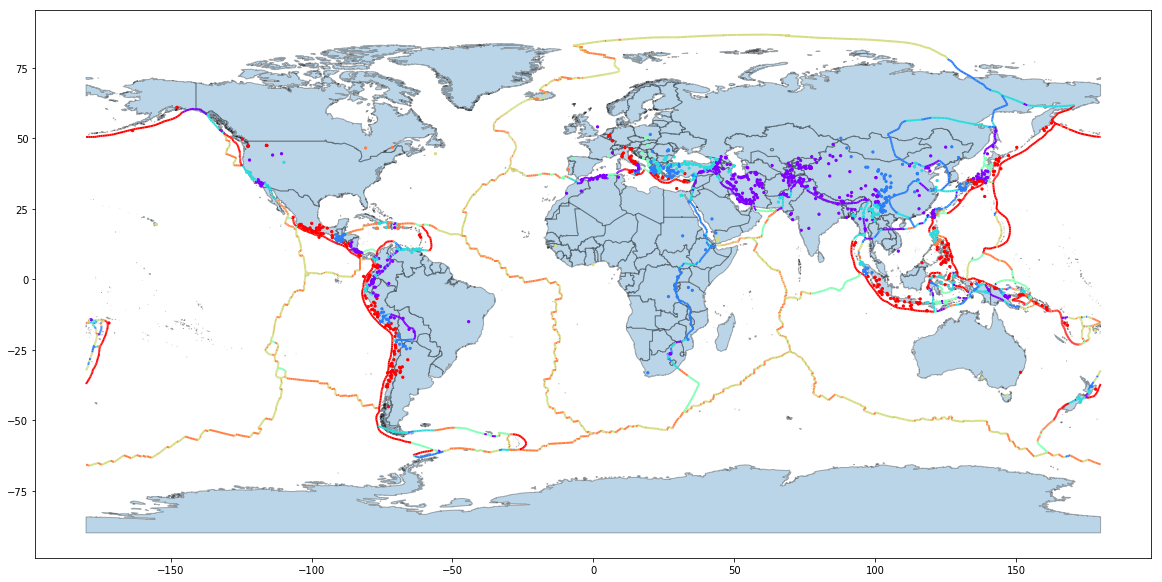

In [38]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_aspect('equal')

# Countries and plates
boundaries_gdf.plot(ax=ax, column='STEPCLASS', cmap='rainbow', lw=2.0)
countries_gdf.plot(ax=ax, edgecolor='black', alpha=0.3)

# all points (earthquakes, volcanoes, and vents)
boundary_distances_gdf.plot(ax=ax, column='closest_plate', cmap='rainbow', markersize=5)

[Text(0,0,'OCB'),
 Text(0,0,'CCB'),
 Text(0,0,'CTF'),
 Text(0,0,'SUB'),
 Text(0,0,'CRB'),
 Text(0,0,'OSR'),
 Text(0,0,'OTF')]

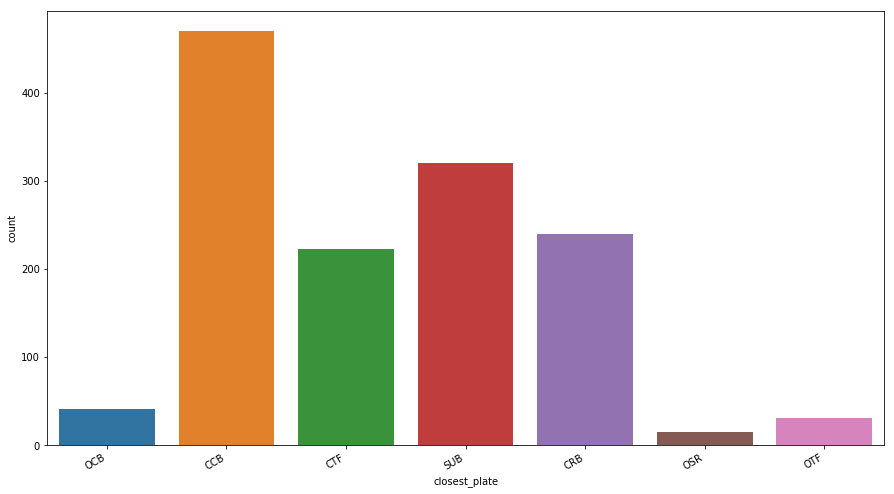

In [54]:
plt.subplots(figsize=(15, 8))
closest_plate_plot = sns.countplot(quake_plate_dist["closest_plate"])
closest_plate_plot.set_xticklabels(labels=quake_plate_dist["closest_plate"].unique(), rotation=30, ha='right')

In [63]:
# The count between the plate types and the dist df do not always match up. So, you need a way to make up for 
# the missing data.
quakes_closest = dict(quake_plate_dist["closest_plate"].value_counts())
plate_types = dict(boundaries_gdf['STEPCLASS'].value_counts())

type_counts = list()
for key, value in plate_types.items():
    key = key.strip()
    compare = {'type': key, 'plate': value, 'earthquakes': quakes_closest.get(key, 0)}
    
    type_counts.append(compare)

type_counts

[{'earthquakes': 15, 'plate': 1875, 'type': 'OSR'},
 {'earthquakes': 31, 'plate': 1147, 'type': 'OTF'},
 {'earthquakes': 320, 'plate': 1129, 'type': 'SUB'},
 {'earthquakes': 240, 'plate': 474, 'type': 'CRB'},
 {'earthquakes': 223, 'plate': 457, 'type': 'CTF'},
 {'earthquakes': 470, 'plate': 401, 'type': 'CCB'},
 {'earthquakes': 41, 'plate': 341, 'type': 'OCB'}]

In [64]:
"""CORRECTING FOR DIFFERENCES IN NUM OF VOLCANOES"""
# distance count as shown above
type_list = [plate_type['type'] for plate_type in type_counts]

dist_count = np.array([plate_type['earthquakes'] for plate_type in type_counts])
plate_count = np.array([plate_type['plate'] for plate_type in type_counts])

normalized_dist = np.divide(dist_count, plate_count)

Text(0,0.5,'normalized distance')

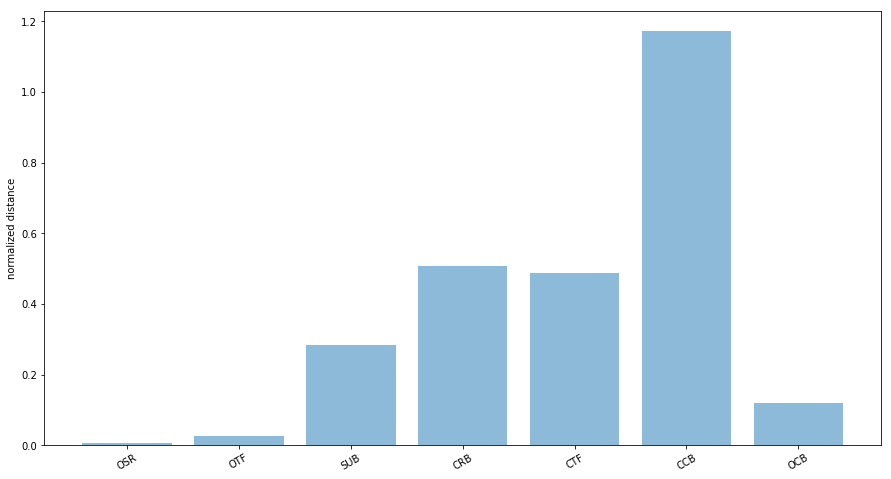

In [65]:
y_pos = np.arange(len(normalized_dist))
 
plt.figure(figsize=(15,8))
plt.bar(y_pos, normalized_dist, alpha=0.5)
plt.xticks(y_pos, type_list, rotation=30)
plt.ylabel('normalized distance')

In [66]:
def total_boundary_length(geoseries):
    lengths = []
    for line in geoseries:
        length = line.length
        lengths.append(length)
        total_length = np.sum(lengths)
    return total_length

In [69]:
sub_geo = boundaries_gdf[boundaries_gdf["STEPCLASS"].str.contains("SUB")].geometry
ccb_geo = boundaries_gdf[boundaries_gdf["STEPCLASS"].str.contains("CCB")].geometry
crb_geo = boundaries_gdf[boundaries_gdf["STEPCLASS"].str.contains("CRB")].geometry
ctf_geo = boundaries_gdf[boundaries_gdf["STEPCLASS"].str.contains("CTF")].geometry
ocb_geo = boundaries_gdf[boundaries_gdf["STEPCLASS"].str.contains("OCB")].geometry
osr_geo = boundaries_gdf[boundaries_gdf["STEPCLASS"].str.contains("OSR")].geometry
otf_geo = boundaries_gdf[boundaries_gdf["STEPCLASS"].str.contains("OTF")].geometry

In [70]:
dict_list = [sub_geo, ccb_geo, crb_geo, ctf_geo, ocb_geo, osr_geo, otf_geo]

boundaries_length = []

for geoseries in dict_list:
    total_length = total_boundary_length(geoseries)
    boundaries_length.append(total_length)
    
boundaries_length

[510.15978396960389,
 227.16539713527419,
 277.45574462724835,
 282.76180162839489,
 175.70936107173887,
 810.41473295295373,
 539.2965768111593]

In [72]:
quake_plate_dist["closest_plate"].value_counts()

CCB    470
SUB    320
CRB    240
CTF    223
OCB     41
OTF     31
OSR     15
Name: closest_plate, dtype: int64

In [73]:
bound_dist_count = np.array([320, 470, 240, 223, 41, 15, 31])
bound_length = np.array(boundaries_length)

In [74]:
norm_bound_dist = np.divide(bound_dist_count, bound_length)
norm_bound_dist

array([ 0.62725446,  2.06897708,  0.86500281,  0.78864966,  0.23333987,
        0.01850904,  0.05748229])

Text(0,0.5,'normalized distance to closest boundary')

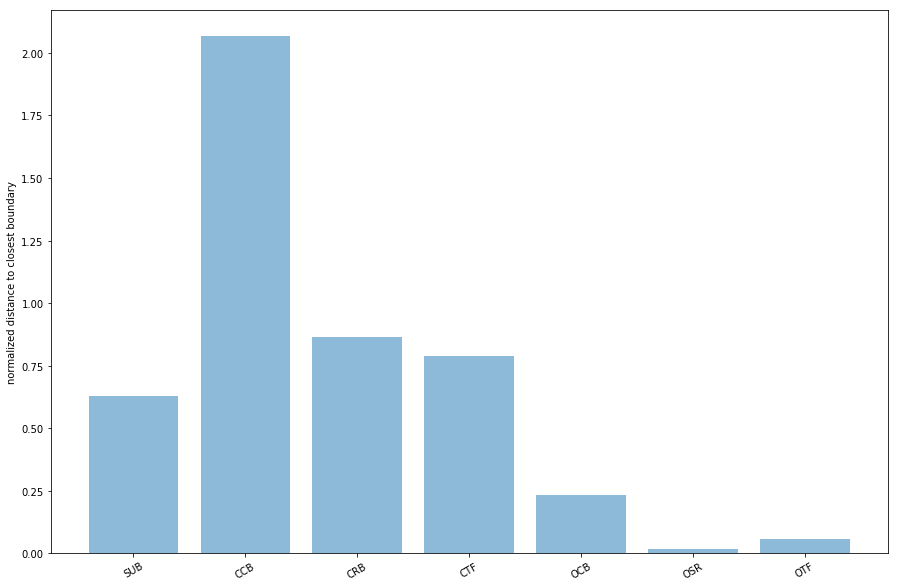

In [75]:
objects = ('SUB', 'CCB', 'CRB', 'CTF', 'OCB', 'OSR', 'OTF')
y_pos = np.arange(len(objects))
performance = norm_bound_dist
 
plt.figure(figsize=(15,10))
plt.bar(y_pos, performance, alpha=0.5)
plt.xticks(y_pos, objects, rotation = 30)
plt.ylabel('normalized distance to closest boundary')

# Developing a better understanding of the geologic setting where earthquakes occur.

Earthquakes are caused by geologic activity. Previously, predicting earthquakes has proven difficult because of the large variability in location, magnitude, and a host of other measured features. One aim of our group was to better understand the geologic setting where earthquakes occur by studying correlations between earthquakes and various geologic attributes and features. Below we outline the main areas of investigation.

The outer layer of the earth, called the crust, moves over the underlying layer, called the mantle, which contains liquid rock. The crust is composed of multiple pieces, called **tectonic plates**, that are constantly moving. When the plates contact and move by each other, the interaction can be felt as **earthquakes**. Additionally, other geologic features can be observed, including **volcanoes** and Hydrothermal **vents**. The **boundaries** between plates can be characterized in different ways and can cause different geologic features.

## Boundary Types

*Boundary type names are given with their abbreviation used in visualizations and analyses in parentheses*

To a large extent earthquakes occur close to tectonic plate boundaries. Considering there are different types of plate boundaries, we hypothesize that earthquakes may occur more frequently close to particular plate boundary types.

### Subduction Zone (SUB)
Subdiction zones are regions where two plates move towards each other and one slides below the other into the mantle. Subduction zones are a specific type of convergent boundary (covered later). The lower plate sinks into the mantle, rather than remaining below the upper plate and affecting its features. Along most plate boundaries the amount of subduction is 2-8 cm per year. (adapted from: https://en.wikipedia.org/wiki/Subduction)

### Divergent Boundaries (OSR(oceanic)/CRB(continental))

Divergent plate boundaries are locations where plates are moving away from one another. This occurs above rising convection currents from the liquid mantle. The rising current pushes up on the bottom of the crust, lifting it and flowing laterally beneath it. This lateral flow causes the plate material above to be dragged along in the direction of flow. At the crest of the uplift, the overlying plate is stretched thin, breaks and pulls apart. (http://geology.com/nsta/divergent-plate-boundaries.shtml)

### Transform Boundaries (OTF(oceanic)/CTF(continental))
Transform Plate Boundaries are locations where two plates slide along side one another. These are typically adjacent to divergent boundaries. Most transform faults are found in the ocean basin and connect offsets in the mid-ocean ridges. A smaller number connect mid-ocean ridges and subduction zones. (http://geology.com/nsta/transform-plate-boundaries.shtml)

### Convergent Boundary (OCB(oceanic)/CCB(continental))
Convergent plate boundaries are where two or more tectonic plates move towards each other. As a result of pressure, friction, and plate material melting in the mantle, earthquakes and volcanoes are common near convergent boundaries. The when the plates come into contact with one another, one plate can be subducted (see subduction zone). The overlying plate can be fractured or compressed, causing deformations that can be ovserved as mountain ranges. Additionally the subducted plate can heat and cause volcanoes near the boundary. (adapted from: https://en.wikipedia.org/wiki/Convergent_boundary and http://geology.com/nsta/convergent-plate-boundaries.shtml)

## Volcano Types

*Volcano type names are the same used in visualizations and analyses*

Volcanoes are geologic features that have been extensively studied and are influenced by plate tectonics, just as with **earthquakes**. There are many different types of volcanoes and we hypothesize that particular types of volcanoes may be correlated with an increased frequency of earthquakes. 

### Stratovolcanoes
Stratovolcanoes are tall conical mountains composed of lava flows and other material produced by the volcano such as ash and cinder. The material collects around the volcano opening and builds up in alternating layers to form the stereotypical cone shape. Stratovolcanoes are also known as composite volcanoes because they are created from multiple structures during different kinds of eruptions. Classic examples include Mount Fuji in Japan, Mayon Volcano in the Philippines, and Mount Vesuvius and Stromboli in Italy. (adapted from: https://en.wikipedia.org/wiki/Volcano)

### Shield Volcanoes
Shield volcanoes, so named for their broad, shield-like profiles, are formed by the eruption of quickly flowing lava that can move a great distance from a vent. They generally do not explode catastrophically. Shield volcanoes are more common in oceanic than continental settings. The Hawaiian volcanic chain is a series of shield cones, and they are common in Iceland, as well. (adapted from: https://en.wikipedia.org/wiki/Volcano)

### Cinder Cone
Cinder cones result from eruptions of mostly small pieces of volcanic rock that resemble cinders, which build up around the volcanic opening. These can be relatively short-lived eruptions that produce a cone-shaped hill perhaps 30 to 400 meters high. Most cinder cones erupt only once. Cinder cones may form as flank vents on larger volcanoes, or occur on their own. Parícutin in Mexico and Sunset Crater in Arizona are examples of cinder cones. In New Mexico, Caja del Rio is a volcanic field (see below) of over 60 cinder cones. (https://en.wikipedia.org/wiki/Volcano)

### Submarine Volcanoes
Submarine volcanoes are common features of the ocean floor. In shallow water, active volcanoes disclose their presence by blasting steam and rocky debris high above the ocean's surface. In the ocean's deep, the tremendous weight of the water above prevents the explosive release of steam and gases; however, they can be detected by underwater microphones and discoloration of water because of volcanic gases. Pillow lava is a common eruptive product of submarine volcanoes and is characterized by thick sequences of discontinuous pillow-shaped masses which form under water. Even large submarine eruptions may not disturb the ocean surface due to the rapid cooling effect and increased buoyancy of water (as compared to air) which often causes volcanic vents to form steep pillars on the ocean floor. Hydrothermal vents (see below) are common near these volcanoes, and some support peculiar ecosystems based on dissolved minerals. Over time, the formations created by submarine volcanoes may become so large that they break the ocean surface as new islands or floating pumice rafts. (https://en.wikipedia.org/wiki/Volcano)

### Fissure Vents
Fissure vents are linear volcanic vents through which lava erupts, usually without any explosive activity. The vent is often a few meters wide and may be many kilometers long. After some time the eruption builds up ash cones and may concentrate on one or some of them. Small fissure vents may not be easily discernible from the air, but the crater rows (see Laki) or the canyons (see Eldgjá) built up by some of them. (https://en.wikipedia.org/wiki/Fissure_vent)

### Calderas
Calderas are large cauldron-like depressions that form after a pocket of magma in the mantle escapes through a volcano. When large volumes of magma are erupted over a short time, a cavity is created and the overlying crust collapses in, leaving a massive depression at the surface (from one to dozens of kilometers in diameter). Only seven known caldera-forming collapses have occurred since the start of the 20th century, most recently at Bárðarbunga volcano in Iceland. (https://en.wikipedia.org/wiki/Caldera)

### Complex Volcanos
Complex volcanoes are mixed landforms consisting of connected volcano centers and their associated lava flows and debris. They may form due to changes in eruptive habit or in the location of the principal vent area on a particular volcano. Essentially, these are interconnected groups of different types of volcanoes. (adapted from: https://en.wikipedia.org/wiki/Complex_volcano)

### Volcanic Fields
A volcanic field is an area of the Earth's crust that is prone to localized volcanic activity. They usually contain 10 to 100 volcanoes such as cinder cones and are usually in clusters. Lava flows may also occur. They may contain one type of volcano or multiple. (adapted from: https://en.wikipedia.org/wiki/Volcanic_field)

### Domes
Lava domes (Dome) are built by slow eruptions of highly viscous lava. They are sometimes formed within the crater of a previous volcanic eruption, as in the case of Mount Saint Helens, but can also form independently, as in the case of Lassen Peak. Like stratovolcanoes, they can produce violent, explosive eruptions, but their lava generally does not flow far from the originating vent. (https://en.wikipedia.org/wiki/Volcano)

### Somma Volcanos
A somma volcano is a volcanic caldera that has been partially filled by a new central cone. The name comes from Mount Somma, a stratovolcano in southern Italy with a summit caldera in which the upper cone of Mount Vesuvius has grown. (https://en.wikipedia.org/wiki/Somma_volcano)

### Maars
Maar are broad, low volcanic craters caused by an explosion which occurs when groundwater comes into contact with hot lava or magma. Maars characteristically fill with water to form a relatively shallow crater lake, which may also be called a maar. Maars range in size from 60 to 8,000 m (200 to 26,250 ft) across and from 10 to 200 m (33 to 656 ft) deep. Most maars have low rims composed of a mixture of loose fragments of volcanic and other rocks. (adapted from: https://en.wikipedia.org/wiki/Maar)

### Pyroclastic Cones
Pyroclastic cones are built of fragmental material. They are found both as smaller additions to larger stratovolcanoes and shield volcanoes or as independent volcanic structures. Pyroclastic cones typically range from a few tens of meters to a few hundred meters in height and are most often formed during single eruptions, when explosively ejected material accumulates around the volcano opening. Pyroclastic cones can form rapidly, but remain active for long periods of time. Parícutin, the famous volcano born in Mexican cornfield in 1943, reached 80% of its 424 m height during its first year, but remained active for 9 years. (http://volcano.si.edu/learn_galleries.cfm?p=6)

### Tuff Rings
Tuff rings are small volcanos usually found in isolation that are produced by magma brought to the surface through a conduit from a deep-seated magma reservoir. They are characterized by rims that have a low, broad topographic profiles and gentle topographic slopes that are 25 degrees or less. The maximum thickness of the debris comprising the rim of a typical tuff ring is generally thin, less than 50 meters (160 ft) to 100 meters (330 ft) thick. The crater of a tuff ring generally has been excavated below the existing ground surface. As a result, water commonly fills a tuff ring’s crater to form a lake once eruptions cease. (adapted from: https://en.wikipedia.org/wiki/Volcanic_cone)

### Volcanic Plugs
Volcanic plugs are volcanic objects created when magma hardens within a volcano opening on an active volcano. When present, a plug can cause an extreme build-up of pressure if rising volatile-charged magma is trapped beneath it, and this can sometimes lead to an explosive eruption. Glacial erosion can lead to exposure of the plug on one side, while a long slope of material remains on the opposite side. If a plug is preserved, erosion may remove the surrounding rock while the erosion-resistant plug remains, producing a distinctive upstanding landform. (https://en.wikipedia.org/wiki/Volcanic_plug)

## Hydrothermal Vents

Hydrothermal vents are fissures in the crust from which geothermally heated water emerges. Hydrothermal vents are commonly found near volcanically active places, divergent boundaries, ocean basins, and hotspots. (https://en.wikipedia.org/wiki/Hydrothermal_vent)

## Tsunamis

A tsunamis is a series of waves in a water body caused by the displacement of a large volume of water, generally in an ocean or a large lake. Earthquakes, volcanic eruptions, landslides, glacier calvings, meteorite impacts and other disturbances above or below water all have the potential to generate a tsunami. Unlike normal ocean waves, which are generated by wind, or tides, which are generated by the gravitational pull of the Moon and the Sun, a tsunami is generated by the displacement of water. (adapted from: https://en.wikipedia.org/wiki/Tsunami)

In [88]:
Sum = np.sum(quake_vol_dist[quake_vol_dist["closest_vol"].str.contains('Stratovolcano')].Mag)
N = len(quake_vol_dist[quake_vol_dist["closest_vol"].str.contains('Stratovolcano')].Mag)
Mean = Sum/N
Mean

6.4571585369925213

In [110]:
mean_list = []
for vol in vol_types:
    Sum = np.sum(quake_vol_dist[quake_vol_dist["closest_vol"].str.contains(vol)].Mag)
    N = len(quake_vol_dist[quake_vol_dist["closest_vol"].str.contains(vol)].Mag)
    if N==0:
        Mean=0
    else:
        Mean = Sum/N
    mean_list.append(Mean)
means=np.array(mean_list)
means_5 = means[:5]

In [111]:
normalized_dist_5 = normalized_dist[:5]

In [113]:
to_plot = np.divide(means_5, normalized_dist_5)
to_plot

array([ 1.89713525,  2.74196574,  5.48827152,  2.5984533 ,  5.66923067])

Text(0,0.5,'normalized distance')

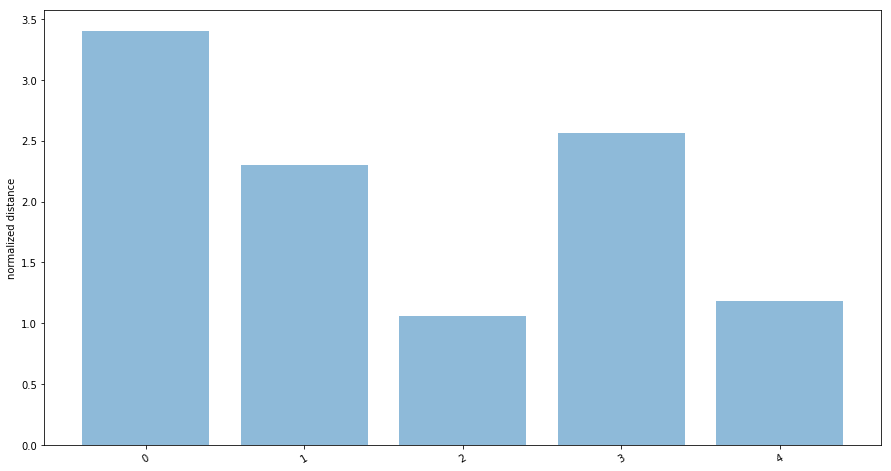

In [118]:
y_pos_test = np.arange(len(normalized_dist_5))
 
plt.figure(figsize=(15,8))
plt.bar(y_pos_test, normalized_dist_5, alpha=0.5)
plt.xticks(y_pos_test, rotation=30)
plt.ylabel('normalized distance')

In [82]:
quake_total_dists = pd.merge(
    left=quake_vol_dist, 
    right=quake_plate_dist, 
    how="inner", 
    on=["Country", "lat", "lng", "Depth_km", "Mag", "Secondary_Effects", "PDE_Shaking_Deaths", "PDE_Deaths", 
        "Utsu_Deaths", "EM-DAT_Deaths", "Other_Deaths", 'Year', 'Month', 'Day', 'Max_Deaths']
)

In [86]:
quake_total_dists = quake_total_dists.drop("geometry_y", axis = 1)
quake_total_dists.columns = ['Country', 'lat', 'lng', 'Depth_km', 'Mag', 'Secondary_Effects',
                             'PDE_Shaking_Deaths', 'PDE_Deaths', 'Utsu_Deaths', 'EM-DAT_Deaths',
                             'Other_Deaths', 'Year', 'Month', 'Day', 'Max_Deaths', 'geometry',
                             'Stratovolcano', 'Caldera', 'Shield', 'Complex Volcano', 'Submarine',
                             'Volcanic Field', 'Cinder Cone', 'Dome', 'Fissure vents',
                             'Somma Volcano', 'Maar', 'Pyroclastic Cone', 'Tuff Ring', 'Plug',
                             'None', 'vol', 'closest_vol', 'SUB', 'CCB', 'CRB', 'CTF',
                             'OCB', 'OSR', 'OTF', 'plates', 'closest_plate']
quake_total_dists.columns

Index(['Country', 'lat', 'lng', 'Depth_km', 'Mag', 'Secondary_Effects',
       'PDE_Shaking_Deaths', 'PDE_Deaths', 'Utsu_Deaths', 'EM-DAT_Deaths',
       'Other_Deaths', 'Year', 'Month', 'Day', 'Max_Deaths', 'geometry',
       'Stratovolcano', 'Caldera', 'Shield', 'Complex Volcano', 'Submarine',
       'Volcanic Field', 'Cinder Cone', 'Dome', 'Fissure vents',
       'Somma Volcano', 'Maar', 'Pyroclastic Cone', 'Tuff Ring', 'Plug',
       'None', 'vol', 'closest_vol', 'SUB', 'CCB', 'CRB', 'CTF', 'OCB', 'OSR',
       'OTF', 'plates', 'closest_plate'],
      dtype='object')